In [277]:
import cProfile
import os
import pickle
import pstats
import re
import time
from collections import namedtuple, defaultdict
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import rich.progress
import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys

import data_types
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns
from data_types import PickleOut
import commons
import rich.status
from rich.pretty import pprint
from rich import inspect
import textwrap

In [278]:
rc = commons.rc

In [279]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])
CVUBigTR = namedtuple("CVUBigTableRow", [
    "regModel",
    "cluster",
    "clusterSize",
    "wfName",
    "method",
    "res",
    #"schedCat",
    #"schedType",
    "cvSplit",
    "ukSplit"])

In [280]:
shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                      'SVR-linear'   : 'SVR - linear',
                      'SVR-poly'     : 'SVR - poly',
                      'SVR-rbf'      : 'SVR - rbf',
                      'SVR-sigmoid'  : 'SVR - sigmoid',
                      'Lasso'        : 'Lasso',
                      'LassoCV'      : 'Lasso CV',
                      'Ridge'        : 'Ridge',
                      'RidgeCV'      : 'Ridge CV',
                      'ElasticNet'   : 'Elastic Net',
                      'ElasticNetCV' : 'Elastic Net CV',
                      'BayesianRidge': 'Bayesian Ridge',
                      'ARD'          : 'Automatic Relevance Determination',
                      'SGD'          : 'Stochastic Gradient Descent',
                      'PA'           : 'Passive Aggressive',
                      'Huber'        : 'Huber',
                      'TheilSen'     : 'Theil Sen'}

In [281]:
def load_from_file(f, prog: rich.progress.Progress, barid):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl: dict = pickle.load(tmp)
    #
    m = re.match("(?:.*/)*(.*Model)\.(.*)_CV-(.*)_U-(.*)\.recSchedTimes\.pickle", f)
    modelDeg = modelDegLUT[m.group(1)]
    modelName = shortToLongNameLUT[m.group(2)]
    shortName = f"{modelDeg} / {modelName}"
    cvSplit = m.group(3)
    if cvSplit == "None":
        cvSplit = None
    ukSplit = m.group(4)
    if ukSplit == "None":
        ukSplit = None
    # for pre, deg in modelDegLUT.items():
    #     if pre in shortName:
    #         shortName = shortName.replace(pre + ".", f"{deg}/")
    #         break
    fmt = CVUBigTR
    #
    prog.reset(barid, total=len(pl.items()))
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : str(clusterName),
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    #"schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    #"schedType"  : mName,
                    "cvSplit"    : cvSplit,
                    "ukSplit"    : ukSplit
                }
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                # else:
                #     rowInfo["regModel"] = "N/A"
                #     rowInfo["schedCat"] = "random"
                #     rowInfo["schedType"] = "random"
                #     randomPs = [1, 2, 3]
                #     for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                #         if i + 1 in randomPs:
                #             rowInfo["method"] = mName + f"P{i * 10}"
                #             rowInfo["res"] = float(r)
                #             yield fmt(**rowInfo)
                #     rowInfo["method"] = mName + "Avg"
                #     rowInfo["res"] = float(statistics.mean(res))
                #     yield fmt(**rowInfo)
        prog.advance(barid)
    del pl


def load_random_from_files(d, prog: rich.progress.Progress, barid):
    if type(d) is str:
        d = Path(d)
    #
    refFile = d.joinpath(os.listdir(d)[0])
    with open(refFile, "br") as tmp:
        refP: dict = pickle.load(tmp)
    #
    fmt = CVUBigTR
    cls = list(refP.keys())
    wfs = list(refP[cls[0]].keys())
    del refP
    prog.reset(barid, total=len(cls) * len(wfs))
    pls = list()
    for fName in os.listdir(d):
        pFile = d.joinpath(fName)
        with open(pFile, "br") as tmp:
            pl: dict = pickle.load(tmp)
        for clusterName, cluster in pl.items():
            for wfName, wf in cluster.items():
                for methodName in list(wf.keys()):
                    if not "random" in methodName:
                        del pl[clusterName][wfName][methodName]
        #
        pls.append(pl)
        del pl
    for clusterName in cls:
        for wfName in wfs:
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            #
            randoms = [x for pl in pls for x in pl[clusterName][wfName]["randomSchedulerV1"]]
            for pl in pls:
                del pl[clusterName][wfName]
            randoms.sort()
            indices = [int(round(len(randoms) - 1 - x * (len(randoms) - 1), 0)) for x in [a / 10 for a in range(0, 11)]]
            randoms = [x for i, x in enumerate(randoms) if i in indices]
            rowInfo = {
                "regModel"   : "N/A",
                "cluster"    : str(clusterName),
                "clusterSize": len(clusterName),
                "wfName"     : wfShortName,
                "method"     : "randomV1",
                #"schedCat"   : "random",
                #"schedType"  : "random",
                "cvSplit"    : "N/A",
                "ukSplit"    : "N/A"
            }
            for i, r in enumerate(randoms):  # this only applies to the results of the randomScheduler(V1)
                rowInfo["method"] = f"randomV1P{i * 10}"
                rowInfo["res"] = float(r)
                yield fmt(**rowInfo)
            rowInfo["method"] = "randomV1Avg"
            rowInfo["res"] = float(statistics.mean(randoms))
            yield fmt(**rowInfo)
            prog.advance(barid)


def load_from_dir(d):
    with commons.stdProgress(rc) as prog:
        # with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        fileProg = prog.add_task("Files", total=len(os.listdir(d)))
        clusterProg = prog.add_task("Clusters")
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}", prog, clusterProg)
            prog.advance(fileProg)
        randomsProg = prog.add_task("Randoms")
        yield from load_random_from_files(d, prog, randomsProg)

In [282]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        bigtable = pds.DataFrame(load_from_dir(saveLoc), columns=CVUBigTR._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [283]:
def save_plot(obj, name, loc="./fig/", **kwargs):
    obj.savefig(f"{loc}{name}.pdf", transparent=True, **kwargs)
    obj.savefig(f"{loc}{name}.png", transparent=True, **kwargs)

# Get the recSchedTimes data

In [284]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# bigtable

# Get the cvRecSchedTimes data

In [285]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

In [177]:
wfNames = bigtable.wfName.unique()

In [178]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [179]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


# trying out new visualisation

In [180]:
def getRegModelMethodScores(fileLoc: Path, table, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(cur, mini, tol):
            return abs(cur - mini) <= tol

        crit = yep
    if scorer is None:
        def sc(cur, mini, tol):
            return 1

        scorer = sc
    if type(fileLoc) is str:
        fileLoc = Path(fileLoc)
    if fileLoc.is_file():
        with open(fileLoc, "br") as f:
            return pickle.load(f)
    else:
        grouped = table[table.regModel != "N/A"].pivot(["cluster", "wfName", "regModel"], "method", "res")
        clWFCombs = itertools.product(clusters, wfNames)
        numclWFCombs = len(list(clWFCombs))
        clWFCombs = itertools.product(clusters, wfNames)
        rMMethCombs = list(itertools.product(regModels, methods))
        # regModelMethodScores = defaultdict(lambda: 0)
        with commons.stdProgress(rc) as prog:
            cvwfProg = prog.add_task("Cluster/Workflow", total=numclWFCombs)
            regModelMethodScores = defaultdict(lambda: 0)

            for clwf, subtable in grouped.groupby(level=(0, 1), group_keys=False):
                c, wf = clwf
                subtable = subtable.droplevel(["cluster", "wfName"])
                minimumTime = subtable.min().min()
                for rmmetch in rMMethCombs:
                    rM, meth = rmmetch
                    # rc.log(subtable.loc[rM, meth], minimumTime, abs(subtable.loc[rM, meth] - minimumTime), abs(subtable.loc[rM, meth] - minimumTime) <= tol)
                    curr = subtable.loc[rM, meth]
                    if type(tol) is int or type(tol) is float:
                        t = tol
                    else:
                        t = tol(curr, minimumTime)
                    if crit(curr, minimumTime, t):
                        regModelMethodScores[rmmetch] = regModelMethodScores[rmmetch] + scorer(curr, minimumTime, t)
                prog.advance(cvwfProg)
            regModelMethodScores = dict(regModelMethodScores)
        #
        with open(fileLoc, "bw") as f:
            pickle.dump(regModelMethodScores, f)
        return dict(regModelMethodScores)

------

In [181]:
tmp = bigtable[bigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [182]:
confs = dict()
with open("percentileModels", "r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l: PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle", fName.strip())
            confs[f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"] = commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])


In [183]:
confs

{
│   '5 / Ordinary Least Squares': 1.0,
│   '3 / Ridge': 0.9231538458419148,
│   ... +9
}

In [184]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [185]:
pprint(regModels)

[
│   '5 / Ordinary Least Squares',
│   '3 / Ridge',
│   '3 / SVR - linear',
│   '3 / Elastic Net CV',
│   '2 / Ridge CV',
│   '1 / Ordinary Least Squares',
│   '1 / Lasso CV',
│   '1 / SVR - linear',
│   '3 / Elastic Net',
│   '1 / Elastic Net',
│   '4 / Passive Aggressive'
]

In [186]:
regModelMethodScores = getRegModelMethodScores("regModelMethodScores.pickle", bigtable)

In [187]:
regModelMethodDiffs = getRegModelMethodScores("regModelMethodDiffs.pickle", bigtable, crit=lambda a, b, c: True, scorer=lambda cur, mini, tol: abs(cur - mini))

In [188]:
regModelMethodScores10P = getRegModelMethodScores("regModelMethodScores10P.pickle",
                                                  None,  #bigtable,
                                                  tol=lambda cur, mini: 10 * mini / 100)

In [189]:
regModelMethodScores

{
│   ('1 / Lasso CV', 'recommenderV1'): 5346,
│   ('1 / Lasso CV', 'recommenderV1H1'): 5516,
│   ... +86
}

In [190]:
regModelMethodDiffs

{
│   ('5 / Ordinary Least Squares', 'recommenderV1'): 239649005.83414665,
│   ('5 / Ordinary Least Squares', 'recommenderV1H1'): 275930202.1803047,
│   ... +86
}

In [191]:
regModelMethodScores10P

{
│   ('1 / Lasso CV', 'recommenderV1'): 35744,
│   ('1 / Lasso CV', 'recommenderV1H1'): 35850,
│   ... +86
}

-------------

In [192]:
regModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores.items():
    rM, meth = rm
    regModelMethodScoresDF.loc[rM, meth] = s

In [193]:
regModelMethodScoresDF

recommenderV1 
 recommenderV1H1 
 recommenderV1H2 
 recommenderV1H3 
 recommenderV2 
 recommenderV2H1 
 recommenderV2H2 
 recommenderV2H3 
 
 
 
 
 5 / Ordinary Least Squares 
 25731.0 
 27353.0 
 27353.0 
 28508.0 
 9615.0 
 9903.0 
 9903.0 
 9654.0 
 
 
 3 / Ridge 
 9628.0 
 10563.0 
 10563.0 
 11010.0 
 6874.0 
 6824.0 
 6824.0 
 6643.0 
 
 
 3 / SVR - linear 
 5818.0 
 6311.0 
 6311.0 
 6909.0 
 5492.0 
 5875.0 
 5875.0 
 5797.0 
 
 
 3 / Elastic Net CV 
 7031.0 
 6694.0 
 6694.0 
 6641.0 
 5087.0 
 5512.0 
 5512.0 
 5272.0 
 
 
 2 / Ridge CV 
 5328.0 
 5502.0 
 5502.0 
 5439.0 
 5277.0 
 5668.0 
 5668.0 
 5445.0 
 
 
 1 / Ordinary Least Squares 
 5369.0 
 5422.0 
 5422.0 
 5116.0 
 4605.0 
 5089.0 
 5089.0 
 4854.0 
 
 
 1 / Lasso CV 
 5346.0 
 5516.0 
 5516.0 
 5329.0 
 4467.0 
 4961.0 
 4961.0 
 4766.0 
 
 
 1 / SVR - linear 
 4731.0 
 5343.0 
 5343.0 
 5141.0 
 4179.0 
 4546.0 
 4546.0 
 4344.0 
 
 
 3 / Elastic Net 
 5347.0 
 4954.0 
 4954.0 
 4851.0 
 3742.0 
 4000.0 
 4000.0 
 3851.0 
 
 
 1 / Elastic Net 
 3789.0 
 4030.0 
 4030.0 
 4232.0 
 2613.0 
 2895.0 
 2895.0 
 2833.0 
 
 
 4 / Passive Aggressive 
 4786.0 
 4596.0 
 4596.0 
 4877.0 
 2888.0 
 3024.0 
 3024.0 
 2928.0

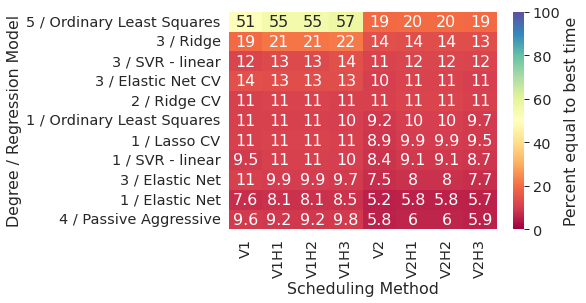

In [194]:
# normalize
total = 50_000
tmp = regModelMethodScoresDF.transform(lambda x: 100 * x / total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScoresDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmapBIS", bbox_inches="tight")
plt.show()

In [195]:
regModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores10P.items():
    rM, meth = rm
    regModelMethodScores10PDF.loc[rM, meth] = s

In [196]:
regModelMethodScores10PDF

recommenderV1 
 recommenderV1H1 
 recommenderV1H2 
 recommenderV1H3 
 recommenderV2 
 recommenderV2H1 
 recommenderV2H2 
 recommenderV2H3 
 
 
 
 
 5 / Ordinary Least Squares 
 43509.0 
 43304.0 
 43304.0 
 44438.0 
 37449.0 
 36687.0 
 36687.0 
 36050.0 
 
 
 3 / Ridge 
 42956.0 
 42587.0 
 42587.0 
 43463.0 
 37101.0 
 35902.0 
 35902.0 
 34888.0 
 
 
 3 / SVR - linear 
 38292.0 
 39259.0 
 39259.0 
 40567.0 
 35636.0 
 34450.0 
 34450.0 
 33553.0 
 
 
 3 / Elastic Net CV 
 38136.0 
 38746.0 
 38746.0 
 39246.0 
 34599.0 
 34365.0 
 34365.0 
 32863.0 
 
 
 2 / Ridge CV 
 37002.0 
 38431.0 
 38431.0 
 38518.0 
 35209.0 
 35127.0 
 35127.0 
 33285.0 
 
 
 1 / Ordinary Least Squares 
 33601.0 
 34683.0 
 34683.0 
 34709.0 
 33180.0 
 33224.0 
 33224.0 
 31051.0 
 
 
 1 / Lasso CV 
 35744.0 
 35850.0 
 35850.0 
 35905.0 
 32357.0 
 32831.0 
 32831.0 
 30720.0 
 
 
 1 / SVR - linear 
 33344.0 
 34826.0 
 34826.0 
 34813.0 
 32533.0 
 32668.0 
 32668.0 
 30441.0 
 
 
 3 / Elastic Net 
 34241.0 
 33357.0 
 33357.0 
 33455.0 
 30570.0 
 29937.0 
 29937.0 
 27852.0 
 
 
 1 / Elastic Net 
 30086.0 
 30887.0 
 30887.0 
 30790.0 
 27218.0 
 26728.0 
 26728.0 
 25694.0 
 
 
 4 / Passive Aggressive 
 30860.0 
 29533.0 
 29533.0 
 30166.0 
 26517.0 
 25167.0 
 25167.0 
 24698.0

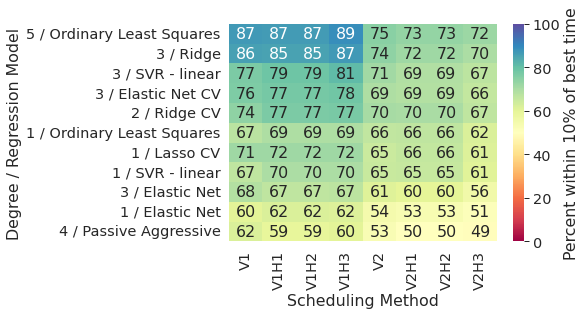

In [197]:
# normalize
total = 50_000
tmp = regModelMethodScores10PDF.transform(lambda x: 100 * x / total)
#
aspect = 5/8
width= 8
#plt.figure(figsize=(width,width*aspect))
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScores10PDF.columns],
                 cbar_kws={"label": "Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmap10P", bbox_inches="tight")
plt.show()

In [198]:
regModelMethodDiffsDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodDiffs.items():
    rM, meth = rm
    regModelMethodDiffsDF.loc[rM, meth] = s

In [199]:
regModelMethodDiffsDF

recommenderV1 
 recommenderV1H1 
 recommenderV1H2 
 recommenderV1H3 
 recommenderV2 
 recommenderV2H1 
 recommenderV2H2 
 recommenderV2H3 
 
 
 
 
 5 / Ordinary Least Squares 
 2.3965e+08 
 2.7593e+08 
 2.7593e+08 
 2.3164e+08 
 6.6333e+08 
 5.7857e+08 
 5.7857e+08 
 6.1306e+08 
 
 
 3 / Ridge 
 2.6382e+08 
 3.0214e+08 
 3.0214e+08 
 2.7633e+08 
 6.9238e+08 
 5.9636e+08 
 5.9636e+08 
 6.5229e+08 
 
 
 3 / SVR - linear 
 3.7813e+08 
 3.8018e+08 
 3.8018e+08 
 3.4609e+08 
 7.2483e+08 
 6.3134e+08 
 6.3134e+08 
 6.8597e+08 
 
 
 3 / Elastic Net CV 
 3.7100e+08 
 3.9290e+08 
 3.9290e+08 
 3.8251e+08 
 7.4505e+08 
 5.8901e+08 
 5.8901e+08 
 6.6543e+08 
 
 
 2 / Ridge CV 
 4.1547e+08 
 4.0576e+08 
 4.0576e+08 
 4.0327e+08 
 7.6519e+08 
 5.9811e+08 
 5.9811e+08 
 6.7828e+08 
 
 
 1 / Ordinary Least Squares 
 4.7633e+08 
 4.7585e+08 
 4.7585e+08 
 4.7248e+08 
 8.3087e+08 
 6.1528e+08 
 6.1528e+08 
 7.0887e+08 
 
 
 1 / Lasso CV 
 4.3125e+08 
 4.6967e+08 
 4.6967e+08 
 4.6468e+08 
 8.2630e+08 
 6.0997e+08 
 6.0997e+08 
 6.9763e+08 
 
 
 1 / SVR - linear 
 4.6586e+08 
 4.6263e+08 
 4.6263e+08 
 4.5944e+08 
 8.1655e+08 
 6.1574e+08 
 6.1574e+08 
 7.0690e+08 
 
 
 3 / Elastic Net 
 4.2554e+08 
 4.9394e+08 
 4.9394e+08 
 4.8763e+08 
 8.5908e+08 
 6.8734e+08 
 6.8734e+08 
 7.8869e+08 
 
 
 1 / Elastic Net 
 5.8913e+08 
 6.2854e+08 
 6.2854e+08 
 6.2123e+08 
 9.4519e+08 
 8.2115e+08 
 8.2115e+08 
 8.8593e+08 
 
 
 4 / Passive Aggressive 
 6.8665e+08 
 7.5190e+08 
 7.5190e+08 
 7.2861e+08 
 1.0013e+09 
 9.8031e+08 
 9.8031e+08 
 1.0170e+09

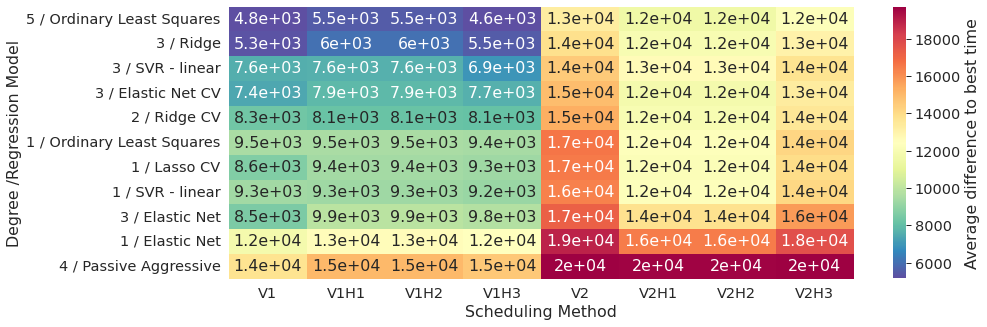

In [200]:
# normalize
total = 50_000
tmp = regModelMethodDiffsDF.transform(lambda x: x / total)
#
aspect = 5/14
width= 14
plt.figure(figsize=(width,width*aspect))
ax = sns.heatmap(tmp,
                 cmap=sns.color_palette("Spectral", as_cmap=True).reversed(),
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodDiffsDF.columns],
                 cbar_kws={"label": "Average difference to best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /Regression Model")
#ax.set_yticklabels(ax.get_yticklabels(),rotation=45, va="top")
#plt.yticks(rotation=45)
#ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "heatmapDiff", bbox_inches="tight")
plt.show()

------

In [201]:
tmp = cvBigtable[cvBigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [202]:
confs = dict()
with open("percentileCVModels", "r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l: PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle", fName.strip())
            key = f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"
            p = confs.get(key, list())
            confs[key] = p + [commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])]
for k, l in confs.items():
    confs[k] = commons.jamGeomean(l)


In [203]:
pprint(confs)

{
│   '1 / SVR - rbf': 0.8387889322997693,
│   '1 / Stochastic Gradient Descent': 0.7855591233166146,
│   '3 / SVR - rbf': 0.46743515455075557
}

In [204]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [205]:
pprint(regModels)

['1 / SVR - rbf', '1 / Stochastic Gradient Descent', '3 / SVR - rbf']

In [206]:
cvScores = dict()
cv10PScores = dict()
cvDiffs = dict()
j = 1
for i,d in cvBigtable[cvBigtable.regModel != "N/A"].groupby(["cvSplit","ukSplit"]):
    if i[0] == i[1]:
        continue
    rc.log(j, i)
    cvScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores_CV-{i[0]}_U-{i[1]}.pickle",
                                          d.drop(["cvSplit","ukSplit"], axis=1)
                                          )
    cv10PScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores10P_CV-{i[0]}_U-{i[1]}.pickle",
                                             d.drop(["cvSplit","ukSplit"], axis=1),
                                             tol=lambda cur, mini: 10 * mini / 100)
    cvDiffs[i] = getRegModelMethodScores(f"cvRegModelMethodDiffs_CV-{i[0]}_U-{i[1]}.pickle",
                                          d.drop(["cvSplit","ukSplit"], axis=1), crit=lambda a, b, c: True, scorer=lambda cur, mini, tol: abs(cur - mini)
                                          )
    j += 1

[23:13:59] 1                                                                  ]8;id=15543;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('chipseq', 'eager')

           2                                                                  ]8;id=39538;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('chipseq', 'methylseq')

           3                                                                  ]8;id=220675;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('chipseq', 'sarek')

           4                                                                  ]8;id=45778;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('chipseq', 'viralrecon')

[23:14:00] 5                                                                  ]8;id=494477;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('eager', 'chipseq')

           6                                                                  ]8;id=523229;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('eager', 'methylseq')

           7                                                                  ]8;id=287140;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('eager', 'sarek')

           8                                                                  ]8;id=192203;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('eager', 'viralrecon')

[23:14:01] 9                                                                  ]8;id=424999;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('methylseq', 'chipseq')

           10                                                                 ]8;id=489148;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('methylseq', 'eager')

           11                                                                 ]8;id=378148;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('methylseq', 'sarek')

           12                                                                 ]8;id=86175;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('methylseq', 'viralrecon')

           13                                                                 ]8;id=52365;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('sarek', 'chipseq')

[23:14:02] 14                                                                 ]8;id=88289;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('sarek', 'eager')

           15                                                                 ]8;id=996789;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('sarek', 'methylseq')

           16                                                                 ]8;id=435465;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('sarek', 'viralrecon')

           17                                                                 ]8;id=355668;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('viralrecon', 'chipseq')

           18                                                                 ]8;id=163886;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('viralrecon', 'eager')

[23:14:03] 19                                                                 ]8;id=220239;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('viralrecon', 'methylseq')

           20                                                                 ]8;id=31342;file:///tmp/ipykernel_20666/2769757949.py\2769757949.py]8;;\:8
           ('viralrecon', 'sarek')

In [207]:
cvScores

{
│   ('chipseq', 'eager'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 19175,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 19638,
│   │   ... +22
│   },
│   ('chipseq', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 12151,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 13657,
│   │   ... +22
│   },
│   ... +18
}

In [208]:
cv10PScores

{
│   ('chipseq', 'eager'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 38578,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 39227,
│   │   ... +22
│   },
│   ('chipseq', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 39139,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 39904,
│   │   ... +22
│   },
│   ... +18
}

In [209]:
cvDiffs

{
│   ('chipseq', 'eager'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 366134546.3245904,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 378181821.22831625,
│   │   ... +22
│   },
│   ('chipseq', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 332090535.3195803,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 349393656.32692266,
│   │   ... +22
│   },
│   ... +18
}

In [210]:
cvRegModelMethodScores = dict()
for _, sc in cvScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores[rmmeth] = cvRegModelMethodScores.get(rmmeth, 0) + r

In [211]:
cvRegModelMethodScores10P = dict()
for _, sc in cv10PScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores10P[rmmeth] = cvRegModelMethodScores10P.get(rmmeth, 0) + r

In [212]:
cvRegModelMethodDiffs = dict()
for _, sc in cvDiffs.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodDiffs[rmmeth] = cvRegModelMethodDiffs.get(rmmeth, 0) + r

In [213]:
cvRegModelMethodScores

{
│   ('1 / SVR - rbf', 'recommenderV1'): 259713,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 275020,
│   ... +22
}

In [214]:
cvRegModelMethodScores10P

{
│   ('1 / SVR - rbf', 'recommenderV1'): 759588,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 765871,
│   ... +22
}

In [215]:
cvRegModelMethodDiffs

{
│   ('1 / SVR - rbf', 'recommenderV1'): 7180676740.1884365,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 7635328122.482503,
│   ... +22
}

In [216]:
cvRegModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores.items():
    rM, meth = rm
    cvRegModelMethodScoresDF.loc[rM, meth] = s

In [217]:
cvRegModelMethodScoresDF

recommenderV1 
 recommenderV1H1 
 recommenderV1H2 
 recommenderV1H3 
 recommenderV2 
 recommenderV2H1 
 recommenderV2H2 
 recommenderV2H3 
 
 
 
 
 1 / SVR - rbf 
 259713.0 
 275020.0 
 275020.0 
 290446.0 
 198989.0 
 218629.0 
 218629.0 
 205442.0 
 
 
 1 / Stochastic Gradient Descent 
 197793.0 
 199337.0 
 199337.0 
 197955.0 
 170579.0 
 186399.0 
 186399.0 
 175455.0 
 
 
 3 / SVR - rbf 
 197748.0 
 196185.0 
 196185.0 
 208983.0 
 111865.0 
 120898.0 
 120898.0 
 117597.0

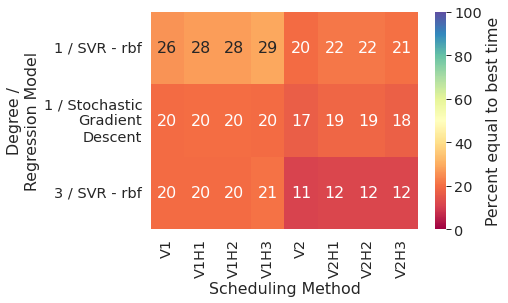

In [218]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodScoresDF.transform(lambda x: 100 * x / total)
#
#plt.figure(figsize=(7,3))
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScoresDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /\nRegression Model")
ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "cvHeatmapBIS", bbox_inches="tight")
plt.show()

In [219]:
cvRegModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores10P.items():
    rM, meth = rm
    cvRegModelMethodScores10PDF.loc[rM, meth] = s

In [220]:
cvRegModelMethodScores10PDF

recommenderV1 
 recommenderV1H1 
 recommenderV1H2 
 recommenderV1H3 
 recommenderV2 
 recommenderV2H1 
 recommenderV2H2 
 recommenderV2H3 
 
 
 
 
 1 / SVR - rbf 
 759588.0 
 765871.0 
 765871.0 
 778016.0 
 687719.0 
 683672.0 
 683672.0 
 646950.0 
 
 
 1 / Stochastic Gradient Descent 
 708525.0 
 722652.0 
 722652.0 
 724040.0 
 656117.0 
 677033.0 
 677033.0 
 631148.0 
 
 
 3 / SVR - rbf 
 656111.0 
 650994.0 
 650994.0 
 658911.0 
 550538.0 
 529632.0 
 529632.0 
 516272.0

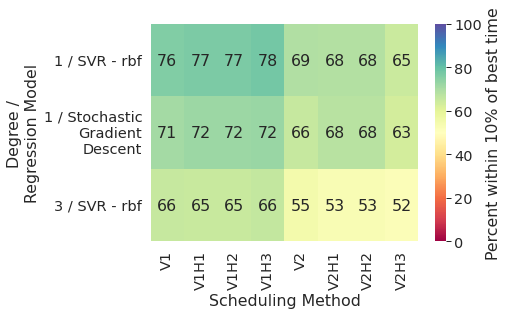

In [221]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodScores10PDF.transform(lambda x: 100 * x / total)
#
#plt.figure(figsize=(5.5,2.2))
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScores10PDF.columns],
                 cbar_kws={"label": "Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /\nRegression Model")
ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "cvHeatmap10P", bbox_inches="tight")
plt.show()

In [222]:
cvRegModelMethodDiffsDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodDiffs.items():
    rM, meth = rm
    cvRegModelMethodDiffsDF.loc[rM, meth] = s

In [223]:
cvRegModelMethodDiffsDF

recommenderV1 
 recommenderV1H1 
 recommenderV1H2 
 recommenderV1H3 
 recommenderV2 
 recommenderV2H1 
 recommenderV2H2 
 recommenderV2H3 
 
 
 
 
 1 / SVR - rbf 
 7.1807e+09 
 7.6353e+09 
 7.6353e+09 
 7.2267e+09 
 1.4852e+10 
 1.1874e+10 
 1.1874e+10 
 1.3449e+10 
 
 
 1 / Stochastic Gradient Descent 
 8.5111e+09 
 8.8966e+09 
 8.8966e+09 
 8.8098e+09 
 1.5957e+10 
 1.1449e+10 
 1.1449e+10 
 1.3356e+10 
 
 
 3 / SVR - rbf 
 9.6830e+09 
 1.0857e+10 
 1.0857e+10 
 1.0402e+10 
 1.9888e+10 
 1.9704e+10 
 1.9704e+10 
 2.0392e+10

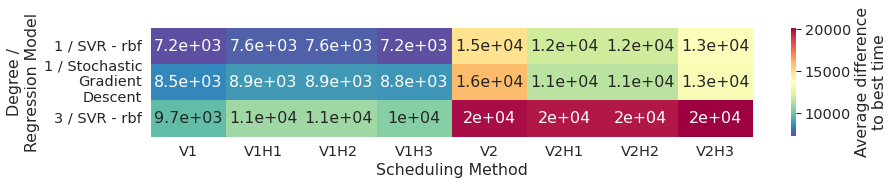

In [224]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodDiffsDF.transform(lambda x: x / total)
#
plt.figure(figsize=(13.5,2))
ax = sns.heatmap(tmp,
                 cmap=sns.color_palette("Spectral", as_cmap=True).reversed(),
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodDiffsDF.columns],
                 cbar_kws={"label": "Average difference\nto best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree /\nRegression Model")
ax.set_yticklabels(["\n".join(textwrap.wrap(t.get_text(), 15)) for t in ax.get_yticklabels()])
fig = ax.get_figure()
save_plot(fig, "cvHeatmapDiff", bbox_inches="tight")
plt.show()

------

In [225]:
def compareCVFull(fullTable, cvSplitTable, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(res, cvres, tol):
            dist = abs(res - cvres)
            if dist <= tol:
                dec = 0
            elif res < cvres:
                dec = -1
            else:
                dec = 1
            return dec

        crit = yep
    if scorer is None:
        def sc(res, cvres, tol):
            return 1

        scorer = sc
    #
    totalTable = fullTable.join(cvSplitTable.set_index(["cluster", "wfName"]), on=["cluster", "wfName"], rsuffix="_cv")
    #
    clWFCombs = itertools.product(clusters, wfNames)
    numclWFCombs = len(list(clWFCombs))
    #
    comp = dict(full=0, equal=0, cv=0)
    with commons.stdProgress(rc) as prog:
        cvwfProg = prog.add_task("Comparing", total=numclWFCombs)

        for row in totalTable.itertuples():
            if type(tol) is int or type(tol) is float:
                t = tol
            else:
                t = tol(row.res, row.res_cv)
            dec = crit(row.res, row.res_cv, t)
            if dec == -1:
                key = "full"
            elif dec == 0:
                key = "equal"
            elif dec == 1:
                key = "cv"
            else:
                raise Exception("crit must return -1, 0, or 1")

            comp[key] = comp[key] + scorer(row.res, row.res_cv, t)
            prog.advance(cvwfProg)
    return comp

In [226]:
maxi = regModelMethodScoresDF.max().max()
cand = regModelMethodScoresDF.idxmax().reset_index()
cand.columns = ["method", "model"]
bisRmmeth = None
for i in cand.itertuples():
    if regModelMethodScoresDF.loc[i.model, i.method] == maxi:
        bisRmmeth = (i.model, i.method)
        break
bisRmmeth

(
│   '5 / Ordinary Least Squares',
│   'recommenderV1H3'
)

In [227]:
if Path("bisBigtable.pickle").is_file():
    with open("bisBigtable.pickle", "br") as f:
        bisBigtable = pickle.load(f)
else:
    bisBigtable = bigtable.query("regModel==@bisRmmeth[0] and method==@bisRmmeth[1]")
    #bisBigtable.drop(["regModel", "method", "cvSplit", "ukSplit", "clusterSize"], axis=1)
    with open("bisBigtable.pickle", "bw") as f:
        bisBigtable = pickle.dump(bisBigtable, f)
bisBigtable

regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 res 
 cvSplit 
 ukSplit 
 
 
 
 
 400003 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 33364.6500 
 None 
 None 
 
 
 400011 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 39318.6000 
 None 
 None 
 
 
 400019 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 126638.2667 
 None 
 None 
 
 
 400027 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 27151.2000 
 None 
 None 
 
 
 400035 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 138079.2667 
 None 
 None 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 799963 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 sarek 
 recommenderV1H3 
 33356.3500 
 None 
 None 
 
 
 799971 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 methylseq 
 recommenderV1H3 
 39318.6000 
 None 
 None 
 
 
 799979 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 chipseq 
 recommenderV1H3 
 126735.6333 
 None 
 None 
 
 
 799987 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 eager 
 recommenderV1H3 
 27574.6000 
 None 
 None 
 
 
 799995 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 viralrecon 
 recommenderV1H3 
 134428.4000 
 None 
 None 
 
 
 
 50000 rows × 8 columns

In [228]:
maxi = cvRegModelMethodScoresDF.max().max()
cand = cvRegModelMethodScoresDF.idxmax().reset_index()
cand.columns = ["method", "model"]
bisCVRmmeth = None
for i in cand.itertuples():
    if cvRegModelMethodScoresDF.loc[i.model, i.method] == maxi:
        bisCVRmmeth = (i.model, i.method)
        break
bisCVRmmeth

(
│   '1 / SVR - rbf',
│   'recommenderV1H3'
)

In [229]:
if Path("bisCVBigtable.pickle").is_file():
    with open("bisCVBigtable.pickle", "br") as f:
        bisCVBigtable = pickle.load(f)
else:
    bisCVBigtable = cvBigtable.query("regModel==@bisCVRmmeth[0] and method==@bisCVRmmeth[1]")
    #bisCVBigtable.drop(["regModel", "method", "clusterSize"], axis=1)
    with open("bisCVBigtable.pickle", "bw") as f:
        pickle.dump(bisCVBigtable, f)
bisCVBigtable

regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 res 
 cvSplit 
 ukSplit 
 
 
 
 
 400003 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 33866.6667 
 viralrecon 
 eager 
 
 
 400011 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 39914.7333 
 viralrecon 
 eager 
 
 
 400019 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 136622.2000 
 viralrecon 
 eager 
 
 
 400027 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 28006.6000 
 viralrecon 
 eager 
 
 
 400035 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 150695.5333 
 viralrecon 
 eager 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 20399963 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 sarek 
 recommenderV1H3 
 44115.8500 
 chipseq 
 eager 
 
 
 20399971 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 methylseq 
 recommenderV1H3 
 44736.2667 
 chipseq 
 eager 
 
 
 20399979 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 chipseq 
 recommenderV1H3 
 184831.8333 
 chipseq 
 eager 
 
 
 20399987 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 eager 
 recommenderV1H3 
 38532.4000 
 chipseq 
 eager 
 
 
 20399995 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 recommenderV1H3 
 188586.2000 
 chipseq 
 eager 
 
 
 
 1000000 rows × 8 columns

------------

In [286]:
def comparePerWFCVFull(fullTable, cvSplitTable, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(res, cvres, tol):
            return abs(res - cvres)<=tol

        crit = yep
    if scorer is None:
        def sc(res, cvres, tol):
            return 1

        scorer = sc
    #
    out = dict()
    for wf, fD in fullTable.groupby(["wfName"]):
        out[wf]=dict()
        #
        totalTable = fD.join(cvSplitTable[cvSplitTable.wfName==wf].set_index(["cluster"]), on=["cluster"], rsuffix="_cv")
        totalTable["diff"] = totalTable["res_cv"]-totalTable["res"]
        out[wf]=totalTable["diff"].sum()
    return out

In [288]:
fileLoc=Path("compPerWFCV_BISFull.pickle")
if fileLoc.is_file():
    with open(fileLoc, "br") as f:
        comp = pickle.load(f)
else:
    comp=dict()
    for rmmeth, rmD in cvBigtable[cvBigtable.regModel!="N/A"].groupby(["regModel","method"]):
        rc.log(rmmeth)
        comp[rmmeth] = dict()
        for split, spD in rmD.groupby(["cvSplit", "ukSplit"]):
            rc.log(split)
            comp[rmmeth][split]= comparePerWFCVFull(bisBigtable, spD) 
    with open(fileLoc, "bw") as f:
        pickle.dump(comp, f)

[00:02:34] ('1 / SVR - rbf', 'recommenderV1')                                  ]8;id=109367;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=799782;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=659389;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=300691;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:35] ('chipseq', 'viralrecon')                                          ]8;id=273604;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=218962;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=850635;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=511093;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=47608;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=435172;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=730987;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=407440;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=319640;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:36] ('sarek', 'chipseq')                                               ]8;id=585109;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=18980;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=427664;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=934732;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=61784;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=999142;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=398026;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=993537;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / SVR - rbf', 'recommenderV1H1')                                ]8;id=285073;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

[00:02:37] ('chipseq', 'eager')                                               ]8;id=876283;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=808273;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=29194;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=480899;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=725839;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=568846;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=882054;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=683726;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=731725;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:38] ('methylseq', 'eager')                                             ]8;id=918570;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=189169;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=367254;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=486978;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=469576;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=473165;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=105453;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=431433;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=189045;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:39] ('viralrecon', 'methylseq')                                        ]8;id=186967;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=407796;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / SVR - rbf', 'recommenderV1H2')                                ]8;id=682465;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=300758;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=797113;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=695170;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=386441;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=541760;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:40] ('eager', 'methylseq')                                             ]8;id=713847;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=30959;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=383288;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=478762;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=470995;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=850533;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=265377;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=719478;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=988221;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:41] ('sarek', 'methylseq')                                             ]8;id=177651;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=800920;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=877435;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=395873;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=730073;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=229939;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / SVR - rbf', 'recommenderV1H3')                                ]8;id=638060;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=937860;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:42] ('chipseq', 'methylseq')                                           ]8;id=891390;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=333805;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=495972;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=922783;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=2909;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=250159;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=786251;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=844788;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=883472;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=66216;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:43] ('methylseq', 'viralrecon')                                        ]8;id=104316;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=194862;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=567959;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=310057;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=935730;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=724580;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=543955;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=960710;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=774810;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:44] ('1 / SVR - rbf', 'recommenderV2')                                  ]8;id=908088;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=44127;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=932625;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=693135;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=447226;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=938284;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=834838;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=34206;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:45] ('eager', 'viralrecon')                                            ]8;id=843382;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=522409;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=935904;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=806809;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=384954;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=367882;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=381757;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=783404;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=117790;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:46] ('viralrecon', 'chipseq')                                          ]8;id=858360;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=576394;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=246008;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=550976;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / SVR - rbf', 'recommenderV2H1')                                ]8;id=544352;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=310964;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=669364;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=464646;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:47] ('chipseq', 'viralrecon')                                          ]8;id=187878;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=325809;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=818385;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=889556;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=5102;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=748155;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=86061;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=63423;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=718485;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=62205;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:48] ('sarek', 'eager')                                                 ]8;id=324500;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=135250;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=453180;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=283126;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=311994;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=713411;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=857223;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / SVR - rbf', 'recommenderV2H2')                                ]8;id=589719;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

[00:02:49] ('chipseq', 'eager')                                               ]8;id=66371;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=562626;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=20423;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=706399;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=637407;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=546184;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=721373;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=839337;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=751694;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:50] ('methylseq', 'eager')                                             ]8;id=979928;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=250865;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=603582;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=211218;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=985400;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=376494;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=716501;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=815450;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=728251;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:51] ('viralrecon', 'methylseq')                                        ]8;id=947144;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=848121;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / SVR - rbf', 'recommenderV2H3')                                ]8;id=567754;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=663309;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=933973;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=255789;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=485653;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=295992;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:52] ('eager', 'methylseq')                                             ]8;id=112280;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=931147;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=353812;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=681613;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=660102;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=160840;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=632687;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=509527;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=668558;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=885268;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:53] ('sarek', 'viralrecon')                                            ]8;id=151454;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=783944;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=237390;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=39658;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=856263;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV1')                ]8;id=16386;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=652146;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=853158;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:54] ('chipseq', 'sarek')                                               ]8;id=341812;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=342974;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=678251;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=512691;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=493761;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=396444;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=969414;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=809369;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=285804;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:55] ('methylseq', 'viralrecon')                                        ]8;id=67955;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=414615;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=779265;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=597280;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=882168;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=108330;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=743583;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=326159;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=762722;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV1H1')              ]8;id=365558;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

[00:02:56] ('chipseq', 'eager')                                               ]8;id=241533;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=981741;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=888400;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=855513;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=478933;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=870943;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=813076;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=80207;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:57] ('methylseq', 'chipseq')                                           ]8;id=923665;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=904748;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=37035;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=967043;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=747846;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=873012;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=588283;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=672617;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=550892;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:58] ('viralrecon', 'eager')                                            ]8;id=442672;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=489883;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=705132;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV1H2')              ]8;id=291154;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=741998;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=405036;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=964524;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=151807;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:02:59] ('eager', 'chipseq')                                               ]8;id=796178;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=563881;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=676937;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=542423;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=359290;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=306939;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=958492;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=354242;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=92566;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=418273;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:00] ('sarek', 'methylseq')                                             ]8;id=464133;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=996616;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=488112;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=136627;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=59959;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=344075;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV1H3')              ]8;id=188339;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=500841;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:01] ('chipseq', 'methylseq')                                           ]8;id=713897;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=383215;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=972906;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=858819;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=287648;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=942238;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=680398;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=970388;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=306191;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:02] ('methylseq', 'sarek')                                             ]8;id=469158;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=515705;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=545763;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=165165;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=26183;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=170675;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=509545;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=572772;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=594086;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=786663;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:03] ('1 / Stochastic Gradient Descent', 'recommenderV2')                ]8;id=865605;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=420714;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=787028;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=666052;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=393509;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=83943;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=9687;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=602603;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:04] ('eager', 'viralrecon')                                            ]8;id=805026;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=88430;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=793986;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=216990;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=417834;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=348168;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=195157;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=502635;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=237987;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=727645;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:05] ('viralrecon', 'eager')                                            ]8;id=974368;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=853116;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=572141;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV2H1')              ]8;id=425587;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=98048;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=874489;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=527190;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=159561;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:06] ('eager', 'chipseq')                                               ]8;id=122745;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=576463;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=34292;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=259382;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=329086;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=109546;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=827293;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=587587;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=663456;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:07] ('sarek', 'eager')                                                 ]8;id=953276;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=202941;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=319785;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=870136;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=735235;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=857639;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=56679;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV2H2')              ]8;id=115268;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

[00:03:08] ('chipseq', 'eager')                                               ]8;id=21041;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=423237;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=738511;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=737345;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=580249;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=380989;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=439981;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=350905;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=851151;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=395039;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:09] ('methylseq', 'sarek')                                             ]8;id=7257;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=753683;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=789696;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=347093;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=857107;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=912132;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=272208;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=917091;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=955177;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:10] ('viralrecon', 'sarek')                                            ]8;id=143174;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('1 / Stochastic Gradient Descent', 'recommenderV2H3')              ]8;id=296305;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=683512;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=882691;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=788286;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=841464;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=643423;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=133083;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:11] ('eager', 'sarek')                                                 ]8;id=299239;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=935647;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=103784;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=123455;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=218997;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=286217;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=594130;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=441494;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=129849;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=258122;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:12] ('viralrecon', 'chipseq')                                          ]8;id=47896;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=448062;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=30580;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=309040;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV1')                                  ]8;id=624767;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=490159;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=553500;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=613460;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:13] ('chipseq', 'viralrecon')                                          ]8;id=58567;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=928126;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=244815;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=590780;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=446646;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=226060;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=790987;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=479704;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=884188;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:14] ('sarek', 'chipseq')                                               ]8;id=498277;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=500054;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=842821;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=108954;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=641270;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=488753;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=897295;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=645454;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV1H1')                                ]8;id=923843;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

[00:03:15] ('chipseq', 'eager')                                               ]8;id=608175;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=317963;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=181010;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=824061;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=448689;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=68681;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=345355;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=230446;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=504251;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:16] ('methylseq', 'eager')                                             ]8;id=669471;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=815366;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=299507;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=793085;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=76431;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=408388;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=39658;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=737494;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=710881;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:17] ('viralrecon', 'methylseq')                                        ]8;id=703680;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=734820;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV1H2')                                ]8;id=219188;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=562096;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=396964;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=772587;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=793231;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=969851;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:18] ('eager', 'methylseq')                                             ]8;id=672264;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=996102;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=984386;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=714613;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=671841;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=792348;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=425392;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=914359;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=635162;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=254605;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:19] ('sarek', 'viralrecon')                                            ]8;id=34054;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=553408;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=779248;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=628563;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=864606;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV1H3')                                ]8;id=357189;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=893414;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=316923;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:20] ('chipseq', 'sarek')                                               ]8;id=605247;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=58106;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=656453;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=385216;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=559562;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=238238;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=579984;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=835889;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=62579;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=268861;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:21] ('sarek', 'chipseq')                                               ]8;id=352023;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=5608;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=249048;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=701042;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=570417;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=142749;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=504032;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=62210;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV2')                                  ]8;id=951730;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

[00:03:22] ('chipseq', 'eager')                                               ]8;id=436912;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=718885;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=974778;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=63922;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=28932;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=69737;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=393132;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=857420;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:23] ('methylseq', 'chipseq')                                           ]8;id=609327;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=226275;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=921243;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=156934;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=756229;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=133546;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=671019;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=580933;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=567944;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:24] ('viralrecon', 'eager')                                            ]8;id=530823;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=699190;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=200839;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV2H1')                                ]8;id=219817;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=331898;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=957967;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=580725;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=310275;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:25] ('eager', 'chipseq')                                               ]8;id=585868;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=170260;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=380997;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=201227;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=723886;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=55793;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=403855;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=587367;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=386446;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=708569;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:26] ('sarek', 'methylseq')                                             ]8;id=590436;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=305694;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=991134;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=910283;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=202448;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=350503;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('3 / SVR - rbf', 'recommenderV2H2')                                ]8;id=1467;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=512501;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:27] ('chipseq', 'methylseq')                                           ]8;id=789465;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=418229;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=97716;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=670094;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=813259;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=172180;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'viralrecon')                                            ]8;id=365373;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=288518;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=800230;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:28] ('methylseq', 'sarek')                                             ]8;id=78323;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=691162;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=355430;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=687923;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=546796;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=272219;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=587932;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'eager')                                            ]8;id=577742;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=628582;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=557648;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:29] ('3 / SVR - rbf', 'recommenderV2H3')                                ]8;id=236752;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:8

           ('chipseq', 'eager')                                               ]8;id=838210;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'methylseq')                                           ]8;id=949516;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'sarek')                                               ]8;id=686473;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('chipseq', 'viralrecon')                                          ]8;id=420010;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'chipseq')                                               ]8;id=935258;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'methylseq')                                             ]8;id=328822;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('eager', 'sarek')                                                 ]8;id=694268;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:30] ('eager', 'viralrecon')                                            ]8;id=403430;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'chipseq')                                           ]8;id=572847;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'eager')                                             ]8;id=301169;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'sarek')                                             ]8;id=916609;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('methylseq', 'viralrecon')                                        ]8;id=495286;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'chipseq')                                               ]8;id=564996;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'eager')                                                 ]8;id=370028;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'methylseq')                                             ]8;id=339386;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('sarek', 'viralrecon')                                            ]8;id=661277;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'chipseq')                                          ]8;id=655790;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

[00:03:31] ('viralrecon', 'eager')                                            ]8;id=480315;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'methylseq')                                        ]8;id=134213;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

           ('viralrecon', 'sarek')                                            ]8;id=530795;file:///tmp/ipykernel_20666/596924807.py\596924807.py]8;;\:11

In [290]:
comp

{
│   ('1 / SVR - rbf', 'recommenderV1'): {
│   │   ('chipseq', 'eager'): {
│   │   │   'chipseq': 42772738.31666661,
│   │   │   'eager': 1402918.9000000018,
│   │   │   ... +3
│   │   },
│   │   ('chipseq', 'methylseq'): {
│   │   │   'chipseq': 4829322.7499999525,
│   │   │   'eager': 2881106.4000000004,
│   │   │   ... +3
│   │   },
│   │   ... +18
│   },
│   ('1 / SVR - rbf', 'recommenderV1H1'): {
│   │   ('chipseq', 'eager'): {
│   │   │   'chipseq': 118023545.29999995,
│   │   │   'eager': 4480675.500000001,
│   │   │   ... +3
│   │   },
│   │   ('chipseq', 'methylseq'): {
│   │   │   'chipseq': 83270381.29999995,
│   │   │   'eager': 4490550.9,
│   │   │   ... +3
│   │   },
│   │   ... +18
│   },
│   ... +22
}

In [291]:
col = list()
for rmmeth, d1 in comp.items():
    rm, meth = rmmeth
    for cvuk, d2 in d1.items():
        cv, uk = cvuk
        for wf, d3 in d2.items():
            rc.log([rm, meth, cv, uk, wf, d3])
            col.append([rm, meth, cv, uk, wf, d3])
compDF = pds.DataFrame(data=col, columns=["regModel", "method", "cvSplit", "ukSplit", "wfName", "sumDiff"])


[00:04:01] [                                                                  ]8;id=537514;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               42772738.31666661                                                             
           ]

           [                                                                  ]8;id=963907;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               1402918.9000000018                                                            
           ]

           [                                                                  ]8;id=317490;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               950033.6666666663                                                             
           ]

           [                                                                  ]8;id=169241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               4622621.492191156                                                             
           ]

           [                                                                  ]8;id=23421;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               120512872.0                                                                   
           ]

           [                                                                  ]8;id=462626;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               4829322.7499999525                                                            
           ]

           [                                                                  ]8;id=514432;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               2881106.4000000004                                                            
           ]

           [                                                                  ]8;id=94203;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6510563.666666676                                                             
           ]

           [                                                                  ]8;id=586812;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               6708092.514219125                                                             
           ]

           [                                                                  ]8;id=849499;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               122946683.53333336                                                            
           ]

           [                                                                  ]8;id=149183;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               -15439340.283333397                                                           
           ]

           [                                                                  ]8;id=801214;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               2155719.1                                                                     
           ]

           [                                                                  ]8;id=110256;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3096160.9333333303                                                            
           ]

           [                                                                  ]8;id=320277;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               18438963.49498836                                                             
           ]

           [                                                                  ]8;id=911477;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               126249504.66666667                                                            
           ]

           [                                                                  ]8;id=115114;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               49701250.649999954                                                            
           ]

           [                                                                  ]8;id=360663;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               3144701.1                                                                     
           ]

           [                                                                  ]8;id=608275;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               2868367.8000000026                                                            
           ]

           [                                                                  ]8;id=999112;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               9827290.920396276                                                             
           ]

           [                                                                  ]8;id=883034;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               187856857.26666665                                                            
           ]

           [                                                                  ]8;id=858672;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               32432954.1833333                                                              
           ]

           [                                                                  ]8;id=450337;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               13237829.399999999                                                            
           ]

           [                                                                  ]8;id=440111;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4094680.666666665                                                             
           ]

           [                                                                  ]8;id=530590;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               15191144.3395105                                                              
           ]

           [                                                                  ]8;id=706081;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               143898422.40000004                                                            
           ]

           [                                                                  ]8;id=116217;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               -46639817.08333337                                                            
           ]

           [                                                                  ]8;id=39151;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               14023180.899999999                                                            
           ]

           [                                                                  ]8;id=675175;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8712638.666666655                                                             
           ]

           [                                                                  ]8;id=941526;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               12642471.655594416                                                            
           ]

           [                                                                  ]8;id=720752;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               141089219.2666667                                                             
           ]

           [                                                                  ]8;id=497607;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               54054293.38333327                                                             
           ]

           [                                                                  ]8;id=505964;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               14310748.799999997                                                            
           ]

           [                                                                  ]8;id=833322;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               6624951.666666663                                                             
           ]

           [                                                                  ]8;id=911066;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               24679027.472261094                                                            
           ]

           [                                                                  ]8;id=587999;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               119292152.19999999                                                            
           ]

           [                                                                  ]8;id=160996;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               -67334914.08333337                                                            
           ]

           [                                                                  ]8;id=993581;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               3485613.800000001                                                             
           ]

           [                                                                  ]8;id=682772;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3422861.399999991                                                             
           ]

           [                                                                  ]8;id=61027;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               6992632.989743602                                                             
           ]

           [                                                                  ]8;id=18414;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               176276928.2                                                                   
           ]

           [                                                                  ]8;id=99578;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               15460728.849999968                                                            
           ]

           [                                                                  ]8;id=923017;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               3795759.1000000006                                                            
           ]

           [                                                                  ]8;id=461574;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6815016.5333333425                                                            
           ]

           [                                                                  ]8;id=210828;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               7866831.272960385                                                             
           ]

           [                                                                  ]8;id=745373;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               132360423.73333335                                                            
           ]

           [                                                                  ]8;id=896693;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               -49190718.88333338                                                            
           ]

           [                                                                  ]8;id=622703;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               12724771.3                                                                    
           ]

           [                                                                  ]8;id=712421;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9261593.466666657                                                             
           ]

           [                                                                  ]8;id=47197;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               5935200.997435909                                                             
           ]

           [                                                                  ]8;id=552181;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               138621250.73333335                                                            
           ]

           [                                                                  ]8;id=108053;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               -44182081.08333336                                                            
           ]

           [                                                                  ]8;id=596070;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               5177093.5                                                                     
           ]

           [                                                                  ]8;id=611483;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               7642168.599999987                                                             
           ]

           [                                                                  ]8;id=234001;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               44887566.11655013                                                             
           ]

           [                                                                  ]8;id=257780;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               118247248.86666666                                                            
           ]

           [                                                                  ]8;id=660295;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               -74095233.18333335                                                            
           ]

           [                                                                  ]8;id=664338;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               1616970.8000000017                                                            
           ]

           [                                                                  ]8;id=511525;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6446244.933333324                                                             
           ]

           [                                                                  ]8;id=951315;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               3273952.213986025                                                             
           ]

           [                                                                  ]8;id=953131;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               141159839.3333333                                                             
           ]

           [                                                                  ]8;id=486685;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               56451958.083333254                                                            
           ]

           [                                                                  ]8;id=572764;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               10550631.400000002                                                            
           ]

           [                                                                  ]8;id=371864;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5601370.733333332                                                             
           ]

           [                                                                  ]8;id=849500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               27302543.41934734                                                             
           ]

           [                                                                  ]8;id=826206;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               113150691.46666667                                                            
           ]

           [                                                                  ]8;id=687486;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               37784621.01666661                                                             
           ]

           [                                                                  ]8;id=741191;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               9957541.2                                                                     
           ]

           [                                                                  ]8;id=616047;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               6588418.133333328                                                             
           ]

           [                                                                  ]8;id=640;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               20312703.317715634                                                            
           ]

           [                                                                  ]8;id=109402;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               119480929.73333335                                                            
           ]

           [                                                                  ]8;id=819788;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               35058054.54999993                                                             
           ]

           [                                                                  ]8;id=889659;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               10254480.9                                                                    
           ]

           [                                                                  ]8;id=650006;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               7943799.799999996                                                             
           ]

           [                                                                  ]8;id=857279;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               50566297.54300703                                                             
           ]

           [                                                                  ]8;id=494500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               120445135.46666667                                                            
           ]

           [                                                                  ]8;id=333403;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               -38176832.15000003                                                            
           ]

           [                                                                  ]8;id=417821;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               3256623.8000000007                                                            
           ]

           [                                                                  ]8;id=262559;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4569318.599999993                                                             
           ]

           [                                                                  ]8;id=739321;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               23370024.14417251                                                             
           ]

           [                                                                  ]8;id=135956;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               228497330.46666667                                                            
           ]

           [                                                                  ]8;id=191961;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               33031708.983333293                                                            
           ]

           [                                                                  ]8;id=667683;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               2051433.2000000002                                                            
           ]

           [                                                                  ]8;id=688255;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1889058.533333335                                                             
           ]

           [                                                                  ]8;id=596199;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               6947020.693123556                                                             
           ]

           [                                                                  ]8;id=298739;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               168667556.26666662                                                            
           ]

           [                                                                  ]8;id=966068;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               -23128963.116666697                                                           
           ]

           [                                                                  ]8;id=579918;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               9256638.500000002                                                             
           ]

           [                                                                  ]8;id=576544;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4963748.133333335                                                             
           ]

           [                                                                  ]8;id=47646;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               9113539.47365969                                                              
           ]

           [                                                                  ]8;id=187500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               147857075.06666666                                                            
           ]

           [                                                                  ]8;id=581878;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               -26064989.583333377                                                           
           ]

           [                                                                  ]8;id=618605;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               15644618.500000007                                                            
           ]

           [                                                                  ]8;id=307849;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               9570062.866666663                                                             
           ]

           [                                                                  ]8;id=157372;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               19471296.107459232                                                            
           ]

           [                                                                  ]8;id=230410;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               134077169.79999998                                                            
           ]

           [                                                                  ]8;id=464818;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               45347236.54999995                                                             
           ]

           [                                                                  ]8;id=545520;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               6453663.700000001                                                             
           ]

           [                                                                  ]8;id=825162;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               4764548.933333342                                                             
           ]

           [                                                                  ]8;id=343649;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               12697683.089277407                                                            
           ]

           [                                                                  ]8;id=906309;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               127269663.80000003                                                            
           ]

           [                                                                  ]8;id=392587;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               118023545.29999995                                                            
           ]

           [                                                                  ]8;id=12817;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               4480675.500000001                                                             
           ]

           [                                                                  ]8;id=223507;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               950033.6666666663                                                             
           ]

           [                                                                  ]8;id=484031;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               2431052.812587425                                                             
           ]

           [                                                                  ]8;id=541025;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               56423152.0                                                                    
           ]

           [                                                                  ]8;id=630720;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               83270381.29999995                                                             
           ]

           [                                                                  ]8;id=621948;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               4490550.9                                                                     
           ]

           [                                                                  ]8;id=514363;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6510563.666666676                                                             
           ]

           [                                                                  ]8;id=891890;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               4049365.738228445                                                             
           ]

           [                                                                  ]8;id=164730;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               62858028.26666668                                                             
           ]

           [                                                                  ]8;id=857753;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               75855756.79999994                                                             
           ]

           [                                                                  ]8;id=584570;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               3168560.9999999995                                                            
           ]

           [                                                                  ]8;id=587796;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3096160.9333333303                                                            
           ]

           [                                                                  ]8;id=421391;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               14522721.937179495                                                            
           ]

           [                                                                  ]8;id=85755;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               63417619.666666664                                                            
           ]

           [                                                                  ]8;id=42898;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               163936074.7333333                                                             
           ]

           [                                                                  ]8;id=651265;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               3988485.9999999995                                                            
           ]

           [                                                                  ]8;id=861902;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               2868367.8000000026                                                            
           ]

           [                                                                  ]8;id=256583;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               6749851.885664337                                                             
           ]

           [                                                                  ]8;id=760923;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               134624575.0                                                                   
           ]

           [                                                                  ]8;id=544199;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               107778073.99999997                                                            
           ]

           [                                                                  ]8;id=765471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               15176347.7                                                                    
           ]

           [                                                                  ]8;id=40685;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4094680.666666665                                                             
           ]

           [                                                                  ]8;id=525871;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               11873463.143473204                                                            
           ]

           [                                                                  ]8;id=892196;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               81592020.8                                                                    
           ]

           [                                                                  ]8;id=138680;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               59052035.29999997                                                             
           ]

           [                                                                  ]8;id=607681;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               15935023.600000001                                                            
           ]

           [                                                                  ]8;id=275895;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8712638.666666655                                                             
           ]

           [                                                                  ]8;id=97360;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               9516122.818531483                                                             
           ]

           [                                                                  ]8;id=105641;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               73470852.93333334                                                             
           ]

           [                                                                  ]8;id=468679;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               118078081.19999996                                                            
           ]

           [                                                                  ]8;id=874368;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               15593999.099999998                                                            
           ]

           [                                                                  ]8;id=766281;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               6624951.666666663                                                             
           ]

           [                                                                  ]8;id=258074;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               22212535.665850837                                                            
           ]

           [                                                                  ]8;id=161848;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               53031637.13333331                                                             
           ]

           [                                                                  ]8;id=486241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               29298549.266666636                                                            
           ]

           [                                                                  ]8;id=920819;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               4225527.1000000015                                                            
           ]

           [                                                                  ]8;id=108817;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3422861.399999991                                                             
           ]

           [                                                                  ]8;id=738204;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               4295424.016783233                                                             
           ]

           [                                                                  ]8;id=190764;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               98810495.59999996                                                             
           ]

           [                                                                  ]8;id=445996;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               94099834.43333331                                                             
           ]

           [                                                                  ]8;id=48352;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               4769966.399999999                                                             
           ]

           [                                                                  ]8;id=175457;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6815016.5333333425                                                            
           ]

           [                                                                  ]8;id=528581;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               5295345.434498839                                                             
           ]

           [                                                                  ]8;id=122604;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               68190316.39999999                                                             
           ]

           [                                                                  ]8;id=232461;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               46166612.89999997                                                             
           ]

           [                                                                  ]8;id=41656;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               14328453.700000003                                                            
           ]

           [                                                                  ]8;id=589833;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9261593.466666657                                                             
           ]

           [                                                                  ]8;id=882790;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               3242357.110489523                                                             
           ]

           [                                                                  ]8;id=542122;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               71193554.46666667                                                             
           ]

           [                                                                  ]8;id=107419;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               52534231.39999998                                                             
           ]

           [                                                                  ]8;id=456427;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               5889013.100000001                                                             
           ]

           [                                                                  ]8;id=228203;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               7642168.599999987                                                             
           ]

           [                                                                  ]8;id=594304;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               41563846.933799535                                                            
           ]

           [                                                                  ]8;id=362425;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               58469824.333333336                                                            
           ]

           [                                                                  ]8;id=884983;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               22850293.76666666                                                             
           ]

           [                                                                  ]8;id=168957;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               2275253.9000000004                                                            
           ]

           [                                                                  ]8;id=210873;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6446244.933333324                                                             
           ]

           [                                                                  ]8;id=273690;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               722793.9237762347                                                             
           ]

           [                                                                  ]8;id=793745;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               78898409.73333329                                                             
           ]

[00:04:02] [                                                                  ]8;id=814065;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               131896018.03333326                                                            
           ]

           [                                                                  ]8;id=619891;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               12123841.600000001                                                            
           ]

           [                                                                  ]8;id=768573;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5601370.733333332                                                             
           ]

           [                                                                  ]8;id=782105;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               25398711.140442908                                                            
           ]

           [                                                                  ]8;id=315278;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               48802184.20000001                                                             
           ]

           [                                                                  ]8;id=59692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               109457016.19999996                                                            
           ]

           [                                                                  ]8;id=633745;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               11574070.2                                                                    
           ]

           [                                                                  ]8;id=414265;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               6588418.133333328                                                             
           ]

           [                                                                  ]8;id=700772;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               17881465.40116552                                                             
           ]

           [                                                                  ]8;id=246662;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               52732601.466666654                                                            
           ]

           [                                                                  ]8;id=985485;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               107532042.26666662                                                            
           ]

           [                                                                  ]8;id=456231;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               11500154.700000001                                                            
           ]

           [                                                                  ]8;id=209469;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               7943799.799999996                                                             
           ]

           [                                                                  ]8;id=34813;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               48461734.568997696                                                            
           ]

           [                                                                  ]8;id=203603;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               52195040.466666654                                                            
           ]

           [                                                                  ]8;id=380660;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               53708640.933333315                                                            
           ]

           [                                                                  ]8;id=109287;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               4367071.9                                                                     
           ]

           [                                                                  ]8;id=211075;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4569318.599999993                                                             
           ]

           [                                                                  ]8;id=227539;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               22805798.864918426                                                            
           ]

           [                                                                  ]8;id=9001;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               176514391.1333333                                                             
           ]

           [                                                                  ]8;id=362356;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               137445432.2333333                                                             
           ]

           [                                                                  ]8;id=559214;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               2741866.6999999997                                                            
           ]

           [                                                                  ]8;id=736073;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1889058.533333335                                                             
           ]

           [                                                                  ]8;id=669512;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               4593565.217249429                                                             
           ]

           [                                                                  ]8;id=298124;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               126206603.46666667                                                            
           ]

           [                                                                  ]8;id=744755;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               67277191.43333331                                                             
           ]

           [                                                                  ]8;id=264878;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               10749889.100000003                                                            
           ]

           [                                                                  ]8;id=747689;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4963748.133333335                                                             
           ]

           [                                                                  ]8;id=462046;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               6102270.787762256                                                             
           ]

           [                                                                  ]8;id=678113;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               84603297.73333332                                                             
           ]

           [                                                                  ]8;id=194062;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               65337813.399999976                                                            
           ]

           [                                                                  ]8;id=764355;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               16917243.60000001                                                             
           ]

           [                                                                  ]8;id=9603;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               9570062.866666663                                                             
           ]

           [                                                                  ]8;id=545860;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               17084549.867832184                                                            
           ]

           [                                                                  ]8;id=708852;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               69946901.86666664                                                             
           ]

           [                                                                  ]8;id=931803;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               106398711.6333333                                                             
           ]

           [                                                                  ]8;id=994569;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               7461129.4                                                                     
           ]

           [                                                                  ]8;id=829298;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               4764548.933333342                                                             
           ]

           [                                                                  ]8;id=30820;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               11137917.259090928                                                            
           ]

           [                                                                  ]8;id=364980;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               67833399.06666668                                                             
           ]

           [                                                                  ]8;id=710219;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               118023545.29999995                                                            
           ]

           [                                                                  ]8;id=939377;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               4480675.500000001                                                             
           ]

           [                                                                  ]8;id=867116;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               950033.6666666663                                                             
           ]

           [                                                                  ]8;id=994480;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               2431052.812587425                                                             
           ]

           [                                                                  ]8;id=268632;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               56423152.0                                                                    
           ]

           [                                                                  ]8;id=137211;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               83270381.29999995                                                             
           ]

           [                                                                  ]8;id=751720;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               4490550.9                                                                     
           ]

           [                                                                  ]8;id=494111;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6510563.666666676                                                             
           ]

           [                                                                  ]8;id=286049;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               4049365.738228445                                                             
           ]

           [                                                                  ]8;id=480218;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               62858028.26666668                                                             
           ]

           [                                                                  ]8;id=971898;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               75855756.79999994                                                             
           ]

           [                                                                  ]8;id=126597;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               3168560.9999999995                                                            
           ]

           [                                                                  ]8;id=153214;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3096160.9333333303                                                            
           ]

           [                                                                  ]8;id=273600;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               14522721.937179495                                                            
           ]

           [                                                                  ]8;id=481146;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               63417619.666666664                                                            
           ]

           [                                                                  ]8;id=540595;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               163936074.7333333                                                             
           ]

           [                                                                  ]8;id=165105;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               3988485.9999999995                                                            
           ]

           [                                                                  ]8;id=968950;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               2868367.8000000026                                                            
           ]

           [                                                                  ]8;id=725055;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               6749851.885664337                                                             
           ]

           [                                                                  ]8;id=988182;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               134624575.0                                                                   
           ]

           [                                                                  ]8;id=784729;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               107778073.99999997                                                            
           ]

           [                                                                  ]8;id=854030;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               15176347.7                                                                    
           ]

           [                                                                  ]8;id=102987;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4094680.666666665                                                             
           ]

           [                                                                  ]8;id=146317;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               11873463.143473204                                                            
           ]

           [                                                                  ]8;id=776080;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               81592020.8                                                                    
           ]

           [                                                                  ]8;id=588151;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               59052035.29999997                                                             
           ]

           [                                                                  ]8;id=49783;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               15935023.600000001                                                            
           ]

           [                                                                  ]8;id=62802;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8712638.666666655                                                             
           ]

           [                                                                  ]8;id=175612;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               9516122.818531483                                                             
           ]

           [                                                                  ]8;id=271435;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               73470852.93333334                                                             
           ]

           [                                                                  ]8;id=464940;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               118078081.19999996                                                            
           ]

           [                                                                  ]8;id=697216;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               15593999.099999998                                                            
           ]

           [                                                                  ]8;id=433814;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               6624951.666666663                                                             
           ]

           [                                                                  ]8;id=495941;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               22212535.665850837                                                            
           ]

           [                                                                  ]8;id=344443;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               53031637.13333331                                                             
           ]

           [                                                                  ]8;id=215747;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               29298549.266666636                                                            
           ]

           [                                                                  ]8;id=455140;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               4225527.1000000015                                                            
           ]

           [                                                                  ]8;id=836120;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3422861.399999991                                                             
           ]

           [                                                                  ]8;id=46089;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               4295424.016783233                                                             
           ]

           [                                                                  ]8;id=19180;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               98810495.59999996                                                             
           ]

           [                                                                  ]8;id=642187;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               94099834.43333331                                                             
           ]

           [                                                                  ]8;id=152549;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               4769966.399999999                                                             
           ]

           [                                                                  ]8;id=406634;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6815016.5333333425                                                            
           ]

           [                                                                  ]8;id=174002;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               5295345.434498839                                                             
           ]

           [                                                                  ]8;id=96003;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               68190316.39999999                                                             
           ]

           [                                                                  ]8;id=71310;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               46166612.89999997                                                             
           ]

           [                                                                  ]8;id=612760;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               14328453.700000003                                                            
           ]

           [                                                                  ]8;id=380750;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9261593.466666657                                                             
           ]

           [                                                                  ]8;id=461765;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               3242357.110489523                                                             
           ]

           [                                                                  ]8;id=240633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               71193554.46666667                                                             
           ]

           [                                                                  ]8;id=618964;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               52534231.39999998                                                             
           ]

           [                                                                  ]8;id=141955;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               5889013.100000001                                                             
           ]

           [                                                                  ]8;id=71654;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               7642168.599999987                                                             
           ]

           [                                                                  ]8;id=965990;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               41563846.933799535                                                            
           ]

           [                                                                  ]8;id=151777;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               58469824.333333336                                                            
           ]

           [                                                                  ]8;id=944131;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               22850293.76666666                                                             
           ]

           [                                                                  ]8;id=398841;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               2275253.9000000004                                                            
           ]

           [                                                                  ]8;id=473632;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6446244.933333324                                                             
           ]

           [                                                                  ]8;id=144755;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               722793.9237762347                                                             
           ]

           [                                                                  ]8;id=349015;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               78898409.73333329                                                             
           ]

           [                                                                  ]8;id=67705;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               131896018.03333326                                                            
           ]

           [                                                                  ]8;id=328614;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               12123841.600000001                                                            
           ]

           [                                                                  ]8;id=441725;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5601370.733333332                                                             
           ]

           [                                                                  ]8;id=332983;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               25398711.140442908                                                            
           ]

           [                                                                  ]8;id=723600;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               48802184.20000001                                                             
           ]

           [                                                                  ]8;id=718474;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               109457016.19999996                                                            
           ]

           [                                                                  ]8;id=301487;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               11574070.2                                                                    
           ]

           [                                                                  ]8;id=985486;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               6588418.133333328                                                             
           ]

           [                                                                  ]8;id=57910;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               17881465.40116552                                                             
           ]

           [                                                                  ]8;id=153483;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               52732601.466666654                                                            
           ]

           [                                                                  ]8;id=330320;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               107532042.26666662                                                            
           ]

           [                                                                  ]8;id=232230;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               11500154.700000001                                                            
           ]

           [                                                                  ]8;id=516741;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               7943799.799999996                                                             
           ]

           [                                                                  ]8;id=339081;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               48461734.568997696                                                            
           ]

           [                                                                  ]8;id=730175;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               52195040.466666654                                                            
           ]

           [                                                                  ]8;id=273576;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               53708640.933333315                                                            
           ]

           [                                                                  ]8;id=340950;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               4367071.9                                                                     
           ]

           [                                                                  ]8;id=570540;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4569318.599999993                                                             
           ]

           [                                                                  ]8;id=993089;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               22805798.864918426                                                            
           ]

           [                                                                  ]8;id=200672;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               176514391.1333333                                                             
           ]

           [                                                                  ]8;id=680043;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               137445432.2333333                                                             
           ]

           [                                                                  ]8;id=63475;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               2741866.6999999997                                                            
           ]

           [                                                                  ]8;id=23938;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1889058.533333335                                                             
           ]

           [                                                                  ]8;id=361531;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               4593565.217249429                                                             
           ]

           [                                                                  ]8;id=195912;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               126206603.46666667                                                            
           ]

           [                                                                  ]8;id=510981;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               67277191.43333331                                                             
           ]

           [                                                                  ]8;id=853521;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               10749889.100000003                                                            
           ]

           [                                                                  ]8;id=619449;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4963748.133333335                                                             
           ]

           [                                                                  ]8;id=646087;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               6102270.787762256                                                             
           ]

           [                                                                  ]8;id=672609;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               84603297.73333332                                                             
           ]

           [                                                                  ]8;id=75205;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               65337813.399999976                                                            
           ]

           [                                                                  ]8;id=258901;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               16917243.60000001                                                             
           ]

           [                                                                  ]8;id=478350;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               9570062.866666663                                                             
           ]

           [                                                                  ]8;id=418617;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               17084549.867832184                                                            
           ]

           [                                                                  ]8;id=586383;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               69946901.86666664                                                             
           ]

           [                                                                  ]8;id=123726;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               106398711.6333333                                                             
           ]

           [                                                                  ]8;id=114835;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               7461129.4                                                                     
           ]

           [                                                                  ]8;id=411065;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               4764548.933333342                                                             
           ]

           [                                                                  ]8;id=874979;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               11137917.259090928                                                            
           ]

           [                                                                  ]8;id=165942;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               67833399.06666668                                                             
           ]

           [                                                                  ]8;id=966592;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               120373706.93333328                                                            
           ]

           [                                                                  ]8;id=279101;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               4480675.500000001                                                             
           ]

           [                                                                  ]8;id=810445;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               950033.6666666663                                                             
           ]

           [                                                                  ]8;id=257003;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               2431052.812587425                                                             
           ]

           [                                                                  ]8;id=925294;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               20140266.19999999                                                             
           ]

           [                                                                  ]8;id=888006;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               85620542.93333331                                                             
           ]

           [                                                                  ]8;id=653421;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               4490550.9                                                                     
           ]

           [                                                                  ]8;id=736201;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6510563.666666676                                                             
           ]

           [                                                                  ]8;id=77255;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               4049365.738228445                                                             
           ]

           [                                                                  ]8;id=347200;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               36486876.13333332                                                             
           ]

           [                                                                  ]8;id=846449;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               78205918.43333328                                                             
           ]

           [                                                                  ]8;id=262198;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               3168560.9999999995                                                            
           ]

           [                                                                  ]8;id=363391;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3096160.9333333303                                                            
           ]

           [                                                                  ]8;id=367949;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               14522721.937179495                                                            
           ]

           [                                                                  ]8;id=942729;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               37050394.79999999                                                             
           ]

           [                                                                  ]8;id=711149;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               166286236.36666664                                                            
           ]

           [                                                                  ]8;id=152646;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               3988485.9999999995                                                            
           ]

           [                                                                  ]8;id=3095;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               2868367.8000000026                                                            
           ]

           [                                                                  ]8;id=227810;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               6749851.885664337                                                             
           ]

           [                                                                  ]8;id=8149;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               111956380.19999996                                                            
           ]

           [                                                                  ]8;id=281157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               110128235.6333333                                                             
           ]

           [                                                                  ]8;id=788751;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               15176347.7                                                                    
           ]

           [                                                                  ]8;id=956699;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4094680.666666665                                                             
           ]

           [                                                                  ]8;id=412758;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               11873463.143473204                                                            
           ]

           [                                                                  ]8;id=246156;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               56265210.80000001                                                             
           ]

           [                                                                  ]8;id=378335;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               61402196.9333333                                                              
           ]

           [                                                                  ]8;id=538344;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               15935023.600000001                                                            
           ]

           [                                                                  ]8;id=988099;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8712638.666666655                                                             
           ]

           [                                                                  ]8;id=349261;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               9516122.818531483                                                             
           ]

           [                                                                  ]8;id=2930;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               44737270.466666654                                                            
           ]

           [                                                                  ]8;id=464315;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               120428242.83333328                                                            
           ]

           [                                                                  ]8;id=282266;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               15593999.099999998                                                            
           ]

           [                                                                  ]8;id=898344;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               6624951.666666663                                                             
           ]

           [                                                                  ]8;id=835655;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               22212535.665850837                                                            
           ]

           [                                                                  ]8;id=328734;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               39600116.5333333                                                              
           ]

           [                                                                  ]8;id=518990;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               31648710.899999972                                                            
           ]

           [                                                                  ]8;id=52683;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               4225527.1000000015                                                            
           ]

           [                                                                  ]8;id=920686;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3422861.399999991                                                             
           ]

           [                                                                  ]8;id=723160;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               4295424.016783233                                                             
           ]

           [                                                                  ]8;id=214405;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               82657382.33333331                                                             
           ]

           [                                                                  ]8;id=327178;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               96449996.06666665                                                             
           ]

           [                                                                  ]8;id=981346;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               4769966.399999999                                                             
           ]

           [                                                                  ]8;id=10392;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6815016.5333333425                                                            
           ]

           [                                                                  ]8;id=339676;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               5295345.434498839                                                             
           ]

           [                                                                  ]8;id=845156;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               39901335.666666664                                                            
           ]

           [                                                                  ]8;id=249023;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               48516774.5333333                                                              
           ]

           [                                                                  ]8;id=691735;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               14328453.700000003                                                            
           ]

           [                                                                  ]8;id=806476;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9261593.466666657                                                             
           ]

           [                                                                  ]8;id=887314;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               3242357.110489523                                                             
           ]

           [                                                                  ]8;id=292525;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               35814523.39999999                                                             
           ]

           [                                                                  ]8;id=868978;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               54884393.03333332                                                             
           ]

           [                                                                  ]8;id=461965;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               5889013.100000001                                                             
           ]

           [                                                                  ]8;id=690051;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               7642168.599999987                                                             
           ]

           [                                                                  ]8;id=696731;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               41563846.933799535                                                            
           ]

           [                                                                  ]8;id=37139;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               33751568.133333325                                                            
           ]

           [                                                                  ]8;id=909903;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               25200455.39999999                                                             
           ]

           [                                                                  ]8;id=992481;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               2275253.9000000004                                                            
           ]

           [                                                                  ]8;id=687714;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6446244.933333324                                                             
           ]

           [                                                                  ]8;id=390355;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               722793.9237762347                                                             
           ]

           [                                                                  ]8;id=587750;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               63145644.866666645                                                            
           ]

           [                                                                  ]8;id=830;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               134246179.66666657                                                            
           ]

           [                                                                  ]8;id=132888;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               12123841.600000001                                                            
           ]

           [                                                                  ]8;id=813253;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5601370.733333332                                                             
           ]

           [                                                                  ]8;id=616607;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               25398711.140442908                                                            
           ]

           [                                                                  ]8;id=778169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               37916088.200000025                                                            
           ]

           [                                                                  ]8;id=91951;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               111807177.83333328                                                            
           ]

           [                                                                  ]8;id=468169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               11574070.2                                                                    
           ]

           [                                                                  ]8;id=861951;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               6588418.133333328                                                             
           ]

           [                                                                  ]8;id=190633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               17881465.40116552                                                             
           ]

           [                                                                  ]8;id=711355;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               39430412.86666666                                                             
           ]

           [                                                                  ]8;id=112349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               109882203.89999995                                                            
           ]

           [                                                                  ]8;id=565611;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               11500154.700000001                                                            
           ]

           [                                                                  ]8;id=602957;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               7943799.799999996                                                             
           ]

           [                                                                  ]8;id=492540;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               48461734.568997696                                                            
           ]

           [                                                                  ]8;id=826790;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               31668000.466666654                                                            
           ]

           [                                                                  ]8;id=543623;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               56058802.56666665                                                             
           ]

           [                                                                  ]8;id=257927;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               4367071.9                                                                     
           ]

           [                                                                  ]8;id=54564;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4569318.599999993                                                             
           ]

           [                                                                  ]8;id=755219;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               22805798.864918426                                                            
           ]

           [                                                                  ]8;id=159358;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               157332223.93333334                                                            
           ]

           [                                                                  ]8;id=115359;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               139795593.86666664                                                            
           ]

           [                                                                  ]8;id=937307;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               2741866.6999999997                                                            
           ]

           [                                                                  ]8;id=860046;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1889058.533333335                                                             
           ]

           [                                                                  ]8;id=221923;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               4593565.217249429                                                             
           ]

           [                                                                  ]8;id=632311;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               94844250.99999997                                                             
           ]

           [                                                                  ]8;id=335241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               69627353.06666663                                                             
           ]

           [                                                                  ]8;id=878281;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               10749889.100000003                                                            
           ]

           [                                                                  ]8;id=809180;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4963748.133333335                                                             
           ]

           [                                                                  ]8;id=642170;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               6102270.787762256                                                             
           ]

           [                                                                  ]8;id=444516;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               71654396.93333332                                                             
           ]

           [                                                                  ]8;id=548142;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               67687975.0333333                                                              
           ]

           [                                                                  ]8;id=924246;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               16917243.60000001                                                             
           ]

           [                                                                  ]8;id=523745;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               9570062.866666663                                                             
           ]

           [                                                                  ]8;id=781460;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               17084549.867832184                                                            
           ]

           [                                                                  ]8;id=556830;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               34420465.066666625                                                            
           ]

           [                                                                  ]8;id=771996;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               108748873.26666662                                                            
           ]

           [                                                                  ]8;id=81701;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               7461129.4                                                                     
           ]

           [                                                                  ]8;id=113028;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               4764548.933333342                                                             
           ]

           [                                                                  ]8;id=797558;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               11137917.259090928                                                            
           ]

           [                                                                  ]8;id=689983;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               55445244.599999994                                                            
           ]

           [                                                                  ]8;id=341694;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               521130663.0333333                                                             
           ]

           [                                                                  ]8;id=139189;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               -4203690.899999999                                                            
           ]

           [                                                                  ]8;id=336281;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               2470892.799999998                                                             
           ]

           [                                                                  ]8;id=749990;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               31571531.688578106                                                            
           ]

           [                                                                  ]8;id=109085;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               30743713.733333353                                                            
           ]

           [                                                                  ]8;id=802088;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               466204240.54999995                                                            
           ]

           [                                                                  ]8;id=510482;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -4537216.200000001                                                            
           ]

           [                                                                  ]8;id=768433;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               8100855.266666669                                                             
           ]

           [                                                                  ]8;id=846491;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               37085394.064918436                                                            
           ]

           [                                                                  ]8;id=615744;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               22269710.266666703                                                            
           ]

           [                                                                  ]8;id=951891;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               461379972.59999996                                                            
           ]

           [                                                                  ]8;id=797288;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               -5854310.800000001                                                            
           ]

           [                                                                  ]8;id=881797;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               4436181.133333324                                                             
           ]

           [                                                                  ]8;id=24368;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               44772747.94825177                                                             
           ]

           [                                                                  ]8;id=812154;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               43102348.733333364                                                            
           ]

           [                                                                  ]8;id=658516;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               495807280.3833333                                                             
           ]

           [                                                                  ]8;id=401301;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               -5206077.400000002                                                            
           ]

           [                                                                  ]8;id=826820;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4680518.266666669                                                             
           ]

           [                                                                  ]8;id=357137;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               42693124.89825176                                                             
           ]

           [                                                                  ]8;id=647641;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               52527089.73333332                                                             
           ]

           [                                                                  ]8;id=297988;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               496875318.35                                                                  
           ]

           [                                                                  ]8;id=699785;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               6288480.0                                                                     
           ]

           [                                                                  ]8;id=509624;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5322148.466666664                                                             
           ]

           [                                                                  ]8;id=911828;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               38776765.71375293                                                             
           ]

           [                                                                  ]8;id=457998;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               37063445.4666667                                                              
           ]

           [                                                                  ]8;id=644208;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               471649041.65                                                                  
           ]

           [                                                                  ]8;id=132782;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               7814981.300000003                                                             
           ]

           [                                                                  ]8;id=387042;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               10586635.33333332                                                             
           ]

           [                                                                  ]8;id=11226;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               37003461.01771563                                                             
           ]

           [                                                                  ]8;id=503579;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               29018006.20000001                                                             
           ]

           [                                                                  ]8;id=728441;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               484390269.65                                                                  
           ]

           [                                                                  ]8;id=150653;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               5726280.699999999                                                             
           ]

           [                                                                  ]8;id=994532;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               8272699.866666659                                                             
           ]

           [                                                                  ]8;id=141939;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               45533308.29242426                                                             
           ]

           [                                                                  ]8;id=114361;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               38976445.33333335                                                             
           ]

           [                                                                  ]8;id=735962;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               453173358.04999995                                                            
           ]

           [                                                                  ]8;id=86677;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -4124387.500000001                                                            
           ]

           [                                                                  ]8;id=413696;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4984114.733333328                                                             
           ]

           [                                                                  ]8;id=750016;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38667767.19662006                                                             
           ]

           [                                                                  ]8;id=599691;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               31932000.533333324                                                            
           ]

           [                                                                  ]8;id=144085;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               449790858.3333333                                                             
           ]

           [                                                                  ]8;id=642855;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -4227327.800000001                                                            
           ]

           [                                                                  ]8;id=267875;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               8312475.800000001                                                             
           ]

           [                                                                  ]8;id=410679;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               36069452.518648036                                                            
           ]

           [                                                                  ]8;id=755370;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               37472491.53333335                                                             
           ]

           [                                                                  ]8;id=980330;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               453132861.71666664                                                            
           ]

           [                                                                  ]8;id=848651;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               7074497.800000004                                                             
           ]

           [                                                                  ]8;id=951971;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               11089489.933333324                                                            
           ]

           [                                                                  ]8;id=487429;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               31951151.96025643                                                             
           ]

           [                                                                  ]8;id=305018;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               22864392.000000022                                                            
           ]

           [                                                                  ]8;id=856154;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               440164185.48333335                                                            
           ]

           [                                                                  ]8;id=667499;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               -3379423.900000001                                                            
           ]

           [                                                                  ]8;id=732410;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               9555071.799999986                                                             
           ]

           [                                                                  ]8;id=59488;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               61116481.24032636                                                             
           ]

           [                                                                  ]8;id=267435;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               40545039.33333336                                                             
           ]

           [                                                                  ]8;id=629026;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               449313206.1666666                                                             
           ]

           [                                                                  ]8;id=811508;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -7231193.100000001                                                            
           ]

           [                                                                  ]8;id=896049;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               8315640.133333329                                                             
           ]

           [                                                                  ]8;id=160432;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               34315251.790792555                                                            
           ]

           [                                                                  ]8;id=580630;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               30369342.99999997                                                             
           ]

           [                                                                  ]8;id=268934;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               468628945.31666654                                                            
           ]

           [                                                                  ]8;id=774570;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               1933118.1000000015                                                            
           ]

           [                                                                  ]8;id=491171;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               7065087.999999998                                                             
           ]

           [                                                                  ]8;id=345481;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48138261.27214454                                                             
           ]

           [                                                                  ]8;id=930621;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               41491070.80000004                                                             
           ]

           [                                                                  ]8;id=211305;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               470963544.8166666                                                             
           ]

           [                                                                  ]8;id=826185;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               1592431.499999999                                                             
           ]

           [                                                                  ]8;id=816389;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               8265035.399999992                                                             
           ]

           [                                                                  ]8;id=432005;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               41589739.88682985                                                             
           ]

           [                                                                  ]8;id=471424;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               30316468.266666695                                                            
           ]

           [                                                                  ]8;id=131864;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               455816414.6166666                                                             
           ]

           [                                                                  ]8;id=375454;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               2583896.500000001                                                             
           ]

           [                                                                  ]8;id=964768;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               9711795.59999999                                                              
           ]

           [                                                                  ]8;id=696017;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               66437467.636014014                                                            
           ]

           [                                                                  ]8;id=708481;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               31008089.53333336                                                             
           ]

           [                                                                  ]8;id=665161;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               456460532.79999995                                                            
           ]

           [                                                                  ]8;id=657214;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -5539976.1000000015                                                           
           ]

           [                                                                  ]8;id=513693;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6069568.266666658                                                             
           ]

           [                                                                  ]8;id=408521;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               56389060.245221466                                                            
           ]

           [                                                                  ]8;id=338883;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               51180831.86666666                                                             
           ]

           [                                                                  ]8;id=592331;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               499585037.8666666                                                             
           ]

           [                                                                  ]8;id=513022;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -6011959.700000001                                                            
           ]

           [                                                                  ]8;id=494939;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               3787023.8                                                                     
           ]

           [                                                                  ]8;id=529609;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               39338904.61666669                                                             
           ]

           [                                                                  ]8;id=594711;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               73514746.46666667                                                             
           ]

           [                                                                  ]8;id=997348;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               466882479.8666667                                                             
           ]

           [                                                                  ]8;id=713027;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               1151235.2000000018                                                            
           ]

           [                                                                  ]8;id=182075;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               6407953.466666664                                                             
           ]

           [                                                                  ]8;id=515376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               30871601.26969699                                                             
           ]

           [                                                                  ]8;id=611761;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               46281890.13333333                                                             
           ]

           [                                                                  ]8;id=376386;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               434798396.1833333                                                             
           ]

           [                                                                  ]8;id=213374;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               6380442.700000007                                                             
           ]

           [                                                                  ]8;id=115697;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               11587222.399999987                                                            
           ]

           [                                                                  ]8;id=829678;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               35715653.39568766                                                             
           ]

           [                                                                  ]8;id=25576;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               38194978.59999998                                                             
           ]

           [                                                                  ]8;id=184715;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               476324682.65                                                                  
           ]

           [                                                                  ]8;id=311371;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               -2456470.4000000004                                                           
           ]

           [                                                                  ]8;id=891932;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               6219310.866666663                                                             
           ]

           [                                                                  ]8;id=595682;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               40944274.93729606                                                             
           ]

           [                                                                  ]8;id=887726;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               36962159.86666669                                                             
           ]

           [                                                                  ]8;id=880417;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               326556356.78333324                                                            
           ]

           [                                                                  ]8;id=900730;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               -2797705.6                                                                    
           ]

           [                                                                  ]8;id=569500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               1421063.4666666642                                                            
           ]

           [                                                                  ]8;id=291947;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               31421821.694172505                                                            
           ]

           [                                                                  ]8;id=33543;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               50962116.66666669                                                             
           ]

           [                                                                  ]8;id=622167;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               314780668.1166666                                                             
           ]

           [                                                                  ]8;id=338717;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -2644344.500000001                                                            
           ]

           [                                                                  ]8;id=373165;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6858373.933333336                                                             
           ]

           [                                                                  ]8;id=191791;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               35919047.59417251                                                             
           ]

           [                                                                  ]8;id=644261;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               33016619.73333335                                                             
           ]

           [                                                                  ]8;id=122950;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               306989794.9499999                                                             
           ]

           [                                                                  ]8;id=808962;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               -4397260.000000001                                                            
           ]

           [                                                                  ]8;id=107575;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3383941.9333333243                                                            
           ]

           [                                                                  ]8;id=859193;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               43948193.56083917                                                             
           ]

           [                                                                  ]8;id=356441;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               61013248.86666669                                                             
           ]

           [                                                                  ]8;id=148972;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               349720751.6499999                                                             
           ]

           [                                                                  ]8;id=94920;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               -3649989.500000002                                                            
           ]

           [                                                                  ]8;id=772057;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3379472.4666666687                                                            
           ]

           [                                                                  ]8;id=336952;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               41862709.744172506                                                            
           ]

           [                                                                  ]8;id=780273;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               79575077.26666665                                                             
           ]

           [                                                                  ]8;id=538564;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               315878583.01666665                                                            
           ]

           [                                                                  ]8;id=276599;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7389583.1                                                                     
           ]

           [                                                                  ]8;id=20611;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4462137.199999996                                                             
           ]

           [                                                                  ]8;id=559753;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               38967951.57750584                                                             
           ]

           [                                                                  ]8;id=190354;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               48520679.000000015                                                            
           ]

           [                                                                  ]8;id=415692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               293122569.2                                                                   
           ]

           [                                                                  ]8;id=903076;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               8904339.900000002                                                             
           ]

           [                                                                  ]8;id=408122;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               9171835.53333332                                                              
           ]

           [                                                                  ]8;id=604657;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               36723955.71083917                                                             
           ]

           [                                                                  ]8;id=273219;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               35154864.46666669                                                             
           ]

           [                                                                  ]8;id=804362;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               298904462.29999995                                                            
           ]

           [                                                                  ]8;id=72313;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               7421044.499999998                                                             
           ]

           [                                                                  ]8;id=852684;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               7140500.933333324                                                             
           ]

           [                                                                  ]8;id=251645;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               45907357.37750584                                                             
           ]

           [                                                                  ]8;id=640473;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               23142851.333333347                                                            
           ]

           [                                                                  ]8;id=30936;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               297108878.09999996                                                            
           ]

           [                                                                  ]8;id=597436;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -2814528.1000000006                                                           
           ]

           [                                                                  ]8;id=766972;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3924536.8666666606                                                            
           ]

           [                                                                  ]8;id=882069;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38358923.94417251                                                             
           ]

           [                                                                  ]8;id=439330;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               58970199.73333332                                                             
           ]

           [                                                                  ]8;id=307678;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               325131085.2                                                                   
           ]

           [                                                                  ]8;id=100448;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -2830938.0000000014                                                           
           ]

           [                                                                  ]8;id=743379;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7027309.733333334                                                             
           ]

           [                                                                  ]8;id=286895;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               35156901.244172506                                                            
           ]

           [                                                                  ]8;id=652164;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               44501284.33333334                                                             
           ]

           [                                                                  ]8;id=177799;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               278990871.1666666                                                             
           ]

           [                                                                  ]8;id=886517;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               8315518.700000003                                                             
           ]

           [                                                                  ]8;id=934318;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9693220.599999992                                                             
           ]

           [                                                                  ]8;id=953770;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               31496768.66083917                                                             
           ]

           [                                                                  ]8;id=309112;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               36961578.33333335                                                             
           ]

           [                                                                  ]8;id=559957;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               284295672.3333333                                                             
           ]

           [                                                                  ]8;id=183085;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               -1556299.7000000011                                                           
           ]

           [                                                                  ]8;id=561701;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               8077146.266666651                                                             
           ]

           [                                                                  ]8;id=115341;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               58829947.31083917                                                             
           ]

           [                                                                  ]8;id=599541;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               46116756.33333335                                                             
           ]

           [                                                                  ]8;id=566050;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               304194402.56666666                                                            
           ]

           [                                                                  ]8;id=525170;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -5614166.9                                                                    
           ]

           [                                                                  ]8;id=898131;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6967549.066666661                                                             
           ]

           [                                                                  ]8;id=476336;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               35006513.16083918                                                             
           ]

           [                                                                  ]8;id=655032;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               83416429.26666665                                                             
           ]

           [                                                                  ]8;id=680567;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               297924905.9333333                                                             
           ]

           [                                                                  ]8;id=379248;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               3842674.700000001                                                             
           ]

           [                                                                  ]8;id=442839;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               6004633.466666664                                                             
           ]

           [                                                                  ]8;id=944368;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48727829.54417251                                                             
           ]

           [                                                                  ]8;id=193611;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               34756732.73333338                                                             
           ]

           [                                                                  ]8;id=170311;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               293822635.5                                                                   
           ]

           [                                                                  ]8;id=600117;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               3136382.499999999                                                             
           ]

           [                                                                  ]8;id=781004;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               7107479.333333325                                                             
           ]

           [                                                                  ]8;id=139222;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               42729456.52750584                                                             
           ]

           [                                                                  ]8;id=909813;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               15336485.466666687                                                            
           ]

           [                                                                  ]8;id=857962;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               290577058.93333334                                                            
           ]

           [                                                                  ]8;id=634923;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               3753520.4000000004                                                            
           ]

           [                                                                  ]8;id=26051;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8454462.866666656                                                             
           ]

           [                                                                  ]8;id=524063;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               67332447.32750586                                                             
           ]

           [                                                                  ]8;id=224059;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               23588655.4666667                                                              
           ]

           [                                                                  ]8;id=620130;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               320307388.7333333                                                             
           ]

           [                                                                  ]8;id=331937;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -3623591.3000000017                                                           
           ]

           [                                                                  ]8;id=870402;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5061607.133333324                                                             
           ]

           [                                                                  ]8;id=867135;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               56328910.57750585                                                             
           ]

           [                                                                  ]8;id=344267;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               96361467.66666669                                                             
           ]

           [                                                                  ]8;id=191753;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               330505279.1166666                                                             
           ]

           [                                                                  ]8;id=686924;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -4441565.700000002                                                            
           ]

           [                                                                  ]8;id=641572;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               2505309.666666667                                                             
           ]

           [                                                                  ]8;id=34965;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               39572541.9441725                                                              
           ]

           [                                                                  ]8;id=586841;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               158579065.2                                                                   
           ]

           [                                                                  ]8;id=126363;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               295712508.3                                                                   
           ]

           [                                                                  ]8;id=663006;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               2586177.600000001                                                             
           ]

           [                                                                  ]8;id=863851;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5446602.999999997                                                             
           ]

           [                                                                  ]8;id=138166;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               31990773.860839177                                                            
           ]

           [                                                                  ]8;id=209095;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               44221556.06666668                                                             
           ]

           [                                                                  ]8;id=570550;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               279307813.0                                                                   
           ]

           [                                                                  ]8;id=37376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               8564331.000000006                                                             
           ]

           [                                                                  ]8;id=888471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               10344645.599999987                                                            
           ]

           [                                                                  ]8;id=336584;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               36152532.07750584                                                             
           ]

           [                                                                  ]8;id=636261;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               53440303.73333332                                                             
           ]

           [                                                                  ]8;id=188709;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               284730971.4                                                                   
           ]

           [                                                                  ]8;id=797500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               -530249.9000000005                                                            
           ]

           [                                                                  ]8;id=725222;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5282280.599999997                                                             
           ]

           [                                                                  ]8;id=439842;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               42466226.82750585                                                             
           ]

           [                                                                  ]8;id=417725;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               37106400.8666667                                                              
           ]

           [                                                                  ]8;id=752598;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               326556356.78333324                                                            
           ]

           [                                                                  ]8;id=112496;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               -2797705.6                                                                    
           ]

           [                                                                  ]8;id=476974;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               1421063.4666666642                                                            
           ]

           [                                                                  ]8;id=146855;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               31421821.694172505                                                            
           ]

           [                                                                  ]8;id=687619;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               50962116.66666669                                                             
           ]

           [                                                                  ]8;id=580198;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               314780668.1166666                                                             
           ]

           [                                                                  ]8;id=313697;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -2644344.500000001                                                            
           ]

           [                                                                  ]8;id=594449;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6858373.933333336                                                             
           ]

           [                                                                  ]8;id=905419;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               35919047.59417251                                                             
           ]

           [                                                                  ]8;id=826810;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               33016619.73333335                                                             
           ]

           [                                                                  ]8;id=500511;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               306989794.9499999                                                             
           ]

           [                                                                  ]8;id=718831;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               -4397260.000000001                                                            
           ]

           [                                                                  ]8;id=801818;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3383941.9333333243                                                            
           ]

           [                                                                  ]8;id=192523;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               43948193.56083917                                                             
           ]

           [                                                                  ]8;id=10769;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               61013248.86666669                                                             
           ]

           [                                                                  ]8;id=916398;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               349720751.6499999                                                             
           ]

           [                                                                  ]8;id=144274;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               -3649989.500000002                                                            
           ]

           [                                                                  ]8;id=110143;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3379472.4666666687                                                            
           ]

           [                                                                  ]8;id=967946;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               41862709.744172506                                                            
           ]

           [                                                                  ]8;id=841399;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               79575077.26666665                                                             
           ]

           [                                                                  ]8;id=484476;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               315878583.01666665                                                            
           ]

           [                                                                  ]8;id=209748;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7389583.1                                                                     
           ]

           [                                                                  ]8;id=242687;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4462137.199999996                                                             
           ]

           [                                                                  ]8;id=68718;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               38967951.57750584                                                             
           ]

           [                                                                  ]8;id=623757;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               48520679.000000015                                                            
           ]

[00:04:03] [                                                                  ]8;id=627125;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               293122569.2                                                                   
           ]

           [                                                                  ]8;id=729326;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               8904339.900000002                                                             
           ]

           [                                                                  ]8;id=465897;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               9171835.53333332                                                              
           ]

           [                                                                  ]8;id=56350;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               36723955.71083917                                                             
           ]

           [                                                                  ]8;id=549290;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               35154864.46666669                                                             
           ]

           [                                                                  ]8;id=18538;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               298904462.29999995                                                            
           ]

           [                                                                  ]8;id=290479;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               7421044.499999998                                                             
           ]

           [                                                                  ]8;id=190372;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               7140500.933333324                                                             
           ]

           [                                                                  ]8;id=995551;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               45907357.37750584                                                             
           ]

           [                                                                  ]8;id=570658;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               23142851.333333347                                                            
           ]

           [                                                                  ]8;id=695707;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               297108878.09999996                                                            
           ]

           [                                                                  ]8;id=176687;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -2814528.1000000006                                                           
           ]

           [                                                                  ]8;id=235201;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3924536.8666666606                                                            
           ]

           [                                                                  ]8;id=861338;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38358923.94417251                                                             
           ]

           [                                                                  ]8;id=950282;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               58970199.73333332                                                             
           ]

           [                                                                  ]8;id=427199;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               325131085.2                                                                   
           ]

           [                                                                  ]8;id=315567;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -2830938.0000000014                                                           
           ]

           [                                                                  ]8;id=794496;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7027309.733333334                                                             
           ]

           [                                                                  ]8;id=18341;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               35156901.244172506                                                            
           ]

           [                                                                  ]8;id=393353;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               44501284.33333334                                                             
           ]

           [                                                                  ]8;id=58262;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               278990871.1666666                                                             
           ]

           [                                                                  ]8;id=225814;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               8315518.700000003                                                             
           ]

           [                                                                  ]8;id=325854;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9693220.599999992                                                             
           ]

           [                                                                  ]8;id=353492;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               31496768.66083917                                                             
           ]

           [                                                                  ]8;id=788477;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               36961578.33333335                                                             
           ]

           [                                                                  ]8;id=460359;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               284295672.3333333                                                             
           ]

           [                                                                  ]8;id=258985;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               -1556299.7000000011                                                           
           ]

           [                                                                  ]8;id=315532;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               8077146.266666651                                                             
           ]

           [                                                                  ]8;id=269178;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               58829947.31083917                                                             
           ]

           [                                                                  ]8;id=779945;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               46116756.33333335                                                             
           ]

           [                                                                  ]8;id=347796;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               304194402.56666666                                                            
           ]

           [                                                                  ]8;id=33787;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -5614166.9                                                                    
           ]

           [                                                                  ]8;id=621679;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6967549.066666661                                                             
           ]

           [                                                                  ]8;id=99444;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               35006513.16083918                                                             
           ]

           [                                                                  ]8;id=476828;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               83416429.26666665                                                             
           ]

           [                                                                  ]8;id=416617;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               297924905.9333333                                                             
           ]

           [                                                                  ]8;id=926526;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               3842674.700000001                                                             
           ]

           [                                                                  ]8;id=357388;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               6004633.466666664                                                             
           ]

           [                                                                  ]8;id=478083;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48727829.54417251                                                             
           ]

           [                                                                  ]8;id=184266;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               34756732.73333338                                                             
           ]

           [                                                                  ]8;id=884367;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               293822635.5                                                                   
           ]

           [                                                                  ]8;id=676945;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               3136382.499999999                                                             
           ]

           [                                                                  ]8;id=287092;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               7107479.333333325                                                             
           ]

           [                                                                  ]8;id=322705;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               42729456.52750584                                                             
           ]

           [                                                                  ]8;id=641861;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               15336485.466666687                                                            
           ]

           [                                                                  ]8;id=627790;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               290577058.93333334                                                            
           ]

           [                                                                  ]8;id=420239;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               3753520.4000000004                                                            
           ]

           [                                                                  ]8;id=690410;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8454462.866666656                                                             
           ]

           [                                                                  ]8;id=572774;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               67332447.32750586                                                             
           ]

           [                                                                  ]8;id=951543;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               23588655.4666667                                                              
           ]

           [                                                                  ]8;id=983590;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               320307388.7333333                                                             
           ]

           [                                                                  ]8;id=621751;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -3623591.3000000017                                                           
           ]

           [                                                                  ]8;id=882448;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5061607.133333324                                                             
           ]

           [                                                                  ]8;id=924416;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               56328910.57750585                                                             
           ]

           [                                                                  ]8;id=777141;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               96361467.66666669                                                             
           ]

           [                                                                  ]8;id=465940;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               330505279.1166666                                                             
           ]

           [                                                                  ]8;id=184065;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -4441565.700000002                                                            
           ]

           [                                                                  ]8;id=772454;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               2505309.666666667                                                             
           ]

           [                                                                  ]8;id=905207;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               39572541.9441725                                                              
           ]

           [                                                                  ]8;id=18726;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               158579065.2                                                                   
           ]

           [                                                                  ]8;id=869399;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               295712508.3                                                                   
           ]

           [                                                                  ]8;id=154447;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               2586177.600000001                                                             
           ]

           [                                                                  ]8;id=929335;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5446602.999999997                                                             
           ]

           [                                                                  ]8;id=10291;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               31990773.860839177                                                            
           ]

           [                                                                  ]8;id=520864;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               44221556.06666668                                                             
           ]

           [                                                                  ]8;id=767501;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               279307813.0                                                                   
           ]

           [                                                                  ]8;id=974505;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               8564331.000000006                                                             
           ]

           [                                                                  ]8;id=632690;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               10344645.599999987                                                            
           ]

           [                                                                  ]8;id=43559;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               36152532.07750584                                                             
           ]

           [                                                                  ]8;id=403936;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               53440303.73333332                                                             
           ]

           [                                                                  ]8;id=581999;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               284730971.4                                                                   
           ]

           [                                                                  ]8;id=900155;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               -530249.9000000005                                                            
           ]

           [                                                                  ]8;id=163211;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5282280.599999997                                                             
           ]

           [                                                                  ]8;id=981768;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               42466226.82750585                                                             
           ]

           [                                                                  ]8;id=171124;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               37106400.8666667                                                              
           ]

           [                                                                  ]8;id=422854;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               327610825.9333333                                                             
           ]

           [                                                                  ]8;id=209747;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               -2797705.6                                                                    
           ]

           [                                                                  ]8;id=368912;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               1421063.4666666642                                                            
           ]

           [                                                                  ]8;id=977337;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               31421821.694172505                                                            
           ]

           [                                                                  ]8;id=402601;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               116423455.93333335                                                            
           ]

           [                                                                  ]8;id=798298;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               315835137.26666665                                                            
           ]

           [                                                                  ]8;id=502766;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -2644344.500000001                                                            
           ]

           [                                                                  ]8;id=690583;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               6858373.933333336                                                             
           ]

           [                                                                  ]8;id=991105;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               35919047.59417251                                                             
           ]

           [                                                                  ]8;id=434066;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               112377438.20000005                                                            
           ]

           [                                                                  ]8;id=549116;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               308044264.09999996                                                            
           ]

           [                                                                  ]8;id=560354;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               -4397260.000000001                                                            
           ]

           [                                                                  ]8;id=726977;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               3383941.9333333243                                                            
           ]

           [                                                                  ]8;id=872926;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               43948193.56083917                                                             
           ]

           [                                                                  ]8;id=863070;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               135898025.0666667                                                             
           ]

           [                                                                  ]8;id=917368;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               350775220.8                                                                   
           ]

           [                                                                  ]8;id=831592;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               -3649989.500000002                                                            
           ]

           [                                                                  ]8;id=117315;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3379472.4666666687                                                            
           ]

           [                                                                  ]8;id=103741;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               41862709.744172506                                                            
           ]

           [                                                                  ]8;id=454434;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               152143713.13333336                                                            
           ]

           [                                                                  ]8;id=366906;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               316933052.1666666                                                             
           ]

           [                                                                  ]8;id=618908;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7389583.1                                                                     
           ]

           [                                                                  ]8;id=44994;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4462137.199999996                                                             
           ]

           [                                                                  ]8;id=924834;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               38967951.57750584                                                             
           ]

           [                                                                  ]8;id=64196;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               128061207.00000003                                                            
           ]

           [                                                                  ]8;id=274869;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               294177038.34999996                                                            
           ]

           [                                                                  ]8;id=890709;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               8904339.900000002                                                             
           ]

           [                                                                  ]8;id=948839;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               9171835.53333332                                                              
           ]

           [                                                                  ]8;id=735772;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               36723955.71083917                                                             
           ]

           [                                                                  ]8;id=157975;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               118076976.4666667                                                             
           ]

           [                                                                  ]8;id=519876;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               299958931.4499999                                                             
           ]

           [                                                                  ]8;id=125695;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               7421044.499999998                                                             
           ]

           [                                                                  ]8;id=455077;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               7140500.933333324                                                             
           ]

           [                                                                  ]8;id=463853;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               45907357.37750584                                                             
           ]

           [                                                                  ]8;id=234499;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               113251631.26666671                                                            
           ]

           [                                                                  ]8;id=348530;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               298163347.25                                                                  
           ]

           [                                                                  ]8;id=445215;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -2814528.1000000006                                                           
           ]

           [                                                                  ]8;id=165573;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               3924536.8666666606                                                            
           ]

           [                                                                  ]8;id=529453;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38358923.94417251                                                             
           ]

           [                                                                  ]8;id=810166;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               144667580.06666666                                                            
           ]

           [                                                                  ]8;id=369164;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               326185554.35                                                                  
           ]

           [                                                                  ]8;id=367159;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -2830938.0000000014                                                           
           ]

           [                                                                  ]8;id=56617;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7027309.733333334                                                             
           ]

           [                                                                  ]8;id=532568;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               35156901.244172506                                                            
           ]

           [                                                                  ]8;id=194170;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               118376301.33333337                                                            
           ]

           [                                                                  ]8;id=147221;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               280045340.3166666                                                             
           ]

           [                                                                  ]8;id=597469;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               8315518.700000003                                                             
           ]

           [                                                                  ]8;id=776339;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               9693220.599999992                                                             
           ]

           [                                                                  ]8;id=951308;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               31496768.66083917                                                             
           ]

           [                                                                  ]8;id=886379;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               118821654.86666669                                                            
           ]

           [                                                                  ]8;id=469739;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               285350141.4833333                                                             
           ]

           [                                                                  ]8;id=972443;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               -1556299.7000000011                                                           
           ]

           [                                                                  ]8;id=55280;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               8077146.266666651                                                             
           ]

           [                                                                  ]8;id=958091;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               58829947.31083917                                                             
           ]

           [                                                                  ]8;id=345100;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               117793227.8666667                                                             
           ]

           [                                                                  ]8;id=273228;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               305248871.7166667                                                             
           ]

           [                                                                  ]8;id=393053;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -5614166.9                                                                    
           ]

           [                                                                  ]8;id=145683;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6967549.066666661                                                             
           ]

           [                                                                  ]8;id=951910;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               35006513.16083918                                                             
           ]

           [                                                                  ]8;id=797287;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               139451613.66666666                                                            
           ]

           [                                                                  ]8;id=957023;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               298979375.0833333                                                             
           ]

           [                                                                  ]8;id=794692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               3842674.700000001                                                             
           ]

           [                                                                  ]8;id=633939;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               6004633.466666664                                                             
           ]

           [                                                                  ]8;id=294513;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48727829.54417251                                                             
           ]

           [                                                                  ]8;id=278156;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               117898728.0666667                                                             
           ]

           [                                                                  ]8;id=343401;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               294877104.65                                                                  
           ]

           [                                                                  ]8;id=431937;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               3136382.499999999                                                             
           ]

           [                                                                  ]8;id=48577;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               7107479.333333325                                                             
           ]

           [                                                                  ]8;id=203296;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               42729456.52750584                                                             
           ]

           [                                                                  ]8;id=322970;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               107728201.80000003                                                            
           ]

           [                                                                  ]8;id=403128;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               291631528.0833333                                                             
           ]

           [                                                                  ]8;id=37020;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               3753520.4000000004                                                            
           ]

           [                                                                  ]8;id=991184;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               8454462.866666656                                                             
           ]

           [                                                                  ]8;id=394421;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               67332447.32750586                                                             
           ]

           [                                                                  ]8;id=703743;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               109504617.13333336                                                            
           ]

           [                                                                  ]8;id=407605;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               321361857.8833333                                                             
           ]

           [                                                                  ]8;id=596798;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -3623591.3000000017                                                           
           ]

           [                                                                  ]8;id=123898;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5061607.133333324                                                             
           ]

           [                                                                  ]8;id=641628;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               56328910.57750585                                                             
           ]

           [                                                                  ]8;id=60325;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               164683635.8                                                                   
           ]

           [                                                                  ]8;id=186870;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               331559748.26666665                                                            
           ]

           [                                                                  ]8;id=328885;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -4441565.700000002                                                            
           ]

           [                                                                  ]8;id=364074;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               2505309.666666667                                                             
           ]

           [                                                                  ]8;id=510767;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               39572541.9441725                                                              
           ]

           [                                                                  ]8;id=64437;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               215304996.73333335                                                            
           ]

           [                                                                  ]8;id=69543;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               296766977.45                                                                  
           ]

           [                                                                  ]8;id=275169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               2586177.600000001                                                             
           ]

           [                                                                  ]8;id=242150;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5446602.999999997                                                             
           ]

           [                                                                  ]8;id=822622;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               31990773.860839177                                                            
           ]

           [                                                                  ]8;id=56384;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               138708531.0666667                                                             
           ]

           [                                                                  ]8;id=801392;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               280362282.15                                                                  
           ]

           [                                                                  ]8;id=729890;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               8564331.000000006                                                             
           ]

           [                                                                  ]8;id=446894;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               10344645.599999987                                                            
           ]

           [                                                                  ]8;id=438775;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               36152532.07750584                                                             
           ]

           [                                                                  ]8;id=474725;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               125294133.26666665                                                            
           ]

           [                                                                  ]8;id=608916;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               285785440.54999995                                                            
           ]

           [                                                                  ]8;id=103191;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               -530249.9000000005                                                            
           ]

           [                                                                  ]8;id=323165;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5282280.599999997                                                             
           ]

           [                                                                  ]8;id=261348;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               42466226.82750585                                                             
           ]

           [                                                                  ]8;id=368188;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               123487182.4666667                                                             
           ]

           [                                                                  ]8;id=392945;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               93521602.01666659                                                             
           ]

           [                                                                  ]8;id=826483;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               6096053.8000000045                                                            
           ]

           [                                                                  ]8;id=809605;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               4984637.466666684                                                             
           ]

           [                                                                  ]8;id=234956;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               26074025.252564117                                                            
           ]

           [                                                                  ]8;id=178162;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               119784684.86666669                                                            
           ]

           [                                                                  ]8;id=229875;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               87921538.51666659                                                             
           ]

           [                                                                  ]8;id=134893;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               5506132.000000003                                                             
           ]

           [                                                                  ]8;id=636167;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               4675681.066666679                                                             
           ]

           [                                                                  ]8;id=871949;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               24726158.513053626                                                            
           ]

           [                                                                  ]8;id=264057;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               123814249.13333333                                                            
           ]

           [                                                                  ]8;id=737937;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               96482443.51666659                                                             
           ]

           [                                                                  ]8;id=300355;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               6113251.600000003                                                             
           ]

           [                                                                  ]8;id=358792;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               4965959.866666683                                                             
           ]

           [                                                                  ]8;id=94389;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               26065674.83729605                                                             
           ]

           [                                                                  ]8;id=25949;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               120500079.4                                                                   
           ]

           [                                                                  ]8;id=228438;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               99136692.54999992                                                             
           ]

           [                                                                  ]8;id=793098;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               6605802.200000004                                                             
           ]

           [                                                                  ]8;id=564886;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4928645.733333349                                                             
           ]

           [                                                                  ]8;id=27735;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               26065191.680419594                                                            
           ]

           [                                                                  ]8;id=850055;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               122441633.13333333                                                            
           ]

           [                                                                  ]8;id=391963;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               98516765.74999991                                                             
           ]

           [                                                                  ]8;id=367698;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               5808216.300000004                                                             
           ]

           [                                                                  ]8;id=990669;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4888738.533333348                                                             
           ]

           [                                                                  ]8;id=415464;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               26237066.65361306                                                             
           ]

           [                                                                  ]8;id=224459;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               121321205.6                                                                   
           ]

           [                                                                  ]8;id=121563;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               49838113.8833333                                                              
           ]

           [                                                                  ]8;id=26269;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               4566403.200000002                                                             
           ]

           [                                                                  ]8;id=516873;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4298413.0                                                                     
           ]

           [                                                                  ]8;id=956238;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               17558993.44568766                                                             
           ]

           [                                                                  ]8;id=628897;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               124756041.46666665                                                            
           ]

           [                                                                  ]8;id=311899;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               46488658.149999954                                                            
           ]

           [                                                                  ]8;id=170216;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               4787715.200000001                                                             
           ]

           [                                                                  ]8;id=152109;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               3829012.5333333397                                                            
           ]

           [                                                                  ]8;id=843736;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               17309833.783449903                                                            
           ]

           [                                                                  ]8;id=763204;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               123894503.8                                                                   
           ]

           [                                                                  ]8;id=833585;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               84825886.2166666                                                              
           ]

           [                                                                  ]8;id=786116;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               5582332.800000004                                                             
           ]

           [                                                                  ]8;id=431905;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4555179.06666668                                                              
           ]

           [                                                                  ]8;id=94239;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               23982189.5850816                                                              
           ]

           [                                                                  ]8;id=164932;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               123462298.66666666                                                            
           ]

           [                                                                  ]8;id=308068;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               90473782.41666658                                                             
           ]

           [                                                                  ]8;id=948727;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               6971016.000000004                                                             
           ]

           [                                                                  ]8;id=971309;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               5994868.800000016                                                             
           ]

           [                                                                  ]8;id=675306;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               28697687.406060617                                                            
           ]

           [                                                                  ]8;id=194515;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               124610433.46666667                                                            
           ]

           [                                                                  ]8;id=938850;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               87050554.18333326                                                             
           ]

           [                                                                  ]8;id=889935;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               5705211.500000003                                                             
           ]

           [                                                                  ]8;id=808773;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               4910044.86666668                                                              
           ]

           [                                                                  ]8;id=785633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               25259858.331235446                                                            
           ]

           [                                                                  ]8;id=918136;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               123762113.6                                                                   
           ]

           [                                                                  ]8;id=934980;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               87895046.51666658                                                             
           ]

           [                                                                  ]8;id=774481;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               6028461.000000004                                                             
           ]

           [                                                                  ]8;id=552302;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5111514.066666683                                                             
           ]

           [                                                                  ]8;id=673376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               26676362.64615386                                                             
           ]

           [                                                                  ]8;id=533476;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               123710559.53333333                                                            
           ]

           [                                                                  ]8;id=326462;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               48460950.2833333                                                              
           ]

           [                                                                  ]8;id=322531;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               4523757.400000002                                                             
           ]

           [                                                                  ]8;id=973312;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4260032.866666667                                                             
           ]

           [                                                                  ]8;id=714081;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               17329444.278554793                                                            
           ]

           [                                                                  ]8;id=668836;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               125600577.33333331                                                            
           ]

           [                                                                  ]8;id=893578;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               99140940.18333326                                                             
           ]

           [                                                                  ]8;id=21496;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               5941161.400000004                                                             
           ]

           [                                                                  ]8;id=999636;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5202417.266666683                                                             
           ]

           [                                                                  ]8;id=626386;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               27681478.430536143                                                            
           ]

           [                                                                  ]8;id=176348;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               125722634.33333333                                                            
           ]

           [                                                                  ]8;id=584836;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               64736936.41666661                                                             
           ]

           [                                                                  ]8;id=549156;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               4606273.500000001                                                             
           ]

           [                                                                  ]8;id=81054;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3881258.2666666736                                                            
           ]

           [                                                                  ]8;id=796755;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               19573678.324825194                                                            
           ]

           [                                                                  ]8;id=753490;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               124183001.13333333                                                            
           ]

           [                                                                  ]8;id=866473;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               91246013.01666659                                                             
           ]

           [                                                                  ]8;id=709927;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               5519972.200000003                                                             
           ]

           [                                                                  ]8;id=231399;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5053712.200000014                                                             
           ]

           [                                                                  ]8;id=414462;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               26474845.60384617                                                             
           ]

           [                                                                  ]8;id=603006;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               128349634.06666666                                                            
           ]

           [                                                                  ]8;id=283856;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               88292674.31666659                                                             
           ]

           [                                                                  ]8;id=98769;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               6050013.000000004                                                             
           ]

           [                                                                  ]8;id=842007;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5018734.266666681                                                             
           ]

           [                                                                  ]8;id=392771;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               25913237.534615397                                                            
           ]

           [                                                                  ]8;id=383979;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               124083872.13333333                                                            
           ]

           [                                                                  ]8;id=894866;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               73752741.48333327                                                             
           ]

           [                                                                  ]8;id=84690;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               5427381.800000003                                                             
           ]

           [                                                                  ]8;id=819420;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               3753953.933333343                                                             
           ]

           [                                                                  ]8;id=598209;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               19563809.8334499                                                              
           ]

           [                                                                  ]8;id=655707;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               121787713.06666665                                                            
           ]

           [                                                                  ]8;id=561661;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               36239341.04999997                                                             
           ]

           [                                                                  ]8;id=471100;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               5525026.400000001                                                             
           ]

           [                                                                  ]8;id=296420;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4832420.733333331                                                             
           ]

           [                                                                  ]8;id=474839;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               17510788.622027986                                                            
           ]

           [                                                                  ]8;id=296371;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               125850368.19999999                                                            
           ]

           [                                                                  ]8;id=336471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               84916335.91666658                                                             
           ]

           [                                                                  ]8;id=791595;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               6585572.400000005                                                             
           ]

           [                                                                  ]8;id=186482;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               5942567.333333345                                                             
           ]

           [                                                                  ]8;id=93516;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               26818061.697319366                                                            
           ]

           [                                                                  ]8;id=162979;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               124173412.66666667                                                            
           ]

           [                                                                  ]8;id=617404;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               98795520.31666659                                                             
           ]

           [                                                                  ]8;id=923292;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               6133161.800000005                                                             
           ]

           [                                                                  ]8;id=525828;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5587118.733333346                                                             
           ]

           [                                                                  ]8;id=425019;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               27721003.38496505                                                             
           ]

           [                                                                  ]8;id=140523;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               122100200.4                                                                   
           ]

           [                                                                  ]8;id=96353;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               161053715.6333333                                                             
           ]

           [                                                                  ]8;id=483686;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               7316729.900000005                                                             
           ]

           [                                                                  ]8;id=55719;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               4984637.466666684                                                             
           ]

           [                                                                  ]8;id=372595;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               24984556.755944066                                                            
           ]

           [                                                                  ]8;id=483086;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               64222415.20000001                                                             
           ]

           [                                                                  ]8;id=659038;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               157919362.1333333                                                             
           ]

           [                                                                  ]8;id=342930;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               6705196.700000003                                                             
           ]

           [                                                                  ]8;id=235350;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               4675681.066666679                                                             
           ]

           [                                                                  ]8;id=193650;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               23171385.83543124                                                             
           ]

           [                                                                  ]8;id=696832;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               66820042.73333334                                                             
           ]

           [                                                                  ]8;id=973208;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               166905502.26666662                                                            
           ]

           [                                                                  ]8;id=629836;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               7213852.800000005                                                             
           ]

           [                                                                  ]8;id=664459;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               4965959.866666683                                                             
           ]

           [                                                                  ]8;id=959541;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               25026395.902331013                                                            
           ]

           [                                                                  ]8;id=56986;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               64856603.93333334                                                             
           ]

           [                                                                  ]8;id=187549;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               167079803.0                                                                   
           ]

           [                                                                  ]8;id=655231;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               7866750.600000005                                                             
           ]

           [                                                                  ]8;id=412197;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4928645.733333349                                                             
           ]

           [                                                                  ]8;id=214568;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               24922430.965151526                                                            
           ]

           [                                                                  ]8;id=19220;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               68680827.8                                                                    
           ]

           [                                                                  ]8;id=921619;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               167488293.96666664                                                            
           ]

           [                                                                  ]8;id=774527;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7049007.100000004                                                             
           ]

           [                                                                  ]8;id=287492;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4888738.533333348                                                             
           ]

           [                                                                  ]8;id=59090;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               25101547.023426585                                                            
           ]

           [                                                                  ]8;id=904931;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               66398788.06666667                                                             
           ]

           [                                                                  ]8;id=247933;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               153116903.93333334                                                            
           ]

           [                                                                  ]8;id=719426;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               6013042.200000002                                                             
           ]

           [                                                                  ]8;id=404709;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4298413.0                                                                     
           ]

           [                                                                  ]8;id=349798;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               14324000.65489511                                                             
           ]

           [                                                                  ]8;id=820680;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               61413126.666666664                                                            
           ]

           [                                                                  ]8;id=55832;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               149015706.4333333                                                             
           ]

           [                                                                  ]8;id=364961;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               6074264.300000002                                                             
           ]

           [                                                                  ]8;id=496268;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               3829012.5333333397                                                            
           ]

           [                                                                  ]8;id=41885;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               14825168.669347327                                                            
           ]

           [                                                                  ]8;id=731841;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               62623088.93333333                                                             
           ]

           [                                                                  ]8;id=990617;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               156577523.3333333                                                             
           ]

           [                                                                  ]8;id=788083;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               6831813.800000004                                                             
           ]

           [                                                                  ]8;id=120922;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4555179.06666668                                                              
           ]

           [                                                                  ]8;id=252569;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               22374832.840209797                                                            
           ]

           [                                                                  ]8;id=185827;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               66201897.00000001                                                             
           ]

           [                                                                  ]8;id=819164;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               158245389.54999995                                                            
           ]

           [                                                                  ]8;id=435048;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               8233148.700000004                                                             
           ]

           [                                                                  ]8;id=279103;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               5994868.800000016                                                             
           ]

           [                                                                  ]8;id=501322;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               27623342.435547795                                                            
           ]

           [                                                                  ]8;id=996522;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               68006160.2                                                                    
           ]

           [                                                                  ]8;id=882555;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               155457661.0333333                                                             
           ]

           [                                                                  ]8;id=15894;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               6948538.900000003                                                             
           ]

           [                                                                  ]8;id=162838;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               4910044.86666668                                                              
           ]

           [                                                                  ]8;id=1539;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               23758764.90815851                                                             
           ]

           [                                                                  ]8;id=593420;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               65125796.66666667                                                             
           ]

           [                                                                  ]8;id=730766;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               159207196.33333328                                                            
           ]

           [                                                                  ]8;id=287104;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               7209681.500000003                                                             
           ]

           [                                                                  ]8;id=721398;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5111514.066666683                                                             
           ]

           [                                                                  ]8;id=753414;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               25093391.875874132                                                            
           ]

           [                                                                  ]8;id=701477;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               67637502.00000001                                                             
           ]

           [                                                                  ]8;id=428499;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               151291674.93333334                                                            
           ]

           [                                                                  ]8;id=169490;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               5813435.1000000015                                                            
           ]

           [                                                                  ]8;id=626750;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4260032.866666667                                                             
           ]

           [                                                                  ]8;id=71882;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               14164796.117365975                                                            
           ]

           [                                                                  ]8;id=71170;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               61384953.86666666                                                             
           ]

           [                                                                  ]8;id=732257;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               168883586.29999995                                                            
           ]

           [                                                                  ]8;id=882821;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7224405.200000005                                                             
           ]

           [                                                                  ]8;id=897628;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5202417.266666683                                                             
           ]

           [                                                                  ]8;id=717987;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               26373991.449184157                                                            
           ]

           [                                                                  ]8;id=290401;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               69655827.33333334                                                             
           ]

           [                                                                  ]8;id=985258;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               166685268.9333333                                                             
           ]

           [                                                                  ]8;id=866931;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               5854446.700000002                                                             
           ]

           [                                                                  ]8;id=58716;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3881258.2666666736                                                            
           ]

           [                                                                  ]8;id=90476;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               17051119.85233101                                                             
           ]

           [                                                                  ]8;id=2467;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               66685864.13333332                                                             
           ]

           [                                                                  ]8;id=762080;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               165962798.29999998                                                            
           ]

           [                                                                  ]8;id=544596;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               6769999.700000003                                                             
           ]

           [                                                                  ]8;id=45122;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5053712.200000014                                                             
           ]

           [                                                                  ]8;id=232067;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               24737454.051398605                                                            
           ]

           [                                                                  ]8;id=759227;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               71484191.00000001                                                             
           ]

           [                                                                  ]8;id=649084;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               157961026.56666663                                                            
           ]

           [                                                                  ]8;id=162354;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               7300092.600000003                                                             
           ]

           [                                                                  ]8;id=427570;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5018734.266666681                                                             
           ]

           [                                                                  ]8;id=262126;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               24376653.13624709                                                             
           ]

           [                                                                  ]8;id=282644;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               66427242.46666668                                                             
           ]

           [                                                                  ]8;id=728910;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               176711455.56666663                                                            
           ]

           [                                                                  ]8;id=287494;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               6690753.500000004                                                             
           ]

           [                                                                  ]8;id=265092;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               3753953.933333343                                                             
           ]

           [                                                                  ]8;id=483779;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               17452870.951981362                                                            
           ]

           [                                                                  ]8;id=747535;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               68943005.59999998                                                             
           ]

           [                                                                  ]8;id=240154;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               139421598.93333334                                                            
           ]

           [                                                                  ]8;id=502143;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               6827846.900000001                                                             
           ]

           [                                                                  ]8;id=214553;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4832420.733333331                                                             
           ]

           [                                                                  ]8;id=44318;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               14433694.96585082                                                             
           ]

           [                                                                  ]8;id=536870;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               58212132.93333332                                                             
           ]

           [                                                                  ]8;id=809929;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               140011559.49999994                                                            
           ]

           [                                                                  ]8;id=4798;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               7846201.000000005                                                             
           ]

           [                                                                  ]8;id=603206;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               5942567.333333345                                                             
           ]

           [                                                                  ]8;id=937963;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               25175644.417132873                                                            
           ]

           [                                                                  ]8;id=877863;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               58107675.93333336                                                             
           ]

           [                                                                  ]8;id=415638;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               153327114.69999993                                                            
           ]

           [                                                                  ]8;id=86222;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               7367083.800000005                                                             
           ]

           [                                                                  ]8;id=191535;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5587118.733333346                                                             
           ]

           [                                                                  ]8;id=129599;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               25985684.24475525                                                             
           ]

           [                                                                  ]8;id=352802;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               63091656.06666669                                                             
           ]

           [                                                                  ]8;id=248996;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               161053715.6333333                                                             
           ]

           [                                                                  ]8;id=751263;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               7316729.900000005                                                             
           ]

           [                                                                  ]8;id=815592;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               4984637.466666684                                                             
           ]

           [                                                                  ]8;id=176168;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               24984556.755944066                                                            
           ]

           [                                                                  ]8;id=838539;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               64222415.20000001                                                             
           ]

           [                                                                  ]8;id=222412;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               157919362.1333333                                                             
           ]

           [                                                                  ]8;id=899892;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               6705196.700000003                                                             
           ]

           [                                                                  ]8;id=499538;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               4675681.066666679                                                             
           ]

           [                                                                  ]8;id=971709;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               23171385.83543124                                                             
           ]

           [                                                                  ]8;id=635776;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               66820042.73333334                                                             
           ]

           [                                                                  ]8;id=811601;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               166905502.26666662                                                            
           ]

           [                                                                  ]8;id=281423;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               7213852.800000005                                                             
           ]

           [                                                                  ]8;id=586455;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               4965959.866666683                                                             
           ]

           [                                                                  ]8;id=336724;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               25026395.902331013                                                            
           ]

           [                                                                  ]8;id=422077;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               64856603.93333334                                                             
           ]

           [                                                                  ]8;id=802345;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               167079803.0                                                                   
           ]

           [                                                                  ]8;id=412921;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               7866750.600000005                                                             
           ]

           [                                                                  ]8;id=509652;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4928645.733333349                                                             
           ]

           [                                                                  ]8;id=554475;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               24922430.965151526                                                            
           ]

           [                                                                  ]8;id=728063;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               68680827.8                                                                    
           ]

           [                                                                  ]8;id=411429;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               167488293.96666664                                                            
           ]

           [                                                                  ]8;id=135494;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7049007.100000004                                                             
           ]

           [                                                                  ]8;id=839468;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4888738.533333348                                                             
           ]

           [                                                                  ]8;id=65282;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               25101547.023426585                                                            
           ]

           [                                                                  ]8;id=82237;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               66398788.06666667                                                             
           ]

           [                                                                  ]8;id=587263;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               153116903.93333334                                                            
           ]

           [                                                                  ]8;id=218212;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               6013042.200000002                                                             
           ]

           [                                                                  ]8;id=843961;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4298413.0                                                                     
           ]

           [                                                                  ]8;id=35969;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               14324000.65489511                                                             
           ]

           [                                                                  ]8;id=812763;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               61413126.666666664                                                            
           ]

           [                                                                  ]8;id=114223;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               149015706.4333333                                                             
           ]

           [                                                                  ]8;id=334027;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               6074264.300000002                                                             
           ]

           [                                                                  ]8;id=249814;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               3829012.5333333397                                                            
           ]

           [                                                                  ]8;id=736328;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               14825168.669347327                                                            
           ]

           [                                                                  ]8;id=568692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               62623088.93333333                                                             
           ]

           [                                                                  ]8;id=49936;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               156577523.3333333                                                             
           ]

           [                                                                  ]8;id=668720;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               6831813.800000004                                                             
           ]

           [                                                                  ]8;id=252742;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4555179.06666668                                                              
           ]

           [                                                                  ]8;id=671413;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               22374832.840209797                                                            
           ]

           [                                                                  ]8;id=749040;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               66201897.00000001                                                             
           ]

           [                                                                  ]8;id=802987;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               158245389.54999995                                                            
           ]

           [                                                                  ]8;id=412261;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               8233148.700000004                                                             
           ]

           [                                                                  ]8;id=423556;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               5994868.800000016                                                             
           ]

           [                                                                  ]8;id=77376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               27623342.435547795                                                            
           ]

           [                                                                  ]8;id=824963;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               68006160.2                                                                    
           ]

           [                                                                  ]8;id=320511;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               155457661.0333333                                                             
           ]

           [                                                                  ]8;id=412355;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               6948538.900000003                                                             
           ]

           [                                                                  ]8;id=105243;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               4910044.86666668                                                              
           ]

           [                                                                  ]8;id=219379;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               23758764.90815851                                                             
           ]

           [                                                                  ]8;id=118441;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               65125796.66666667                                                             
           ]

           [                                                                  ]8;id=684157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               159207196.33333328                                                            
           ]

           [                                                                  ]8;id=622142;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               7209681.500000003                                                             
           ]

           [                                                                  ]8;id=144987;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5111514.066666683                                                             
           ]

           [                                                                  ]8;id=524057;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               25093391.875874132                                                            
           ]

           [                                                                  ]8;id=15985;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               67637502.00000001                                                             
           ]

           [                                                                  ]8;id=473684;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               151291674.93333334                                                            
           ]

           [                                                                  ]8;id=614423;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               5813435.1000000015                                                            
           ]

           [                                                                  ]8;id=415525;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4260032.866666667                                                             
           ]

           [                                                                  ]8;id=704229;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               14164796.117365975                                                            
           ]

           [                                                                  ]8;id=324208;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               61384953.86666666                                                             
           ]

           [                                                                  ]8;id=850532;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               168883586.29999995                                                            
           ]

           [                                                                  ]8;id=1983;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7224405.200000005                                                             
           ]

           [                                                                  ]8;id=625416;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5202417.266666683                                                             
           ]

           [                                                                  ]8;id=745220;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               26373991.449184157                                                            
           ]

           [                                                                  ]8;id=393325;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               69655827.33333334                                                             
           ]

           [                                                                  ]8;id=312568;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               166685268.9333333                                                             
           ]

           [                                                                  ]8;id=316668;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               5854446.700000002                                                             
           ]

           [                                                                  ]8;id=979062;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3881258.2666666736                                                            
           ]

           [                                                                  ]8;id=573647;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               17051119.85233101                                                             
           ]

           [                                                                  ]8;id=349022;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               66685864.13333332                                                             
           ]

           [                                                                  ]8;id=641518;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               165962798.29999998                                                            
           ]

           [                                                                  ]8;id=428190;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               6769999.700000003                                                             
           ]

           [                                                                  ]8;id=468242;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5053712.200000014                                                             
           ]

           [                                                                  ]8;id=207088;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               24737454.051398605                                                            
           ]

           [                                                                  ]8;id=38752;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               71484191.00000001                                                             
           ]

           [                                                                  ]8;id=101146;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               157961026.56666663                                                            
           ]

           [                                                                  ]8;id=63817;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               7300092.600000003                                                             
           ]

           [                                                                  ]8;id=574518;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5018734.266666681                                                             
           ]

           [                                                                  ]8;id=759734;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               24376653.13624709                                                             
           ]

           [                                                                  ]8;id=722505;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               66427242.46666668                                                             
           ]

           [                                                                  ]8;id=881494;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               176711455.56666663                                                            
           ]

           [                                                                  ]8;id=715499;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               6690753.500000004                                                             
           ]

           [                                                                  ]8;id=122281;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               3753953.933333343                                                             
           ]

           [                                                                  ]8;id=994815;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               17452870.951981362                                                            
           ]

           [                                                                  ]8;id=641336;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               68943005.59999998                                                             
           ]

           [                                                                  ]8;id=957625;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               139421598.93333334                                                            
           ]

[00:04:04] [                                                                  ]8;id=903072;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               6827846.900000001                                                             
           ]

           [                                                                  ]8;id=764573;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4832420.733333331                                                             
           ]

           [                                                                  ]8;id=33677;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               14433694.96585082                                                             
           ]

           [                                                                  ]8;id=464341;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               58212132.93333332                                                             
           ]

           [                                                                  ]8;id=873568;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               140011559.49999994                                                            
           ]

           [                                                                  ]8;id=644601;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               7846201.000000005                                                             
           ]

           [                                                                  ]8;id=238754;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               5942567.333333345                                                             
           ]

           [                                                                  ]8;id=232241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               25175644.417132873                                                            
           ]

           [                                                                  ]8;id=629074;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               58107675.93333336                                                             
           ]

           [                                                                  ]8;id=628786;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               153327114.69999993                                                            
           ]

           [                                                                  ]8;id=612185;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               7367083.800000005                                                             
           ]

           [                                                                  ]8;id=691852;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5587118.733333346                                                             
           ]

           [                                                                  ]8;id=273116;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               25985684.24475525                                                             
           ]

           [                                                                  ]8;id=810160;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               63091656.06666669                                                             
           ]

           [                                                                  ]8;id=516673;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               163403877.26666665                                                            
           ]

           [                                                                  ]8;id=649120;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               7316729.900000005                                                             
           ]

           [                                                                  ]8;id=376359;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               4984637.466666684                                                             
           ]

           [                                                                  ]8;id=715687;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               24984556.755944066                                                            
           ]

           [                                                                  ]8;id=205868;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               58342178.93333331                                                             
           ]

           [                                                                  ]8;id=431631;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               160269523.76666665                                                            
           ]

           [                                                                  ]8;id=852233;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               6705196.700000003                                                             
           ]

           [                                                                  ]8;id=87621;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               4675681.066666679                                                             
           ]

           [                                                                  ]8;id=84108;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               23171385.83543124                                                             
           ]

           [                                                                  ]8;id=840226;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               59679606.59999997                                                             
           ]

           [                                                                  ]8;id=60194;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               169255663.89999998                                                            
           ]

           [                                                                  ]8;id=170136;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               7213852.800000005                                                             
           ]

           [                                                                  ]8;id=265368;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               4965959.866666683                                                             
           ]

           [                                                                  ]8;id=138804;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               25026395.902331013                                                            
           ]

           [                                                                  ]8;id=603900;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               57968781.46666664                                                             
           ]

           [                                                                  ]8;id=817482;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               169429964.6333333                                                             
           ]

           [                                                                  ]8;id=924692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               7866750.600000005                                                             
           ]

           [                                                                  ]8;id=328866;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4928645.733333349                                                             
           ]

           [                                                                  ]8;id=447022;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               24922430.965151526                                                            
           ]

           [                                                                  ]8;id=886521;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               61463461.06666664                                                             
           ]

           [                                                                  ]8;id=819570;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               169838455.59999993                                                            
           ]

           [                                                                  ]8;id=381048;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7049007.100000004                                                             
           ]

           [                                                                  ]8;id=497452;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               4888738.533333348                                                             
           ]

           [                                                                  ]8;id=771557;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               25101547.023426585                                                            
           ]

           [                                                                  ]8;id=900578;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               59346092.66666664                                                             
           ]

           [                                                                  ]8;id=952876;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               155467065.56666666                                                            
           ]

           [                                                                  ]8;id=786869;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               6013042.200000002                                                             
           ]

           [                                                                  ]8;id=549575;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4298413.0                                                                     
           ]

           [                                                                  ]8;id=422375;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               14324000.65489511                                                             
           ]

           [                                                                  ]8;id=8367;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               55573093.86666662                                                             
           ]

           [                                                                  ]8;id=22958;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               151365868.06666666                                                            
           ]

           [                                                                  ]8;id=770341;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               6074264.300000002                                                             
           ]

           [                                                                  ]8;id=227515;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               3829012.5333333397                                                            
           ]

           [                                                                  ]8;id=947169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               14825168.669347327                                                            
           ]

           [                                                                  ]8;id=655685;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               56317871.79999995                                                             
           ]

           [                                                                  ]8;id=434820;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               158927684.96666664                                                            
           ]

           [                                                                  ]8;id=301941;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               6831813.800000004                                                             
           ]

           [                                                                  ]8;id=458455;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4555179.06666668                                                              
           ]

           [                                                                  ]8;id=740573;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               22374832.840209797                                                            
           ]

           [                                                                  ]8;id=17518;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               59042558.799999975                                                            
           ]

           [                                                                  ]8;id=669243;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               160595551.1833333                                                             
           ]

           [                                                                  ]8;id=583548;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               8233148.700000004                                                             
           ]

           [                                                                  ]8;id=209584;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               5994868.800000016                                                             
           ]

           [                                                                  ]8;id=788505;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               27623342.435547795                                                            
           ]

           [                                                                  ]8;id=240077;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               61229038.13333331                                                             
           ]

           [                                                                  ]8;id=526875;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               157807822.66666663                                                            
           ]

           [                                                                  ]8;id=508155;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               6948538.900000003                                                             
           ]

           [                                                                  ]8;id=790641;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               4910044.86666668                                                              
           ]

           [                                                                  ]8;id=456338;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               23758764.90815851                                                             
           ]

           [                                                                  ]8;id=822189;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               58138519.99999997                                                             
           ]

           [                                                                  ]8;id=686593;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               161557357.96666664                                                            
           ]

           [                                                                  ]8;id=737556;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               7209681.500000003                                                             
           ]

           [                                                                  ]8;id=128726;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5111514.066666683                                                             
           ]

           [                                                                  ]8;id=586511;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               25093391.875874132                                                            
           ]

           [                                                                  ]8;id=826254;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               60642964.799999975                                                            
           ]

           [                                                                  ]8;id=84688;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               153641836.56666666                                                            
           ]

           [                                                                  ]8;id=193643;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               5813435.1000000015                                                            
           ]

           [                                                                  ]8;id=415798;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4260032.866666667                                                             
           ]

           [                                                                  ]8;id=834039;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               14164796.117365975                                                            
           ]

           [                                                                  ]8;id=49547;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               55535271.59999996                                                             
           ]

           [                                                                  ]8;id=450212;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               171233747.93333328                                                            
           ]

           [                                                                  ]8;id=355373;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               7224405.200000005                                                             
           ]

           [                                                                  ]8;id=935842;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5202417.266666683                                                             
           ]

           [                                                                  ]8;id=946488;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               26373991.449184157                                                            
           ]

           [                                                                  ]8;id=9582;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               62570035.46666664                                                             
           ]

           [                                                                  ]8;id=26749;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               169035430.56666663                                                            
           ]

           [                                                                  ]8;id=717798;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               5854446.700000002                                                             
           ]

           [                                                                  ]8;id=118994;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3881258.2666666736                                                            
           ]

           [                                                                  ]8;id=936022;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               17051119.85233101                                                             
           ]

           [                                                                  ]8;id=796522;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               60315901.66666662                                                             
           ]

           [                                                                  ]8;id=975664;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               168312959.9333333                                                             
           ]

           [                                                                  ]8;id=321176;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               6769999.700000003                                                             
           ]

           [                                                                  ]8;id=641471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5053712.200000014                                                             
           ]

           [                                                                  ]8;id=959316;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               24737454.051398605                                                            
           ]

           [                                                                  ]8;id=868969;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               64285385.5333333                                                              
           ]

           [                                                                  ]8;id=274438;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               160311188.19999996                                                            
           ]

           [                                                                  ]8;id=978720;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               7300092.600000003                                                             
           ]

           [                                                                  ]8;id=349458;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5018734.266666681                                                             
           ]

           [                                                                  ]8;id=899858;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               24376653.13624709                                                             
           ]

           [                                                                  ]8;id=138157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               59386516.733333305                                                            
           ]

           [                                                                  ]8;id=569609;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               179061617.19999996                                                            
           ]

           [                                                                  ]8;id=493816;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               6690753.500000004                                                             
           ]

           [                                                                  ]8;id=41911;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               3753953.933333343                                                             
           ]

           [                                                                  ]8;id=841947;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               17452870.951981362                                                            
           ]

           [                                                                  ]8;id=846933;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               62377648.39999995                                                             
           ]

           [                                                                  ]8;id=314930;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               141771760.56666666                                                            
           ]

           [                                                                  ]8;id=879091;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               6827846.900000001                                                             
           ]

           [                                                                  ]8;id=382044;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4832420.733333331                                                             
           ]

           [                                                                  ]8;id=713840;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               14433694.96585082                                                             
           ]

           [                                                                  ]8;id=695506;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               52382457.866666615                                                            
           ]

           [                                                                  ]8;id=512389;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               142361721.13333327                                                            
           ]

           [                                                                  ]8;id=365090;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               7846201.000000005                                                             
           ]

           [                                                                  ]8;id=801298;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               5942567.333333345                                                             
           ]

           [                                                                  ]8;id=35063;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               25175644.417132873                                                            
           ]

           [                                                                  ]8;id=107774;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               51309738.13333332                                                             
           ]

           [                                                                  ]8;id=118922;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               155677276.33333328                                                            
           ]

           [                                                                  ]8;id=928673;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               7367083.800000005                                                             
           ]

           [                                                                  ]8;id=257016;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               5587118.733333346                                                             
           ]

           [                                                                  ]8;id=897855;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               25985684.24475525                                                             
           ]

           [                                                                  ]8;id=118128;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               56260169.06666666                                                             
           ]

           [                                                                  ]8;id=419065;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               479739017.48333323                                                            
           ]

           [                                                                  ]8;id=806994;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               -1262783.1999999974                                                           
           ]

           [                                                                  ]8;id=419609;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               5811651.133333335                                                             
           ]

           [                                                                  ]8;id=446413;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               49775830.236480206                                                            
           ]

           [                                                                  ]8;id=863277;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               61103393.26666667                                                             
           ]

           [                                                                  ]8;id=45161;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               488770768.9499999                                                             
           ]

           [                                                                  ]8;id=407493;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -658336.6999999981                                                            
           ]

           [                                                                  ]8;id=895301;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               7167531.666666665                                                             
           ]

           [                                                                  ]8;id=974403;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               47785797.164102584                                                            
           ]

           [                                                                  ]8;id=673071;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               59588948.533333346                                                            
           ]

           [                                                                  ]8;id=227152;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               481870861.15                                                                  
           ]

           [                                                                  ]8;id=194437;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               -1045870.8999999973                                                           
           ]

           [                                                                  ]8;id=552588;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               5807012.800000001                                                             
           ]

           [                                                                  ]8;id=202;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               49354991.72505829                                                             
           ]

           [                                                                  ]8;id=238762;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               62562002.0                                                                    
           ]

           [                                                                  ]8;id=695998;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               502284921.2333333                                                             
           ]

           [                                                                  ]8;id=455018;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               -478171.39999999723                                                           
           ]

           [                                                                  ]8;id=841428;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               7367863.800000001                                                             
           ]

           [                                                                  ]8;id=286285;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               46467314.633683                                                               
           ]

           [                                                                  ]8;id=336455;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               46056382.0                                                                    
           ]

           [                                                                  ]8;id=806885;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               499242325.09999996                                                            
           ]

           [                                                                  ]8;id=548696;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               436281.20000000246                                                            
           ]

           [                                                                  ]8;id=992485;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               7354165.800000002                                                             
           ]

           [                                                                  ]8;id=773469;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               46959206.67342659                                                             
           ]

           [                                                                  ]8;id=266351;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               55489790.13333334                                                             
           ]

           [                                                                  ]8;id=873538;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               523924759.26666665                                                            
           ]

           [                                                                  ]8;id=855371;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -2827606.799999999                                                            
           ]

           [                                                                  ]8;id=665314;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5171195.133333331                                                             
           ]

           [                                                                  ]8;id=420431;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               50908073.36491843                                                             
           ]

           [                                                                  ]8;id=9911;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               45467897.73333332                                                             
           ]

           [                                                                  ]8;id=452269;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               516002636.46666664                                                            
           ]

           [                                                                  ]8;id=295490;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               -2284051.799999999                                                            
           ]

           [                                                                  ]8;id=159030;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               6261701.199999997                                                             
           ]

           [                                                                  ]8;id=599543;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               51372309.81759909                                                             
           ]

           [                                                                  ]8;id=629666;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               42714335.66666666                                                             
           ]

           [                                                                  ]8;id=588601;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               518192894.65                                                                  
           ]

           [                                                                  ]8;id=986627;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -636056.3999999975                                                            
           ]

           [                                                                  ]8;id=736923;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4994230.999999998                                                             
           ]

           [                                                                  ]8;id=958398;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               45534955.301864825                                                            
           ]

           [                                                                  ]8;id=242199;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               31940143.60000001                                                             
           ]

           [                                                                  ]8;id=419166;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               513040979.26666665                                                            
           ]

           [                                                                  ]8;id=735843;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -103520.69999999764                                                           
           ]

           [                                                                  ]8;id=546783;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6810948.533333335                                                             
           ]

           [                                                                  ]8;id=413310;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               54364445.04965037                                                             
           ]

           [                                                                  ]8;id=321734;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               66828838.19999999                                                             
           ]

           [                                                                  ]8;id=459695;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               507959834.78333324                                                            
           ]

           [                                                                  ]8;id=833281;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               459293.6000000023                                                             
           ]

           [                                                                  ]8;id=388033;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               7329689.399999999                                                             
           ]

           [                                                                  ]8;id=746445;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               47609434.818414934                                                            
           ]

           [                                                                  ]8;id=822671;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               63861893.80000001                                                             
           ]

           [                                                                  ]8;id=641638;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               485802218.83333325                                                            
           ]

           [                                                                  ]8;id=711587;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               -1353568.9999999981                                                           
           ]

           [                                                                  ]8;id=790483;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5961613.199999998                                                             
           ]

           [                                                                  ]8;id=715170;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               52237609.66025643                                                             
           ]

           [                                                                  ]8;id=448039;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               64328020.66666669                                                             
           ]

           [                                                                  ]8;id=774132;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               519583802.96666664                                                            
           ]

           [                                                                  ]8;id=333995;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -1784037.4999999981                                                           
           ]

           [                                                                  ]8;id=771988;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6780069.333333331                                                             
           ]

           [                                                                  ]8;id=403693;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               52479977.31456879                                                             
           ]

           [                                                                  ]8;id=720479;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               34241437.199999996                                                            
           ]

           [                                                                  ]8;id=788684;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               501097736.58333325                                                            
           ]

           [                                                                  ]8;id=426563;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               -1199912.4999999981                                                           
           ]

           [                                                                  ]8;id=763496;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               6031753.733333334                                                             
           ]

           [                                                                  ]8;id=228397;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               51012207.04440561                                                             
           ]

           [                                                                  ]8;id=641615;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               55017164.53333333                                                             
           ]

           [                                                                  ]8;id=311162;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               503918394.9333333                                                             
           ]

           [                                                                  ]8;id=348721;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               -908571.9999999995                                                            
           ]

           [                                                                  ]8;id=252577;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               6366563.666666664                                                             
           ]

           [                                                                  ]8;id=71585;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               49508741.6283217                                                              
           ]

           [                                                                  ]8;id=292276;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               42273286.33333333                                                             
           ]

           [                                                                  ]8;id=158816;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               511968372.5499999                                                             
           ]

           [                                                                  ]8;id=894934;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               84612.40000000216                                                             
           ]

           [                                                                  ]8;id=213248;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               7484546.266666666                                                             
           ]

           [                                                                  ]8;id=693767;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               48402901.1850816                                                              
           ]

           [                                                                  ]8;id=514763;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               73173166.33333334                                                             
           ]

           [                                                                  ]8;id=114157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               512475914.24999994                                                            
           ]

           [                                                                  ]8;id=558348;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               75174.10000000198                                                             
           ]

           [                                                                  ]8;id=261272;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5483235.999999998                                                             
           ]

           [                                                                  ]8;id=429228;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               53919933.34755246                                                             
           ]

           [                                                                  ]8;id=284504;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               43441573.066666685                                                            
           ]

           [                                                                  ]8;id=985535;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               504150794.7833333                                                             
           ]

           [                                                                  ]8;id=294241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -1723718.1999999983                                                           
           ]

           [                                                                  ]8;id=507942;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               6180043.666666668                                                             
           ]

           [                                                                  ]8;id=277213;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               46395791.224708654                                                            
           ]

           [                                                                  ]8;id=306423;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               43313137.133333325                                                            
           ]

           [                                                                  ]8;id=207875;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               536573698.8166666                                                             
           ]

           [                                                                  ]8;id=392689;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               -388676.499999999                                                             
           ]

           [                                                                  ]8;id=770236;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5318448.533333331                                                             
           ]

           [                                                                  ]8;id=660409;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               48467793.551864825                                                            
           ]

           [                                                                  ]8;id=406332;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               5266188.933333326                                                             
           ]

           [                                                                  ]8;id=743299;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               525300948.8499999                                                             
           ]

           [                                                                  ]8;id=24087;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               679927.9000000047                                                             
           ]

           [                                                                  ]8;id=159198;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               6436019.933333329                                                             
           ]

           [                                                                  ]8;id=778150;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               52985173.014219135                                                            
           ]

           [                                                                  ]8;id=198849;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               31102425.000000026                                                            
           ]

           [                                                                  ]8;id=932532;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               518978362.54999995                                                            
           ]

           [                                                                  ]8;id=644235;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               -107027.59999999608                                                           
           ]

           [                                                                  ]8;id=590131;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               6036135.266666663                                                             
           ]

           [                                                                  ]8;id=625437;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               48258028.10186482                                                             
           ]

           [                                                                  ]8;id=994408;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               32312043.066666692                                                            
           ]

           [                                                                  ]8;id=235199;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               285529625.1333333                                                             
           ]

           [                                                                  ]8;id=827611;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               1145021.200000003                                                             
           ]

           [                                                                  ]8;id=977596;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               5424707.466666668                                                             
           ]

           [                                                                  ]8;id=131692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               49706502.16083918                                                             
           ]

           [                                                                  ]8;id=390112;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               38109404.13333338                                                             
           ]

           [                                                                  ]8;id=774655;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               296904637.2                                                                   
           ]

           [                                                                  ]8;id=754613;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               399006.4000000019                                                             
           ]

           [                                                                  ]8;id=450928;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               5147272.799999999                                                             
           ]

           [                                                                  ]8;id=716208;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               49596750.04417251                                                             
           ]

           [                                                                  ]8;id=335156;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               34622009.73333337                                                             
           ]

           [                                                                  ]8;id=341687;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               287649484.1666666                                                             
           ]

           [                                                                  ]8;id=709460;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               1134887.6000000027                                                            
           ]

           [                                                                  ]8;id=349132;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               5419795.133333335                                                             
           ]

           [                                                                  ]8;id=142471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               49250249.89417251                                                             
           ]

           [                                                                  ]8;id=815047;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               40332585.200000025                                                            
           ]

           [                                                                  ]8;id=80277;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               285648649.1333333                                                             
           ]

           [                                                                  ]8;id=456222;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               1309683.7000000027                                                            
           ]

           [                                                                  ]8;id=797884;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5433223.133333335                                                             
           ]

           [                                                                  ]8;id=348812;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               48927413.46083918                                                             
           ]

           [                                                                  ]8;id=638960;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               47816415.80000003                                                             
           ]

           [                                                                  ]8;id=686259;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               294294659.3333333                                                             
           ]

           [                                                                  ]8;id=741242;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               896183.8000000024                                                             
           ]

           [                                                                  ]8;id=114404;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5335260.466666669                                                             
           ]

           [                                                                  ]8;id=655564;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48892179.11083917                                                             
           ]

           [                                                                  ]8;id=701677;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               43446742.40000003                                                             
           ]

           [                                                                  ]8;id=217046;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               306178836.9                                                                   
           ]

           [                                                                  ]8;id=768633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -337603.29999999865                                                           
           ]

           [                                                                  ]8;id=367073;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4780220.466666664                                                             
           ]

           [                                                                  ]8;id=618915;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               51244582.57750584                                                             
           ]

           [                                                                  ]8;id=610574;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               23249852.400000006                                                            
           ]

           [                                                                  ]8;id=491434;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               302303119.26666665                                                            
           ]

           [                                                                  ]8;id=88585;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               22005.000000001222                                                            
           ]

           [                                                                  ]8;id=494245;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               4311211.5333333295                                                            
           ]

           [                                                                  ]8;id=906502;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               48682118.22750585                                                             
           ]

           [                                                                  ]8;id=637263;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               27386964.933333345                                                            
           ]

           [                                                                  ]8;id=983034;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               296533538.06666666                                                            
           ]

           [                                                                  ]8;id=235511;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               451634.8000000025                                                             
           ]

           [                                                                  ]8;id=333084;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5007251.599999998                                                             
           ]

           [                                                                  ]8;id=615251;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               48788950.04417251                                                             
           ]

           [                                                                  ]8;id=703947;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               32964210.400000036                                                            
           ]

           [                                                                  ]8;id=383748;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               288710369.6666666                                                             
           ]

           [                                                                  ]8;id=964805;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               2469203.3000000026                                                            
           ]

           [                                                                  ]8;id=622311;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6447397.066666669                                                             
           ]

           [                                                                  ]8;id=69286;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               51984128.844172515                                                            
           ]

           [                                                                  ]8;id=720887;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               41563983.53333335                                                             
           ]

           [                                                                  ]8;id=312426;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               293380312.4                                                                   
           ]

           [                                                                  ]8;id=161899;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               604514.4000000019                                                             
           ]

           [                                                                  ]8;id=122250;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               5372996.399999999                                                             
           ]

           [                                                                  ]8;id=620527;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               51104150.16083918                                                             
           ]

           [                                                                  ]8;id=326989;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               30842652.80000004                                                             
           ]

           [                                                                  ]8;id=323557;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               300373365.3666666                                                             
           ]

           [                                                                  ]8;id=482497;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               679507.000000002                                                              
           ]

           [                                                                  ]8;id=304660;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5572304.333333332                                                             
           ]

           [                                                                  ]8;id=252021;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               52355678.460839175                                                            
           ]

           [                                                                  ]8;id=311200;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               36321131.93333337                                                             
           ]

           [                                                                  ]8;id=690638;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               301608099.5                                                                   
           ]

           [                                                                  ]8;id=439689;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -719792.9999999984                                                            
           ]

           [                                                                  ]8;id=844951;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4756911.933333331                                                             
           ]

           [                                                                  ]8;id=20968;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               51114195.36083917                                                             
           ]

           [                                                                  ]8;id=837256;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               23374362.40000001                                                             
           ]

           [                                                                  ]8;id=650463;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               293015556.5333333                                                             
           ]

           [                                                                  ]8;id=661031;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               1132500.4000000018                                                            
           ]

           [                                                                  ]8;id=924471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5643773.6000000015                                                            
           ]

           [                                                                  ]8;id=787477;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               50552856.32750584                                                             
           ]

           [                                                                  ]8;id=53930;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               45945360.60000003                                                             
           ]

           [                                                                  ]8;id=627187;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               295902886.06666666                                                            
           ]

           [                                                                  ]8;id=852616;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               -451848.1999999996                                                            
           ]

           [                                                                  ]8;id=680585;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               4338668.199999997                                                             
           ]

           [                                                                  ]8;id=82787;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               51625034.87750585                                                             
           ]

           [                                                                  ]8;id=741065;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               32547308.00000002                                                             
           ]

           [                                                                  ]8;id=713864;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               305058483.2666666                                                             
           ]

           [                                                                  ]8;id=752863;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               232483.8000000018                                                             
           ]

           [                                                                  ]8;id=527036;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5523191.199999998                                                             
           ]

           [                                                                  ]8;id=220759;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               51595001.244172506                                                            
           ]

           [                                                                  ]8;id=763592;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               37423216.533333376                                                            
           ]

           [                                                                  ]8;id=80841;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               292984155.3333333                                                             
           ]

           [                                                                  ]8;id=283967;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               678969.0000000016                                                             
           ]

           [                                                                  ]8;id=909942;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5483235.999999998                                                             
           ]

           [                                                                  ]8;id=386733;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               52185160.86083917                                                             
           ]

           [                                                                  ]8;id=604935;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               32231194.133333374                                                            
           ]

           [                                                                  ]8;id=596722;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               285663302.6666666                                                             
           ]

           [                                                                  ]8;id=212247;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               69412.50000000167                                                             
           ]

           [                                                                  ]8;id=792422;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               4246696.0                                                                     
           ]

           [                                                                  ]8;id=635314;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               48857966.96083919                                                             
           ]

           [                                                                  ]8;id=235364;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               48028265.400000006                                                            
           ]

           [                                                                  ]8;id=743707;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               294412757.1333333                                                             
           ]

           [                                                                  ]8;id=109073;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               696815.8000000011                                                             
           ]

           [                                                                  ]8;id=743279;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5318448.533333331                                                             
           ]

           [                                                                  ]8;id=694785;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               51814617.79417251                                                             
           ]

           [                                                                  ]8;id=639792;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               16725359.800000006                                                            
           ]

           [                                                                  ]8;id=195714;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               296509930.0999999                                                             
           ]

           [                                                                  ]8;id=708011;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               1289121.6000000043                                                            
           ]

           [                                                                  ]8;id=750521;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               6436019.933333329                                                             
           ]

           [                                                                  ]8;id=590367;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               51412902.17750585                                                             
           ]

           [                                                                  ]8;id=468711;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               21771229.533333365                                                            
           ]

           [                                                                  ]8;id=696057;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               290389297.9333333                                                             
           ]

           [                                                                  ]8;id=238346;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               976093.7000000039                                                             
           ]

           [                                                                  ]8;id=249834;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               6037438.399999997                                                             
           ]

           [                                                                  ]8;id=855626;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               51243455.44417252                                                             
           ]

           [                                                                  ]8;id=695049;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               30442371.80000004                                                             
           ]

           [                                                                  ]8;id=482107;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               285529625.1333333                                                             
           ]

           [                                                                  ]8;id=847419;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               1145021.200000003                                                             
           ]

           [                                                                  ]8;id=121340;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               5424707.466666668                                                             
           ]

           [                                                                  ]8;id=249060;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               49706502.16083918                                                             
           ]

           [                                                                  ]8;id=80918;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               38109404.13333338                                                             
           ]

           [                                                                  ]8;id=90363;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               296904637.2                                                                   
           ]

           [                                                                  ]8;id=904695;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               399006.4000000019                                                             
           ]

           [                                                                  ]8;id=729843;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               5147272.799999999                                                             
           ]

           [                                                                  ]8;id=690272;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               49596750.04417251                                                             
           ]

           [                                                                  ]8;id=286809;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               34622009.73333337                                                             
           ]

           [                                                                  ]8;id=583251;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               287649484.1666666                                                             
           ]

           [                                                                  ]8;id=870581;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               1134887.6000000027                                                            
           ]

           [                                                                  ]8;id=280467;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               5419795.133333335                                                             
           ]

           [                                                                  ]8;id=298866;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               49250249.89417251                                                             
           ]

           [                                                                  ]8;id=461082;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               40332585.200000025                                                            
           ]

           [                                                                  ]8;id=612471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               285648649.1333333                                                             
           ]

           [                                                                  ]8;id=761003;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               1309683.7000000027                                                            
           ]

           [                                                                  ]8;id=215784;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5433223.133333335                                                             
           ]

           [                                                                  ]8;id=496502;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               48927413.46083918                                                             
           ]

           [                                                                  ]8;id=883461;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               47816415.80000003                                                             
           ]

           [                                                                  ]8;id=218840;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               294294659.3333333                                                             
           ]

           [                                                                  ]8;id=904574;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               896183.8000000024                                                             
           ]

           [                                                                  ]8;id=485634;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5335260.466666669                                                             
           ]

           [                                                                  ]8;id=973419;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48892179.11083917                                                             
           ]

           [                                                                  ]8;id=7413;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               43446742.40000003                                                             
           ]

           [                                                                  ]8;id=842316;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               306178836.9                                                                   
           ]

           [                                                                  ]8;id=837459;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -337603.29999999865                                                           
           ]

           [                                                                  ]8;id=937829;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4780220.466666664                                                             
           ]

           [                                                                  ]8;id=576176;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               51244582.57750584                                                             
           ]

           [                                                                  ]8;id=359604;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               23249852.400000006                                                            
           ]

           [                                                                  ]8;id=994035;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               302303119.26666665                                                            
           ]

           [                                                                  ]8;id=674598;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               22005.000000001222                                                            
           ]

           [                                                                  ]8;id=966688;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               4311211.5333333295                                                            
           ]

           [                                                                  ]8;id=901853;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               48682118.22750585                                                             
           ]

           [                                                                  ]8;id=177725;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               27386964.933333345                                                            
           ]

           [                                                                  ]8;id=891617;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               296533538.06666666                                                            
           ]

           [                                                                  ]8;id=431706;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               451634.8000000025                                                             
           ]

           [                                                                  ]8;id=569648;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5007251.599999998                                                             
           ]

           [                                                                  ]8;id=11218;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               48788950.04417251                                                             
           ]

           [                                                                  ]8;id=913890;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               32964210.400000036                                                            
           ]

           [                                                                  ]8;id=887542;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               288710369.6666666                                                             
           ]

           [                                                                  ]8;id=429424;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               2469203.3000000026                                                            
           ]

           [                                                                  ]8;id=446308;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6447397.066666669                                                             
           ]

           [                                                                  ]8;id=833895;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               51984128.844172515                                                            
           ]

           [                                                                  ]8;id=945832;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               41563983.53333335                                                             
           ]

           [                                                                  ]8;id=717337;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               293380312.4                                                                   
           ]

           [                                                                  ]8;id=638859;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               604514.4000000019                                                             
           ]

           [                                                                  ]8;id=733313;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               5372996.399999999                                                             
           ]

           [                                                                  ]8;id=739198;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               51104150.16083918                                                             
           ]

           [                                                                  ]8;id=545534;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               30842652.80000004                                                             
           ]

           [                                                                  ]8;id=513349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               300373365.3666666                                                             
           ]

           [                                                                  ]8;id=539094;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               679507.000000002                                                              
           ]

           [                                                                  ]8;id=489087;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5572304.333333332                                                             
           ]

           [                                                                  ]8;id=965772;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               52355678.460839175                                                            
           ]

           [                                                                  ]8;id=915504;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               36321131.93333337                                                             
           ]

           [                                                                  ]8;id=436320;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               301608099.5                                                                   
           ]

           [                                                                  ]8;id=834921;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -719792.9999999984                                                            
           ]

           [                                                                  ]8;id=233753;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4756911.933333331                                                             
           ]

           [                                                                  ]8;id=29490;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               51114195.36083917                                                             
           ]

           [                                                                  ]8;id=63687;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               23374362.40000001                                                             
           ]

           [                                                                  ]8;id=771254;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               293015556.5333333                                                             
           ]

           [                                                                  ]8;id=156157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               1132500.4000000018                                                            
           ]

           [                                                                  ]8;id=799349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5643773.6000000015                                                            
           ]

           [                                                                  ]8;id=549453;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               50552856.32750584                                                             
           ]

           [                                                                  ]8;id=354823;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               45945360.60000003                                                             
           ]

           [                                                                  ]8;id=470630;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               295902886.06666666                                                            
           ]

           [                                                                  ]8;id=276280;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               -451848.1999999996                                                            
           ]

           [                                                                  ]8;id=243157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               4338668.199999997                                                             
           ]

           [                                                                  ]8;id=922509;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               51625034.87750585                                                             
           ]

           [                                                                  ]8;id=60906;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               32547308.00000002                                                             
           ]

           [                                                                  ]8;id=591825;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               305058483.2666666                                                             
           ]

           [                                                                  ]8;id=34094;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               232483.8000000018                                                             
           ]

           [                                                                  ]8;id=574109;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5523191.199999998                                                             
           ]

           [                                                                  ]8;id=36114;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               51595001.244172506                                                            
           ]

           [                                                                  ]8;id=29513;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               37423216.533333376                                                            
           ]

           [                                                                  ]8;id=648817;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               292984155.3333333                                                             
           ]

           [                                                                  ]8;id=157421;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               678969.0000000016                                                             
           ]

           [                                                                  ]8;id=386510;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5483235.999999998                                                             
           ]

           [                                                                  ]8;id=818751;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               52185160.86083917                                                             
           ]

           [                                                                  ]8;id=788801;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               32231194.133333374                                                            
           ]

           [                                                                  ]8;id=405696;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               285663302.6666666                                                             
           ]

           [                                                                  ]8;id=32404;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               69412.50000000167                                                             
           ]

           [                                                                  ]8;id=575917;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               4246696.0                                                                     
           ]

           [                                                                  ]8;id=107094;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               48857966.96083919                                                             
           ]

           [                                                                  ]8;id=193657;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               48028265.400000006                                                            
           ]

           [                                                                  ]8;id=464929;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               294412757.1333333                                                             
           ]

           [                                                                  ]8;id=303176;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               696815.8000000011                                                             
           ]

           [                                                                  ]8;id=761484;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5318448.533333331                                                             
           ]

           [                                                                  ]8;id=278539;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               51814617.79417251                                                             
           ]

           [                                                                  ]8;id=944185;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               16725359.800000006                                                            
           ]

           [                                                                  ]8;id=783837;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               296509930.0999999                                                             
           ]

           [                                                                  ]8;id=100549;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               1289121.6000000043                                                            
           ]

           [                                                                  ]8;id=392337;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               6436019.933333329                                                             
           ]

           [                                                                  ]8;id=955635;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               51412902.17750585                                                             
           ]

           [                                                                  ]8;id=475112;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               21771229.533333365                                                            
           ]

           [                                                                  ]8;id=858272;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               290389297.9333333                                                             
           ]

           [                                                                  ]8;id=24080;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               976093.7000000039                                                             
           ]

           [                                                                  ]8;id=277757;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               6037438.399999997                                                             
           ]

           [                                                                  ]8;id=692931;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               51243455.44417252                                                             
           ]

           [                                                                  ]8;id=228588;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               30442371.80000004                                                             
           ]

           [                                                                  ]8;id=286482;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               286584094.2833333                                                             
           ]

           [                                                                  ]8;id=470752;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               1145021.200000003                                                             
           ]

           [                                                                  ]8;id=807870;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               5424707.466666668                                                             
           ]

           [                                                                  ]8;id=972887;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               49706502.16083918                                                             
           ]

           [                                                                  ]8;id=642669;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               130858415.40000004                                                            
           ]

           [                                                                  ]8;id=779457;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               297959106.34999996                                                            
           ]

           [                                                                  ]8;id=887893;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               399006.4000000019                                                             
           ]

           [                                                                  ]8;id=814783;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               5147272.799999999                                                             
           ]

           [                                                                  ]8;id=825557;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               49596750.04417251                                                             
           ]

           [                                                                  ]8;id=869064;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               129209050.20000002                                                            
           ]

           [                                                                  ]8;id=535159;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               288703953.3166666                                                             
           ]

           [                                                                  ]8;id=562446;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               1134887.6000000027                                                            
           ]

           [                                                                  ]8;id=244986;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               5419795.133333335                                                             
           ]

           [                                                                  ]8;id=913606;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               49250249.89417251                                                             
           ]

           [                                                                  ]8;id=825415;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               129333140.4666667                                                             
           ]

           [                                                                  ]8;id=595129;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               286703118.2833333                                                             
           ]

           [                                                                  ]8;id=635531;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               1309683.7000000027                                                            
           ]

           [                                                                  ]8;id=504164;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5433223.133333335                                                             
           ]

           [                                                                  ]8;id=52313;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               48927413.46083918                                                             
           ]

           [                                                                  ]8;id=21836;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               133462789.53333335                                                            
           ]

           [                                                                  ]8;id=148986;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               295349128.4833333                                                             
           ]

           [                                                                  ]8;id=104466;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               896183.8000000024                                                             
           ]

           [                                                                  ]8;id=264285;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5335260.466666669                                                             
           ]

           [                                                                  ]8;id=544203;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               48892179.11083917                                                             
           ]

           [                                                                  ]8;id=731173;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               131889051.86666669                                                            
           ]

           [                                                                  ]8;id=115111;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               307233306.04999995                                                            
           ]

           [                                                                  ]8;id=377756;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -337603.29999999865                                                           
           ]

           [                                                                  ]8;id=388857;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               4780220.466666664                                                             
           ]

           [                                                                  ]8;id=912282;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               51244582.57750584                                                             
           ]

           [                                                                  ]8;id=122374;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               122210981.80000003                                                            
           ]

           [                                                                  ]8;id=305260;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               303357588.4166666                                                             
           ]

           [                                                                  ]8;id=753202;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               22005.000000001222                                                            
           ]

           [                                                                  ]8;id=865476;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               4311211.5333333295                                                            
           ]

           [                                                                  ]8;id=996284;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               48682118.22750585                                                             
           ]

           [                                                                  ]8;id=600087;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               120142083.80000001                                                            
           ]

           [                                                                  ]8;id=193577;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               297588007.21666664                                                            
           ]

           [                                                                  ]8;id=952925;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               451634.8000000025                                                             
           ]

           [                                                                  ]8;id=385447;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5007251.599999998                                                             
           ]

           [                                                                  ]8;id=471098;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               48788950.04417251                                                             
           ]

           [                                                                  ]8;id=244516;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               130394009.73333338                                                            
           ]

           [                                                                  ]8;id=52593;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               289764838.81666666                                                            
           ]

[00:04:05] [                                                                  ]8;id=707262;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               2469203.3000000026                                                            
           ]

           [                                                                  ]8;id=331504;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               6447397.066666669                                                             
           ]

           [                                                                  ]8;id=334768;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               51984128.844172515                                                            
           ]

           [                                                                  ]8;id=830761;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               132492274.20000005                                                            
           ]

           [                                                                  ]8;id=342851;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               294434781.55                                                                  
           ]

           [                                                                  ]8;id=300072;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               604514.4000000019                                                             
           ]

           [                                                                  ]8;id=976173;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               5372996.399999999                                                             
           ]

           [                                                                  ]8;id=457856;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               51104150.16083918                                                             
           ]

           [                                                                  ]8;id=9953;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               130773783.66666669                                                            
           ]

           [                                                                  ]8;id=201720;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               301427834.51666665                                                            
           ]

           [                                                                  ]8;id=404869;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               679507.000000002                                                              
           ]

           [                                                                  ]8;id=378342;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               5572304.333333332                                                             
           ]

           [                                                                  ]8;id=425962;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               52355678.460839175                                                            
           ]

           [                                                                  ]8;id=58311;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               130471199.73333336                                                            
           ]

           [                                                                  ]8;id=952220;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               302662568.6499999                                                             
           ]

           [                                                                  ]8;id=508317;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               -719792.9999999984                                                            
           ]

           [                                                                  ]8;id=774533;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               4756911.933333331                                                             
           ]

           [                                                                  ]8;id=255662;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               51114195.36083917                                                             
           ]

           [                                                                  ]8;id=342029;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               121597848.33333334                                                            
           ]

           [                                                                  ]8;id=908216;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               294070025.6833333                                                             
           ]

           [                                                                  ]8;id=967309;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               1132500.4000000018                                                            
           ]

           [                                                                  ]8;id=803110;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               5643773.6000000015                                                            
           ]

           [                                                                  ]8;id=710255;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               50552856.32750584                                                             
           ]

           [                                                                  ]8;id=55109;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               135049995.8666667                                                             
           ]

           [                                                                  ]8;id=527761;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               296957355.21666664                                                            
           ]

           [                                                                  ]8;id=996174;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               -451848.1999999996                                                            
           ]

           [                                                                  ]8;id=85450;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               4338668.199999997                                                             
           ]

           [                                                                  ]8;id=574874;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               51625034.87750585                                                             
           ]

           [                                                                  ]8;id=142061;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               130467356.00000001                                                            
           ]

           [                                                                  ]8;id=952625;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               306112952.4166666                                                             
           ]

           [                                                                  ]8;id=246757;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               232483.8000000018                                                             
           ]

           [                                                                  ]8;id=738635;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               5523191.199999998                                                             
           ]

           [                                                                  ]8;id=580950;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               51595001.244172506                                                            
           ]

           [                                                                  ]8;id=26460;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               134895444.0666667                                                             
           ]

           [                                                                  ]8;id=434264;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               294038624.4833333                                                             
           ]

           [                                                                  ]8;id=881305;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               678969.0000000016                                                             
           ]

           [                                                                  ]8;id=493962;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5483235.999999998                                                             
           ]

           [                                                                  ]8;id=41433;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               52185160.86083917                                                             
           ]

           [                                                                  ]8;id=395809;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               131544974.60000004                                                            
           ]

           [                                                                  ]8;id=730361;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               286717771.8166666                                                             
           ]

           [                                                                  ]8;id=305979;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               69412.50000000167                                                             
           ]

           [                                                                  ]8;id=325262;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               4246696.0                                                                     
           ]

           [                                                                  ]8;id=387852;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               48857966.96083919                                                             
           ]

           [                                                                  ]8;id=460435;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               132318264.13333333                                                            
           ]

           [                                                                  ]8;id=727978;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               295467226.2833333                                                             
           ]

           [                                                                  ]8;id=552025;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               696815.8000000011                                                             
           ]

           [                                                                  ]8;id=633301;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               5318448.533333331                                                             
           ]

           [                                                                  ]8;id=899510;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               51814617.79417251                                                             
           ]

           [                                                                  ]8;id=649477;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               115219459.53333336                                                            
           ]

           [                                                                  ]8;id=225598;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               297564399.24999994                                                            
           ]

           [                                                                  ]8;id=986203;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               1289121.6000000043                                                            
           ]

           [                                                                  ]8;id=849446;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               6436019.933333329                                                             
           ]

           [                                                                  ]8;id=999120;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               51412902.17750585                                                             
           ]

           [                                                                  ]8;id=230440;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               120623915.86666667                                                            
           ]

           [                                                                  ]8;id=257035;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               291443767.08333325                                                            
           ]

           [                                                                  ]8;id=499911;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               976093.7000000039                                                             
           ]

           [                                                                  ]8;id=694940;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               6037438.399999997                                                             
           ]

           [                                                                  ]8;id=626492;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               51243455.44417252                                                             
           ]

           [                                                                  ]8;id=771715;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '1 / Stochastic Gradient Descent',                                            
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               128237399.46666673                                                            
           ]

           [                                                                  ]8;id=512498;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               17523542.91666671                                                             
           ]

           [                                                                  ]8;id=993022;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               28215951.800000016                                                            
           ]

           [                                                                  ]8;id=209393;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               12033820.733333344                                                            
           ]

           [                                                                  ]8;id=708595;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               39617433.47703967                                                             
           ]

           [                                                                  ]8;id=453701;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               148887866.3333333                                                             
           ]

           [                                                                  ]8;id=710160;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               983360.9166666861                                                             
           ]

           [                                                                  ]8;id=198980;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               4404200.800000007                                                             
           ]

           [                                                                  ]8;id=662474;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               22203218.400000006                                                            
           ]

           [                                                                  ]8;id=567113;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               6861594.038111902                                                             
           ]

           [                                                                  ]8;id=463257;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               137073440.20000002                                                            
           ]

           [                                                                  ]8;id=153031;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               172885238.6166667                                                             
           ]

           [                                                                  ]8;id=735504;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               40055796.000000015                                                            
           ]

           [                                                                  ]8;id=940000;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               21154304.266666673                                                            
           ]

           [                                                                  ]8;id=84925;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               103140807.23449886                                                            
           ]

           [                                                                  ]8;id=697280;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               312327201.4                                                                   
           ]

           [                                                                  ]8;id=400165;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               29966112.416666657                                                            
           ]

           [                                                                  ]8;id=115567;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               13646939.800000014                                                            
           ]

           [                                                                  ]8;id=399154;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               9685891.40000001                                                              
           ]

           [                                                                  ]8;id=289912;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               33454216.052447584                                                            
           ]

           [                                                                  ]8;id=854951;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               264809834.73333332                                                            
           ]

           [                                                                  ]8;id=262784;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               75454971.01666664                                                             
           ]

           [                                                                  ]8;id=644635;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               18888124.40000001                                                             
           ]

           [                                                                  ]8;id=168393;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               528241.5333333313                                                             
           ]

           [                                                                  ]8;id=501354;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               4984605.511421924                                                             
           ]

           [                                                                  ]8;id=84809;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               122958331.99999999                                                            
           ]

           [                                                                  ]8;id=23949;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               -59365391.116666645                                                           
           ]

           [                                                                  ]8;id=678877;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               50447573.60000001                                                             
           ]

           [                                                                  ]8;id=25965;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               36774513.26666667                                                             
           ]

           [                                                                  ]8;id=574351;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               36262382.56841495                                                             
           ]

           [                                                                  ]8;id=780103;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               198083887.8666667                                                             
           ]

           [                                                                  ]8;id=159680;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               -3573994.4166666763                                                           
           ]

           [                                                                  ]8;id=272619;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               9655024.700000009                                                             
           ]

           [                                                                  ]8;id=5921;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               8020048.000000003                                                             
           ]

           [                                                                  ]8;id=303766;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               83559635.7550117                                                              
           ]

           [                                                                  ]8;id=572684;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               199014973.53333336                                                            
           ]

           [                                                                  ]8;id=399398;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               37531238.78333336                                                             
           ]

           [                                                                  ]8;id=319619;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               50378285.000000015                                                            
           ]

           [                                                                  ]8;id=725689;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               17506134.40000002                                                             
           ]

           [                                                                  ]8;id=816318;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               52542620.696503535                                                            
           ]

           [                                                                  ]8;id=315808;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               342722177.53333336                                                            
           ]

           [                                                                  ]8;id=418052;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               -15382364.050000027                                                           
           ]

           [                                                                  ]8;id=828082;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               3837346.900000002                                                             
           ]

           [                                                                  ]8;id=55719;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7155993.466666666                                                             
           ]

           [                                                                  ]8;id=958266;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               6717877.553146872                                                             
           ]

           [                                                                  ]8;id=17376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               117489605.73333332                                                            
           ]

           [                                                                  ]8;id=654351;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               -88476919.74999999                                                            
           ]

           [                                                                  ]8;id=285595;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               30489471.000000015                                                            
           ]

           [                                                                  ]8;id=171038;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15392555.133333318                                                            
           ]

           [                                                                  ]8;id=904494;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               20774594.308391638                                                            
           ]

           [                                                                  ]8;id=403536;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               129616900.40000004                                                            
           ]

           [                                                                  ]8;id=270922;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               89353543.58333334                                                             
           ]

           [                                                                  ]8;id=751231;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               19456114.400000013                                                            
           ]

           [                                                                  ]8;id=55514;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               36328541.733333334                                                            
           ]

           [                                                                  ]8;id=582687;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               104398155.01724945                                                            
           ]

           [                                                                  ]8;id=36566;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               283714903.59999996                                                            
           ]

           [                                                                  ]8;id=527387;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               -1454635.05000002                                                             
           ]

           [                                                                  ]8;id=527787;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               16985444.50000001                                                             
           ]

           [                                                                  ]8;id=991069;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               15865185.400000002                                                            
           ]

           [                                                                  ]8;id=704928;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               35989892.78170167                                                             
           ]

           [                                                                  ]8;id=69099;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               165779867.3333333                                                             
           ]

           [                                                                  ]8;id=509486;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               -1110991.5833332925                                                           
           ]

           [                                                                  ]8;id=227047;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               6105937.800000006                                                             
           ]

           [                                                                  ]8;id=229155;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1560696.8000000026                                                            
           ]

           [                                                                  ]8;id=179095;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               117111724.30198139                                                            
           ]

           [                                                                  ]8;id=474365;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               140179631.53333333                                                            
           ]

           [                                                                  ]8;id=352858;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               -53774056.95                                                                  
           ]

           [                                                                  ]8;id=519984;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               9523075.50000001                                                              
           ]

           [                                                                  ]8;id=659851;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               2554215.866666668                                                             
           ]

           [                                                                  ]8;id=601910;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               61603659.85396274                                                             
           ]

           [                                                                  ]8;id=759530;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               119051118.06666668                                                            
           ]

           [                                                                  ]8;id=66875;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               -90916408.65                                                                  
           ]

           [                                                                  ]8;id=360319;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               2933253.700000006                                                             
           ]

           [                                                                  ]8;id=413485;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               16881723.73333333                                                             
           ]

           [                                                                  ]8;id=420064;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               69758069.23951054                                                             
           ]

           [                                                                  ]8;id=3273;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               127490128.06666669                                                            
           ]

           [                                                                  ]8;id=50588;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               22407873.5833333                                                              
           ]

           [                                                                  ]8;id=640245;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               6399898.100000005                                                             
           ]

           [                                                                  ]8;id=612060;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5658016.666666664                                                             
           ]

           [                                                                  ]8;id=853840;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               42331970.74696973                                                             
           ]

           [                                                                  ]8;id=117421;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               167527125.00000003                                                            
           ]

           [                                                                  ]8;id=454357;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               99460376.78333335                                                             
           ]

           [                                                                  ]8;id=995243;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               3556473.4000000074                                                            
           ]

           [                                                                  ]8;id=729088;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1669094.333333332                                                             
           ]

           [                                                                  ]8;id=632076;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               20853982.54965037                                                             
           ]

           [                                                                  ]8;id=158162;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               278760462.6666667                                                             
           ]

           [                                                                  ]8;id=691040;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               201576675.05                                                                  
           ]

           [                                                                  ]8;id=488935;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               5135755.200000006                                                             
           ]

           [                                                                  ]8;id=980155;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3000173.13333333                                                              
           ]

           [                                                                  ]8;id=452300;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               7355531.829836843                                                             
           ]

           [                                                                  ]8;id=375342;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               233649356.8666667                                                             
           ]

           [                                                                  ]8;id=328373;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               -94562242.55                                                                  
           ]

           [                                                                  ]8;id=380396;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               8708526.40000001                                                              
           ]

           [                                                                  ]8;id=58021;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               19609715.733333338                                                            
           ]

           [                                                                  ]8;id=907571;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               8292496.054428918                                                             
           ]

           [                                                                  ]8;id=846491;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               313200240.8                                                                   
           ]

           [                                                                  ]8;id=304998;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               17089211.483333334                                                            
           ]

           [                                                                  ]8;id=849144;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               9300734.40000001                                                              
           ]

           [                                                                  ]8;id=339233;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7171966.200000005                                                             
           ]

           [                                                                  ]8;id=369975;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               70049503.83006997                                                             
           ]

           [                                                                  ]8;id=961533;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               258987374.6666667                                                             
           ]

           [                                                                  ]8;id=853183;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               122156628.30000004                                                            
           ]

           [                                                                  ]8;id=598445;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               30610392.500000015                                                            
           ]

           [                                                                  ]8;id=232182;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               12033820.733333344                                                            
           ]

           [                                                                  ]8;id=704399;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               36144644.62016322                                                             
           ]

           [                                                                  ]8;id=926666;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               84828612.13333336                                                             
           ]

           [                                                                  ]8;id=339069;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               139341097.01666665                                                            
           ]

           [                                                                  ]8;id=383241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               5485873.400000007                                                             
           ]

           [                                                                  ]8;id=764564;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               22203218.400000006                                                            
           ]

           [                                                                  ]8;id=898443;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               3847916.0017482587                                                            
           ]

           [                                                                  ]8;id=852015;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               78369669.73333335                                                             
           ]

           [                                                                  ]8;id=941606;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               380935397.68333334                                                            
           ]

           [                                                                  ]8;id=928163;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               41751119.500000015                                                            
           ]

           [                                                                  ]8;id=607178;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               21154304.266666673                                                            
           ]

           [                                                                  ]8;id=501950;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               98575306.84755248                                                             
           ]

           [                                                                  ]8;id=651949;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               276643217.0                                                                   
           ]

           [                                                                  ]8;id=754888;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               177198909.2                                                                   
           ]

           [                                                                  ]8;id=725841;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               15014596.100000016                                                            
           ]

           [                                                                  ]8;id=869004;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               9685891.40000001                                                              
           ]

           [                                                                  ]8;id=260264;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               29439603.481585115                                                            
           ]

           [                                                                  ]8;id=318169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               234101776.06666663                                                            
           ]

           [                                                                  ]8;id=291400;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               124183655.79999998                                                            
           ]

           [                                                                  ]8;id=555589;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               21101408.90000001                                                             
           ]

           [                                                                  ]8;id=629318;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               528241.5333333313                                                             
           ]

           [                                                                  ]8;id=773159;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               2410877.146503507                                                             
           ]

           [                                                                  ]8;id=579347;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               64429705.73333333                                                             
           ]

           [                                                                  ]8;id=702113;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               44555708.60000002                                                             
           ]

           [                                                                  ]8;id=442861;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               52836552.000000015                                                            
           ]

           [                                                                  ]8;id=516655;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               36774513.26666667                                                             
           ]

           [                                                                  ]8;id=488158;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               32586340.197319373                                                            
           ]

           [                                                                  ]8;id=695062;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               140236069.4                                                                   
           ]

           [                                                                  ]8;id=946980;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               111279253.73333332                                                            
           ]

           [                                                                  ]8;id=558864;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               11539721.100000007                                                            
           ]

           [                                                                  ]8;id=220295;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               8020048.000000003                                                             
           ]

           [                                                                  ]8;id=206943;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               76087493.59848489                                                             
           ]

           [                                                                  ]8;id=817582;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               135597903.66666666                                                            
           ]

           [                                                                  ]8;id=175457;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               173597025.76666665                                                            
           ]

           [                                                                  ]8;id=346306;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               52694099.90000002                                                             
           ]

           [                                                                  ]8;id=987709;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               17506134.40000002                                                             
           ]

           [                                                                  ]8;id=582538;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               46349920.53426577                                                             
           ]

           [                                                                  ]8;id=280449;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               334817516.40000004                                                            
           ]

           [                                                                  ]8;id=203750;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               85211969.43333331                                                             
           ]

           [                                                                  ]8;id=754822;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               5084767.6000000015                                                            
           ]

           [                                                                  ]8;id=276550;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7155993.466666666                                                             
           ]

           [                                                                  ]8;id=492201;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               7091965.718764587                                                             
           ]

           [                                                                  ]8;id=837020;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               49213264.999999985                                                            
           ]

           [                                                                  ]8;id=359871;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               21184075.366666667                                                            
           ]

           [                                                                  ]8;id=502292;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               33071900.100000016                                                            
           ]

           [                                                                  ]8;id=278528;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15392555.133333318                                                            
           ]

           [                                                                  ]8;id=35623;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               16824932.30885783                                                             
           ]

           [                                                                  ]8;id=81693;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               60255604.533333346                                                            
           ]

           [                                                                  ]8;id=50992;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               231468400.5833333                                                             
           ]

           [                                                                  ]8;id=527901;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               20723655.200000014                                                            
           ]

           [                                                                  ]8;id=845361;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               36328541.733333334                                                            
           ]

           [                                                                  ]8;id=554824;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               99480125.9210956                                                              
           ]

           [                                                                  ]8;id=557140;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               245215023.0                                                                   
           ]

           [                                                                  ]8;id=484753;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               105051682.93333332                                                            
           ]

           [                                                                  ]8;id=249571;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               17750517.000000015                                                            
           ]

           [                                                                  ]8;id=477093;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               15865185.400000002                                                            
           ]

           [                                                                  ]8;id=140816;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               31387458.767948754                                                            
           ]

           [                                                                  ]8;id=122016;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               93530097.46666667                                                             
           ]

           [                                                                  ]8;id=615959;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               116580855.96666668                                                            
           ]

           [                                                                  ]8;id=217819;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               6993410.300000007                                                             
           ]

           [                                                                  ]8;id=713366;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1560696.8000000026                                                            
           ]

           [                                                                  ]8;id=758366;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               111908409.06445226                                                            
           ]

           [                                                                  ]8;id=802935;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               80567291.26666667                                                             
           ]

           [                                                                  ]8;id=129082;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               34312366.23333333                                                             
           ]

           [                                                                  ]8;id=90584;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               11666939.40000001                                                             
           ]

           [                                                                  ]8;id=415132;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               2554215.866666668                                                             
           ]

           [                                                                  ]8;id=412996;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               58712577.30221449                                                             
           ]

           [                                                                  ]8;id=808485;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               56351119.13333334                                                             
           ]

           [                                                                  ]8;id=224851;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               16204818.866666669                                                            
           ]

           [                                                                  ]8;id=33226;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               4095588.7000000053                                                            
           ]

           [                                                                  ]8;id=441873;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               16881723.73333333                                                             
           ]

           [                                                                  ]8;id=314397;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               64592838.40104899                                                             
           ]

           [                                                                  ]8;id=990471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               67639392.2                                                                    
           ]

           [                                                                  ]8;id=988330;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               128118161.76666662                                                            
           ]

           [                                                                  ]8;id=215158;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               7535935.000000004                                                             
           ]

           [                                                                  ]8;id=659733;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5658016.666666664                                                             
           ]

           [                                                                  ]8;id=518488;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38042293.76060609                                                             
           ]

           [                                                                  ]8;id=305659;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               94788630.73333333                                                             
           ]

           [                                                                  ]8;id=787806;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               196498296.96666667                                                            
           ]

           [                                                                  ]8;id=522395;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               4676518.400000007                                                             
           ]

           [                                                                  ]8;id=582616;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1669094.333333332                                                             
           ]

           [                                                                  ]8;id=752805;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               17323835.620279744                                                            
           ]

           [                                                                  ]8;id=228177;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               247363054.06666666                                                            
           ]

           [                                                                  ]8;id=508568;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               249234996.6666667                                                             
           ]

           [                                                                  ]8;id=815223;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               6934181.900000005                                                             
           ]

           [                                                                  ]8;id=978933;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3000173.13333333                                                              
           ]

           [                                                                  ]8;id=840946;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               4868200.595338012                                                             
           ]

           [                                                                  ]8;id=684428;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               187347182.86666667                                                            
           ]

           [                                                                  ]8;id=363322;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               12916757.76666667                                                             
           ]

           [                                                                  ]8;id=404975;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               9585328.000000011                                                             
           ]

           [                                                                  ]8;id=186374;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               19609715.733333338                                                            
           ]

           [                                                                  ]8;id=811424;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               4790049.892191154                                                             
           ]

           [                                                                  ]8;id=759056;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               290692143.3333334                                                             
           ]

           [                                                                  ]8;id=618936;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               141605608.58333334                                                            
           ]

           [                                                                  ]8;id=961588;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               9938554.20000001                                                              
           ]

           [                                                                  ]8;id=609135;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7171966.200000005                                                             
           ]

           [                                                                  ]8;id=94547;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               63438105.21305366                                                             
           ]

           [                                                                  ]8;id=93485;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               207653725.0666667                                                             
           ]

           [                                                                  ]8;id=716317;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               122156628.30000004                                                            
           ]

           [                                                                  ]8;id=280018;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               30610392.500000015                                                            
           ]

           [                                                                  ]8;id=255080;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               12033820.733333344                                                            
           ]

           [                                                                  ]8;id=239205;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               36144644.62016322                                                             
           ]

           [                                                                  ]8;id=314055;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               84828612.13333336                                                             
           ]

           [                                                                  ]8;id=471187;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               139341097.01666665                                                            
           ]

           [                                                                  ]8;id=824094;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               5485873.400000007                                                             
           ]

           [                                                                  ]8;id=999325;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               22203218.400000006                                                            
           ]

           [                                                                  ]8;id=583066;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               3847916.0017482587                                                            
           ]

           [                                                                  ]8;id=381937;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               78369669.73333335                                                             
           ]

           [                                                                  ]8;id=989920;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               380935397.68333334                                                            
           ]

           [                                                                  ]8;id=446014;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               41751119.500000015                                                            
           ]

           [                                                                  ]8;id=139533;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               21154304.266666673                                                            
           ]

           [                                                                  ]8;id=797823;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               98575306.84755248                                                             
           ]

           [                                                                  ]8;id=373049;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               276643217.0                                                                   
           ]

           [                                                                  ]8;id=146174;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               177198909.2                                                                   
           ]

           [                                                                  ]8;id=954799;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               15014596.100000016                                                            
           ]

           [                                                                  ]8;id=600658;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               9685891.40000001                                                              
           ]

           [                                                                  ]8;id=938093;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               29439603.481585115                                                            
           ]

           [                                                                  ]8;id=879079;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               234101776.06666663                                                            
           ]

           [                                                                  ]8;id=324006;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               124183655.79999998                                                            
           ]

           [                                                                  ]8;id=459283;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               21101408.90000001                                                             
           ]

           [                                                                  ]8;id=286331;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               528241.5333333313                                                             
           ]

           [                                                                  ]8;id=144142;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               2410877.146503507                                                             
           ]

           [                                                                  ]8;id=638765;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               64429705.73333333                                                             
           ]

           [                                                                  ]8;id=718274;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               44555708.60000002                                                             
           ]

           [                                                                  ]8;id=973272;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               52836552.000000015                                                            
           ]

           [                                                                  ]8;id=191771;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               36774513.26666667                                                             
           ]

           [                                                                  ]8;id=345674;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               32586340.197319373                                                            
           ]

           [                                                                  ]8;id=571526;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               140236069.4                                                                   
           ]

           [                                                                  ]8;id=611721;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               111279253.73333332                                                            
           ]

           [                                                                  ]8;id=52433;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               11539721.100000007                                                            
           ]

           [                                                                  ]8;id=624536;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               8020048.000000003                                                             
           ]

           [                                                                  ]8;id=337500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               76087493.59848489                                                             
           ]

           [                                                                  ]8;id=394412;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               135597903.66666666                                                            
           ]

           [                                                                  ]8;id=403388;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               173597025.76666665                                                            
           ]

           [                                                                  ]8;id=321874;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               52694099.90000002                                                             
           ]

           [                                                                  ]8;id=892588;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               17506134.40000002                                                             
           ]

           [                                                                  ]8;id=768821;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               46349920.53426577                                                             
           ]

           [                                                                  ]8;id=820970;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               334817516.40000004                                                            
           ]

           [                                                                  ]8;id=355632;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               85211969.43333331                                                             
           ]

           [                                                                  ]8;id=416379;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               5084767.6000000015                                                            
           ]

           [                                                                  ]8;id=261639;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7155993.466666666                                                             
           ]

           [                                                                  ]8;id=174097;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               7091965.718764587                                                             
           ]

           [                                                                  ]8;id=915539;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               49213264.999999985                                                            
           ]

           [                                                                  ]8;id=982304;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               21184075.366666667                                                            
           ]

           [                                                                  ]8;id=335506;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               33071900.100000016                                                            
           ]

           [                                                                  ]8;id=4994;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15392555.133333318                                                            
           ]

           [                                                                  ]8;id=365238;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               16824932.30885783                                                             
           ]

           [                                                                  ]8;id=125265;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               60255604.533333346                                                            
           ]

           [                                                                  ]8;id=355633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               231468400.5833333                                                             
           ]

           [                                                                  ]8;id=264830;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               20723655.200000014                                                            
           ]

           [                                                                  ]8;id=740743;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               36328541.733333334                                                            
           ]

           [                                                                  ]8;id=151100;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               99480125.9210956                                                              
           ]

           [                                                                  ]8;id=488722;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               245215023.0                                                                   
           ]

           [                                                                  ]8;id=577398;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               105051682.93333332                                                            
           ]

           [                                                                  ]8;id=376163;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               17750517.000000015                                                            
           ]

           [                                                                  ]8;id=602753;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               15865185.400000002                                                            
           ]

           [                                                                  ]8;id=998823;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               31387458.767948754                                                            
           ]

           [                                                                  ]8;id=933982;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               93530097.46666667                                                             
           ]

           [                                                                  ]8;id=753229;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               116580855.96666668                                                            
           ]

           [                                                                  ]8;id=479685;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               6993410.300000007                                                             
           ]

           [                                                                  ]8;id=897480;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1560696.8000000026                                                            
           ]

           [                                                                  ]8;id=621309;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               111908409.06445226                                                            
           ]

           [                                                                  ]8;id=548766;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               80567291.26666667                                                             
           ]

           [                                                                  ]8;id=410349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               34312366.23333333                                                             
           ]

           [                                                                  ]8;id=446525;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               11666939.40000001                                                             
           ]

           [                                                                  ]8;id=987392;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               2554215.866666668                                                             
           ]

           [                                                                  ]8;id=522628;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               58712577.30221449                                                             
           ]

           [                                                                  ]8;id=313237;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               56351119.13333334                                                             
           ]

           [                                                                  ]8;id=801423;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               16204818.866666669                                                            
           ]

           [                                                                  ]8;id=680844;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               4095588.7000000053                                                            
           ]

           [                                                                  ]8;id=603045;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               16881723.73333333                                                             
           ]

           [                                                                  ]8;id=194326;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               64592838.40104899                                                             
           ]

           [                                                                  ]8;id=973017;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               67639392.2                                                                    
           ]

           [                                                                  ]8;id=235701;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               128118161.76666662                                                            
           ]

           [                                                                  ]8;id=34268;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               7535935.000000004                                                             
           ]

           [                                                                  ]8;id=897678;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5658016.666666664                                                             
           ]

           [                                                                  ]8;id=241454;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38042293.76060609                                                             
           ]

           [                                                                  ]8;id=968050;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               94788630.73333333                                                             
           ]

           [                                                                  ]8;id=359936;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               196498296.96666667                                                            
           ]

           [                                                                  ]8;id=640578;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               4676518.400000007                                                             
           ]

           [                                                                  ]8;id=550150;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1669094.333333332                                                             
           ]

           [                                                                  ]8;id=742034;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               17323835.620279744                                                            
           ]

           [                                                                  ]8;id=490899;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               247363054.06666666                                                            
           ]

           [                                                                  ]8;id=676235;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               249234996.6666667                                                             
           ]

           [                                                                  ]8;id=744095;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               6934181.900000005                                                             
           ]

           [                                                                  ]8;id=529053;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3000173.13333333                                                              
           ]

           [                                                                  ]8;id=522217;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               4868200.595338012                                                             
           ]

           [                                                                  ]8;id=773523;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               187347182.86666667                                                            
           ]

           [                                                                  ]8;id=235026;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               12916757.76666667                                                             
           ]

           [                                                                  ]8;id=238277;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               9585328.000000011                                                             
           ]

           [                                                                  ]8;id=91980;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               19609715.733333338                                                            
           ]

           [                                                                  ]8;id=910101;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               4790049.892191154                                                             
           ]

           [                                                                  ]8;id=849300;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               290692143.3333334                                                             
           ]

           [                                                                  ]8;id=976073;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               141605608.58333334                                                            
           ]

           [                                                                  ]8;id=380145;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               9938554.20000001                                                              
           ]

           [                                                                  ]8;id=230087;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7171966.200000005                                                             
           ]

           [                                                                  ]8;id=521970;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               63438105.21305366                                                             
           ]

           [                                                                  ]8;id=566492;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               207653725.0666667                                                             
           ]

           [                                                                  ]8;id=332957;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               124502382.33333337                                                            
           ]

           [                                                                  ]8;id=456781;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               30610392.500000015                                                            
           ]

           [                                                                  ]8;id=734660;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               12033820.733333344                                                            
           ]

           [                                                                  ]8;id=705582;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               36144644.62016322                                                             
           ]

           [                                                                  ]8;id=301741;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               31774317.399999995                                                            
           ]

           [                                                                  ]8;id=850872;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               141691258.65                                                                  
           ]

           [                                                                  ]8;id=908446;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               5485873.400000007                                                             
           ]

           [                                                                  ]8;id=422238;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               22203218.400000006                                                            
           ]

           [                                                                  ]8;id=828406;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               3847916.0017482587                                                            
           ]

           [                                                                  ]8;id=587586;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               58230465.46666667                                                             
           ]

           [                                                                  ]8;id=585380;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               382922655.7833333                                                             
           ]

           [                                                                  ]8;id=562233;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               41751119.500000015                                                            
           ]

           [                                                                  ]8;id=926555;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               21154304.266666673                                                            
           ]

           [                                                                  ]8;id=792277;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               98575306.84755248                                                             
           ]

           [                                                                  ]8;id=574722;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               247495104.13333333                                                            
           ]

           [                                                                  ]8;id=600324;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               179549070.8333333                                                             
           ]

           [                                                                  ]8;id=85356;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               15014596.100000016                                                            
           ]

           [                                                                  ]8;id=513206;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               9685891.40000001                                                              
           ]

           [                                                                  ]8;id=356731;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               29439603.481585115                                                            
           ]

           [                                                                  ]8;id=776677;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               221532094.33333334                                                            
           ]

           [                                                                  ]8;id=803764;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               126533817.43333331                                                            
           ]

           [                                                                  ]8;id=241872;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               21101408.90000001                                                             
           ]

           [                                                                  ]8;id=12023;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               528241.5333333313                                                             
           ]

           [                                                                  ]8;id=154782;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               2410877.146503507                                                             
           ]

           [                                                                  ]8;id=992155;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               18352984.066666637                                                            
           ]

           [                                                                  ]8;id=681892;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               46906839.83333335                                                             
           ]

           [                                                                  ]8;id=159615;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               52836552.000000015                                                            
           ]

           [                                                                  ]8;id=855522;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               36774513.26666667                                                             
           ]

           [                                                                  ]8;id=411066;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               32586340.197319373                                                            
           ]

           [                                                                  ]8;id=575674;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               124652354.26666667                                                            
           ]

           [                                                                  ]8;id=815779;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               113629415.36666664                                                            
           ]

           [                                                                  ]8;id=751616;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               11539721.100000007                                                            
           ]

           [                                                                  ]8;id=784008;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               8020048.000000003                                                             
           ]

           [                                                                  ]8;id=719771;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               76087493.59848489                                                             
           ]

           [                                                                  ]8;id=628037;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               97649569.26666665                                                             
           ]

           [                                                                  ]8;id=42267;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               175935261.4166667                                                             
           ]

           [                                                                  ]8;id=897781;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               52694099.90000002                                                             
           ]

           [                                                                  ]8;id=262579;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               17506134.40000002                                                             
           ]

           [                                                                  ]8;id=75963;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               46349920.53426577                                                             
           ]

           [                                                                  ]8;id=29401;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               317895903.8666667                                                             
           ]

           [                                                                  ]8;id=92979;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               87562131.06666663                                                             
           ]

           [                                                                  ]8;id=730282;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               5084767.6000000015                                                            
           ]

           [                                                                  ]8;id=420716;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7155993.466666666                                                             
           ]

           [                                                                  ]8;id=690722;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               7091965.718764587                                                             
           ]

           [                                                                  ]8;id=637343;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               24845885.066666663                                                            
           ]

           [                                                                  ]8;id=777581;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               23534237.0                                                                    
           ]

           [                                                                  ]8;id=882039;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               33071900.100000016                                                            
           ]

           [                                                                  ]8;id=891233;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15392555.133333318                                                            
           ]

           [                                                                  ]8;id=251600;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               16824932.30885783                                                             
           ]

           [                                                                  ]8;id=261395;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               26863952.133333333                                                            
           ]

           [                                                                  ]8;id=350951;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               233458570.0833333                                                             
           ]

           [                                                                  ]8;id=336865;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               20723655.200000014                                                            
           ]

           [                                                                  ]8;id=341729;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               36328541.733333334                                                            
           ]

           [                                                                  ]8;id=423259;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               99480125.9210956                                                              
           ]

           [                                                                  ]8;id=979129;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               215063760.13333333                                                            
           ]

           [                                                                  ]8;id=871489;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               107401844.56666666                                                            
           ]

           [                                                                  ]8;id=38007;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               17750517.000000015                                                            
           ]

           [                                                                  ]8;id=204089;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               15865185.400000002                                                            
           ]

           [                                                                  ]8;id=154467;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               31387458.767948754                                                            
           ]

           [                                                                  ]8;id=412637;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               77962059.26666668                                                             
           ]

           [                                                                  ]8;id=97524;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               118931017.60000002                                                            
           ]

           [                                                                  ]8;id=96544;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               6993410.300000007                                                             
           ]

           [                                                                  ]8;id=316692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1560696.8000000026                                                            
           ]

           [                                                                  ]8;id=27423;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               111908409.06445226                                                            
           ]

           [                                                                  ]8;id=601088;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               51300170.86666666                                                             
           ]

           [                                                                  ]8;id=869868;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               36662527.86666666                                                             
           ]

           [                                                                  ]8;id=109418;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               11666939.40000001                                                             
           ]

           [                                                                  ]8;id=265809;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               2554215.866666668                                                             
           ]

           [                                                                  ]8;id=15698;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               58712577.30221449                                                             
           ]

           [                                                                  ]8;id=355085;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               20173067.46666667                                                             
           ]

           [                                                                  ]8;id=42589;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               18554980.500000004                                                            
           ]

           [                                                                  ]8;id=532314;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               4095588.7000000053                                                            
           ]

           [                                                                  ]8;id=831146;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               16881723.73333333                                                             
           ]

           [                                                                  ]8;id=308639;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               64592838.40104899                                                             
           ]

           [                                                                  ]8;id=725731;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               45706888.99999999                                                             
           ]

           [                                                                  ]8;id=467132;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               130468323.39999995                                                            
           ]

           [                                                                  ]8;id=62768;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               7535935.000000004                                                             
           ]

           [                                                                  ]8;id=592056;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               5658016.666666664                                                             
           ]

           [                                                                  ]8;id=6290;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               38042293.76060609                                                             
           ]

           [                                                                  ]8;id=201302;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               79239486.40000002                                                             
           ]

           [                                                                  ]8;id=664129;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               198848458.6                                                                   
           ]

           [                                                                  ]8;id=407882;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               4676518.400000007                                                             
           ]

           [                                                                  ]8;id=832323;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               1669094.333333332                                                             
           ]

           [                                                                  ]8;id=929919;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               17323835.620279744                                                            
           ]

           [                                                                  ]8;id=851462;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               234871985.39999998                                                            
           ]

           [                                                                  ]8;id=707744;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               251585158.3                                                                   
           ]

           [                                                                  ]8;id=950396;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               6934181.900000005                                                             
           ]

           [                                                                  ]8;id=127520;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3000173.13333333                                                              
           ]

           [                                                                  ]8;id=928436;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               4868200.595338012                                                             
           ]

           [                                                                  ]8;id=3679;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               161754857.33333334                                                            
           ]

           [                                                                  ]8;id=633771;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               15266919.400000004                                                            
           ]

           [                                                                  ]8;id=407829;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               9585328.000000011                                                             
           ]

           [                                                                  ]8;id=892015;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               19609715.733333338                                                            
           ]

           [                                                                  ]8;id=427430;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               4790049.892191154                                                             
           ]

           [                                                                  ]8;id=570533;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               272236787.2666667                                                             
           ]

           [                                                                  ]8;id=590468;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               143955770.21666667                                                            
           ]

           [                                                                  ]8;id=784981;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               9938554.20000001                                                              
           ]

           [                                                                  ]8;id=853334;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7171966.200000005                                                             
           ]

           [                                                                  ]8;id=30443;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               63438105.21305366                                                             
           ]

[00:04:06] [                                                                  ]8;id=123993;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV1H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               200872877.53333333                                                            
           ]

           [                                                                  ]8;id=385743;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               629257589.9333333                                                             
           ]

           [                                                                  ]8;id=64025;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               25175381.800000016                                                            
           ]

           [                                                                  ]8;id=587211;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               14127714.733333342                                                            
           ]

           [                                                                  ]8;id=106145;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               57182155.244522184                                                            
           ]

           [                                                                  ]8;id=438633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               69811692.86666669                                                             
           ]

           [                                                                  ]8;id=311122;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               601082064.0166665                                                             
           ]

           [                                                                  ]8;id=47923;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -3827628.5999999945                                                           
           ]

           [                                                                  ]8;id=863195;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               27931382.200000007                                                            
           ]

           [                                                                  ]8;id=210366;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               28458256.21060608                                                             
           ]

           [                                                                  ]8;id=567060;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               66893901.33333335                                                             
           ]

           [                                                                  ]8;id=741409;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               761002574.0333333                                                             
           ]

           [                                                                  ]8;id=102284;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               45583961.00000001                                                             
           ]

           [                                                                  ]8;id=462969;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               24593976.733333338                                                            
           ]

           [                                                                  ]8;id=397686;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               186772406.50128207                                                            
           ]

           [                                                                  ]8;id=753587;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               259087431.79999995                                                            
           ]

           [                                                                  ]8;id=933719;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               579159926.4166666                                                             
           ]

           [                                                                  ]8;id=356431;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               6959799.700000013                                                             
           ]

           [                                                                  ]8;id=274305;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               11564743.53333334                                                             
           ]

           [                                                                  ]8;id=899677;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               49727558.615035                                                               
           ]

           [                                                                  ]8;id=490852;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               160919232.26666665                                                            
           ]

           [                                                                  ]8;id=495322;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               514457413.45                                                                  
           ]

           [                                                                  ]8;id=534912;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               11429847.80000001                                                             
           ]

           [                                                                  ]8;id=966652;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               2190942.533333331                                                             
           ]

           [                                                                  ]8;id=933274;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               30637349.300349668                                                            
           ]

           [                                                                  ]8;id=431242;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               37887551.86666668                                                             
           ]

           [                                                                  ]8;id=482205;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               404682803.23333335                                                            
           ]

           [                                                                  ]8;id=861967;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               105502145.9                                                                   
           ]

           [                                                                  ]8;id=407308;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               74656921.53333333                                                             
           ]

           [                                                                  ]8;id=744256;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               52604085.0194639                                                              
           ]

           [                                                                  ]8;id=884353;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               108180151.53333335                                                            
           ]

           [                                                                  ]8;id=694775;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               632470406.1166666                                                             
           ]

           [                                                                  ]8;id=324903;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               5674974.900000007                                                             
           ]

           [                                                                  ]8;id=953779;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               10566314.600000003                                                            
           ]

           [                                                                  ]8;id=52878;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               149248013.13554782                                                            
           ]

           [                                                                  ]8;id=617821;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               132655733.46666667                                                            
           ]

           [                                                                  ]8;id=756676;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               711911988.6333332                                                             
           ]

           [                                                                  ]8;id=638475;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               100883141.30000001                                                            
           ]

           [                                                                  ]8;id=147599;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               21284266.60000001                                                             
           ]

           [                                                                  ]8;id=405761;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               90128783.28531471                                                             
           ]

           [                                                                  ]8;id=449453;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               246475426.13333333                                                            
           ]

           [                                                                  ]8;id=239804;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               508522286.83333325                                                            
           ]

           [                                                                  ]8;id=203784;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -4862422.1                                                                    
           ]

           [                                                                  ]8;id=221996;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               9272721.866666669                                                             
           ]

           [                                                                  ]8;id=241009;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               35938702.90874128                                                             
           ]

           [                                                                  ]8;id=528878;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               49802894.33333336                                                             
           ]

           [                                                                  ]8;id=153143;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               466088334.79999995                                                            
           ]

           [                                                                  ]8;id=601833;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               29726964.50000001                                                             
           ]

           [                                                                  ]8;id=539733;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               17136862.666666657                                                            
           ]

           [                                                                  ]8;id=304739;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               43506816.68682986                                                             
           ]

           [                                                                  ]8;id=114092;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               49894112.600000024                                                            
           ]

           [                                                                  ]8;id=830394;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               665704040.9999999                                                             
           ]

           [                                                                  ]8;id=35154;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               22355102.30000001                                                             
           ]

           [                                                                  ]8;id=769326;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               78318023.8                                                                    
           ]

           [                                                                  ]8;id=99168;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               185369721.75372964                                                            
           ]

           [                                                                  ]8;id=848082;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               230576569.86666667                                                            
           ]

           [                                                                  ]8;id=488162;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               611156135.1                                                                   
           ]

           [                                                                  ]8;id=310897;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               8705107.200000012                                                             
           ]

           [                                                                  ]8;id=783914;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               17683964.399999995                                                            
           ]

           [                                                                  ]8;id=813271;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               52378866.1668998                                                              
           ]

           [                                                                  ]8;id=299938;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               74776161.19999999                                                             
           ]

           [                                                                  ]8;id=636906;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               561173708.0166667                                                             
           ]

           [                                                                  ]8;id=468682;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               -793761.799999994                                                             
           ]

           [                                                                  ]8;id=833538;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               3422362.933333339                                                             
           ]

           [                                                                  ]8;id=772835;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               132830553.27039629                                                            
           ]

           [                                                                  ]8;id=282728;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               54968182.26666668                                                             
           ]

           [                                                                  ]8;id=989739;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               444754731.84999996                                                            
           ]

           [                                                                  ]8;id=125692;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               2171496.2000000076                                                            
           ]

           [                                                                  ]8;id=261609;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               4078641.133333334                                                             
           ]

           [                                                                  ]8;id=457284;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               76885589.48240097                                                             
           ]

           [                                                                  ]8;id=649905;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               37141359.60000004                                                             
           ]

           [                                                                  ]8;id=729694;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               457440547.99999994                                                            
           ]

           [                                                                  ]8;id=236862;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -5600635.299999997                                                            
           ]

           [                                                                  ]8;id=648567;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               18911355.999999996                                                            
           ]

           [                                                                  ]8;id=766910;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               110368400.49184152                                                            
           ]

           [                                                                  ]8;id=584280;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               53316246.00000002                                                             
           ]

           [                                                                  ]8;id=412369;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               534730115.15                                                                  
           ]

           [                                                                  ]8;id=784875;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               -1419148.0999999968                                                           
           ]

           [                                                                  ]8;id=940830;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               7285213.599999995                                                             
           ]

           [                                                                  ]8;id=221902;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               70292780.54265736                                                             
           ]

           [                                                                  ]8;id=871552;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               101099235.06666669                                                            
           ]

           [                                                                  ]8;id=580487;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               625346762.1833333                                                             
           ]

           [                                                                  ]8;id=299031;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -2628718.1999999946                                                           
           ]

           [                                                                  ]8;id=168902;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               3822842.1333333366                                                            
           ]

           [                                                                  ]8;id=701691;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               39769806.66678324                                                             
           ]

           [                                                                  ]8;id=188566;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               232879208.3333333                                                             
           ]

           [                                                                  ]8;id=992350;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               521825113.81666666                                                            
           ]

           [                                                                  ]8;id=828115;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               1021389.8000000035                                                            
           ]

           [                                                                  ]8;id=629985;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               4646615.399999998                                                             
           ]

           [                                                                  ]8;id=599876;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               36205828.14696972                                                             
           ]

           [                                                                  ]8;id=888255;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               102832206.99999999                                                            
           ]

           [                                                                  ]8;id=972524;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               440539621.1833333                                                             
           ]

           [                                                                  ]8;id=332001;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               661411.7000000088                                                             
           ]

           [                                                                  ]8;id=157347;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               25713570.4                                                                    
           ]

           [                                                                  ]8;id=639822;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               28563229.472261094                                                            
           ]

           [                                                                  ]8;id=58008;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               259166352.6666667                                                             
           ]

           [                                                                  ]8;id=877799;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               696675748.5                                                                   
           ]

           [                                                                  ]8;id=663209;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               3153966.200000008                                                             
           ]

           [                                                                  ]8;id=840880;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               8863189.46666667                                                              
           ]

           [                                                                  ]8;id=409192;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               101803947.36864805                                                            
           ]

           [                                                                  ]8;id=785382;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2',                                                              
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               155543979.73333332                                                            
           ]

           [                                                                  ]8;id=508627;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               592661454.0333333                                                             
           ]

           [                                                                  ]8;id=200007;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               26689469.600000013                                                            
           ]

           [                                                                  ]8;id=246102;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               13152713.133333344                                                            
           ]

           [                                                                  ]8;id=453931;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               58696663.09417252                                                             
           ]

           [                                                                  ]8;id=658901;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               170223297.00000006                                                            
           ]

           [                                                                  ]8;id=632244;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               583851565.8833333                                                             
           ]

           [                                                                  ]8;id=515887;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -2677110.7999999947                                                           
           ]

           [                                                                  ]8;id=374173;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               26687782.200000003                                                            
           ]

           [                                                                  ]8;id=234688;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               29298860.29417251                                                             
           ]

           [                                                                  ]8;id=989571;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               115114640.06666669                                                            
           ]

           [                                                                  ]8;id=866772;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               694424124.6666666                                                             
           ]

           [                                                                  ]8;id=265091;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               45224240.300000004                                                            
           ]

           [                                                                  ]8;id=895349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               23198718.86666667                                                             
           ]

           [                                                                  ]8;id=167693;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               188603177.17750585                                                            
           ]

           [                                                                  ]8;id=750622;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               283349615.40000004                                                            
           ]

           [                                                                  ]8;id=995966;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               530356144.9166667                                                             
           ]

           [                                                                  ]8;id=252021;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               8205540.700000012                                                             
           ]

           [                                                                  ]8;id=509409;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               10333767.200000009                                                            
           ]

           [                                                                  ]8;id=402953;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               50054925.594172515                                                            
           ]

           [                                                                  ]8;id=881969;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               323781259.8666667                                                             
           ]

           [                                                                  ]8;id=300796;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               377914042.15                                                                  
           ]

           [                                                                  ]8;id=245969;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               12652971.400000012                                                            
           ]

           [                                                                  ]8;id=782944;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1157390.9333333306                                                            
           ]

           [                                                                  ]8;id=226879;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               30820345.544172507                                                            
           ]

           [                                                                  ]8;id=680278;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               58765820.53333334                                                             
           ]

           [                                                                  ]8;id=870871;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               316374924.3                                                                   
           ]

           [                                                                  ]8;id=478638;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               101280851.50000001                                                            
           ]

           [                                                                  ]8;id=157953;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               73182469.46666667                                                             
           ]

           [                                                                  ]8;id=213748;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               52793134.72750585                                                             
           ]

           [                                                                  ]8;id=238491;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               233851158.86666667                                                            
           ]

           [                                                                  ]8;id=472749;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               565916870.1166666                                                             
           ]

           [                                                                  ]8;id=249021;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               6729062.900000007                                                             
           ]

           [                                                                  ]8;id=133629;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               9394730.600000003                                                             
           ]

           [                                                                  ]8;id=488066;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               150096797.87750584                                                            
           ]

           [                                                                  ]8;id=464197;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               319053655.8                                                                   
           ]

           [                                                                  ]8;id=913363;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               598497330.0                                                                   
           ]

           [                                                                  ]8;id=781790;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               96730213.70000002                                                             
           ]

           [                                                                  ]8;id=627612;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               20295910.73333334                                                             
           ]

           [                                                                  ]8;id=357826;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               94761402.17750585                                                             
           ]

           [                                                                  ]8;id=75386;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               384740608.93333334                                                            
           ]

           [                                                                  ]8;id=483931;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               399914348.8666667                                                             
           ]

           [                                                                  ]8;id=846666;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -3852707.9000000004                                                           
           ]

           [                                                                  ]8;id=703575;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7730286.533333337                                                             
           ]

           [                                                                  ]8;id=831245;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               36658579.54417251                                                             
           ]

           [                                                                  ]8;id=898719;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               72239569.66666666                                                             
           ]

           [                                                                  ]8;id=502893;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               335872494.5                                                                   
           ]

           [                                                                  ]8;id=123477;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               31817901.500000007                                                            
           ]

           [                                                                  ]8;id=276871;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15922010.599999988                                                            
           ]

           [                                                                  ]8;id=427583;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               43489339.39417251                                                             
           ]

           [                                                                  ]8;id=457368;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               91815161.66666669                                                             
           ]

           [                                                                  ]8;id=608433;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               611792434.4666666                                                             
           ]

           [                                                                  ]8;id=576613;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               22279534.500000007                                                            
           ]

           [                                                                  ]8;id=244349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               76480601.13333333                                                             
           ]

           [                                                                  ]8;id=614894;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               186138493.0608392                                                             
           ]

           [                                                                  ]8;id=807700;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               300594360.0                                                                   
           ]

           [                                                                  ]8;id=224241;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               523861339.0333333                                                             
           ]

           [                                                                  ]8;id=790926;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               10181545.700000012                                                            
           ]

           [                                                                  ]8;id=771760;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               16316984.93333333                                                             
           ]

           [                                                                  ]8;id=611048;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               49338191.72750585                                                             
           ]

           [                                                                  ]8;id=352266;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               172638670.26666668                                                            
           ]

           [                                                                  ]8;id=269457;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               528921068.7666667                                                             
           ]

           [                                                                  ]8;id=691839;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               56508.100000006176                                                            
           ]

           [                                                                  ]8;id=120129;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               2372494.200000005                                                             
           ]

           [                                                                  ]8;id=247402;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               134078484.57750584                                                            
           ]

           [                                                                  ]8;id=967533;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               116385389.80000001                                                            
           ]

           [                                                                  ]8;id=536750;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               338053414.9333333                                                             
           ]

           [                                                                  ]8;id=764135;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               3105353.4000000083                                                            
           ]

           [                                                                  ]8;id=749769;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3023237.8                                                                     
           ]

           [                                                                  ]8;id=444496;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               77210639.6941725                                                              
           ]

           [                                                                  ]8;id=906633;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               56976535.2666667                                                              
           ]

           [                                                                  ]8;id=52921;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               309715385.0333333                                                             
           ]

           [                                                                  ]8;id=141196;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -4382629.299999997                                                            
           ]

           [                                                                  ]8;id=862770;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               17437704.866666663                                                            
           ]

           [                                                                  ]8;id=460738;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               111243530.8108392                                                             
           ]

           [                                                                  ]8;id=30108;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               88071568.4                                                                    
           ]

           [                                                                  ]8;id=240734;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               468747244.9666667                                                             
           ]

           [                                                                  ]8;id=717157;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               267701.10000000306                                                            
           ]

           [                                                                  ]8;id=950739;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6158823.399999995                                                             
           ]

           [                                                                  ]8;id=743376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               70149184.47750585                                                             
           ]

           [                                                                  ]8;id=204935;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               160585484.20000002                                                            
           ]

           [                                                                  ]8;id=653365;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               550593151.6666666                                                             
           ]

           [                                                                  ]8;id=905187;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -1409727.5999999947                                                           
           ]

           [                                                                  ]8;id=340939;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               2524539.733333336                                                             
           ]

           [                                                                  ]8;id=634661;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               41983541.84417251                                                             
           ]

           [                                                                  ]8;id=303108;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               356703131.6666666                                                             
           ]

           [                                                                  ]8;id=646814;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               386828319.1666666                                                             
           ]

           [                                                                  ]8;id=281809;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               2095918.5000000037                                                            
           ]

           [                                                                  ]8;id=449315;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3421050.666666664                                                             
           ]

           [                                                                  ]8;id=917433;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               38039347.41083917                                                             
           ]

           [                                                                  ]8;id=965417;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               155536146.60000002                                                            
           ]

           [                                                                  ]8;id=687705;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               299542915.0333333                                                             
           ]

           [                                                                  ]8;id=866456;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               1751823.8000000091                                                            
           ]

           [                                                                  ]8;id=954183;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               24294959.33333333                                                             
           ]

           [                                                                  ]8;id=737838;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               29776117.377505843                                                            
           ]

           [                                                                  ]8;id=352035;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               378533635.40000004                                                            
           ]

           [                                                                  ]8;id=588917;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               558088202.5666667                                                             
           ]

           [                                                                  ]8;id=140656;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               3601307.000000009                                                             
           ]

           [                                                                  ]8;id=127653;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7665723.600000004                                                             
           ]

           [                                                                  ]8;id=588410;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               100756759.41083917                                                            
           ]

           [                                                                  ]8;id=153037;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H1',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               256670522.46666667                                                            
           ]

           [                                                                  ]8;id=305349;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               592661454.0333333                                                             
           ]

           [                                                                  ]8;id=297326;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               26689469.600000013                                                            
           ]

           [                                                                  ]8;id=203058;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               13152713.133333344                                                            
           ]

           [                                                                  ]8;id=13265;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               58696663.09417252                                                             
           ]

           [                                                                  ]8;id=358519;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               170223297.00000006                                                            
           ]

           [                                                                  ]8;id=739648;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               583851565.8833333                                                             
           ]

           [                                                                  ]8;id=93060;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -2677110.7999999947                                                           
           ]

           [                                                                  ]8;id=208730;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               26687782.200000003                                                            
           ]

           [                                                                  ]8;id=694050;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               29298860.29417251                                                             
           ]

           [                                                                  ]8;id=514918;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               115114640.06666669                                                            
           ]

           [                                                                  ]8;id=400592;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               694424124.6666666                                                             
           ]

           [                                                                  ]8;id=656901;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               45224240.300000004                                                            
           ]

           [                                                                  ]8;id=696441;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               23198718.86666667                                                             
           ]

           [                                                                  ]8;id=387656;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               188603177.17750585                                                            
           ]

           [                                                                  ]8;id=520094;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               283349615.40000004                                                            
           ]

           [                                                                  ]8;id=778068;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               530356144.9166667                                                             
           ]

           [                                                                  ]8;id=369190;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               8205540.700000012                                                             
           ]

           [                                                                  ]8;id=376589;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               10333767.200000009                                                            
           ]

           [                                                                  ]8;id=579141;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               50054925.594172515                                                            
           ]

           [                                                                  ]8;id=516376;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               323781259.8666667                                                             
           ]

           [                                                                  ]8;id=53419;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               377914042.15                                                                  
           ]

           [                                                                  ]8;id=685664;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               12652971.400000012                                                            
           ]

           [                                                                  ]8;id=446509;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1157390.9333333306                                                            
           ]

           [                                                                  ]8;id=256878;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               30820345.544172507                                                            
           ]

           [                                                                  ]8;id=451721;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               58765820.53333334                                                             
           ]

           [                                                                  ]8;id=571694;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               316374924.3                                                                   
           ]

           [                                                                  ]8;id=226221;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               101280851.50000001                                                            
           ]

           [                                                                  ]8;id=572525;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               73182469.46666667                                                             
           ]

           [                                                                  ]8;id=591614;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               52793134.72750585                                                             
           ]

           [                                                                  ]8;id=488948;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               233851158.86666667                                                            
           ]

           [                                                                  ]8;id=177263;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               565916870.1166666                                                             
           ]

           [                                                                  ]8;id=114534;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               6729062.900000007                                                             
           ]

           [                                                                  ]8;id=122446;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               9394730.600000003                                                             
           ]

           [                                                                  ]8;id=937796;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               150096797.87750584                                                            
           ]

           [                                                                  ]8;id=766967;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               319053655.8                                                                   
           ]

           [                                                                  ]8;id=255890;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               598497330.0                                                                   
           ]

           [                                                                  ]8;id=705278;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               96730213.70000002                                                             
           ]

           [                                                                  ]8;id=174201;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               20295910.73333334                                                             
           ]

           [                                                                  ]8;id=521130;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               94761402.17750585                                                             
           ]

           [                                                                  ]8;id=714262;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               384740608.93333334                                                            
           ]

           [                                                                  ]8;id=256816;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               399914348.8666667                                                             
           ]

           [                                                                  ]8;id=397313;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -3852707.9000000004                                                           
           ]

           [                                                                  ]8;id=774215;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7730286.533333337                                                             
           ]

           [                                                                  ]8;id=748262;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               36658579.54417251                                                             
           ]

           [                                                                  ]8;id=293639;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               72239569.66666666                                                             
           ]

           [                                                                  ]8;id=392844;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               335872494.5                                                                   
           ]

           [                                                                  ]8;id=186602;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               31817901.500000007                                                            
           ]

           [                                                                  ]8;id=910135;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15922010.599999988                                                            
           ]

           [                                                                  ]8;id=46383;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               43489339.39417251                                                             
           ]

           [                                                                  ]8;id=620639;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               91815161.66666669                                                             
           ]

           [                                                                  ]8;id=149034;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               611792434.4666666                                                             
           ]

           [                                                                  ]8;id=617713;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               22279534.500000007                                                            
           ]

           [                                                                  ]8;id=271526;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               76480601.13333333                                                             
           ]

           [                                                                  ]8;id=711732;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               186138493.0608392                                                             
           ]

           [                                                                  ]8;id=198285;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               300594360.0                                                                   
           ]

           [                                                                  ]8;id=861579;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               523861339.0333333                                                             
           ]

           [                                                                  ]8;id=404663;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               10181545.700000012                                                            
           ]

           [                                                                  ]8;id=302012;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               16316984.93333333                                                             
           ]

           [                                                                  ]8;id=525589;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               49338191.72750585                                                             
           ]

           [                                                                  ]8;id=962670;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               172638670.26666668                                                            
           ]

           [                                                                  ]8;id=764973;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               528921068.7666667                                                             
           ]

           [                                                                  ]8;id=414658;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               56508.100000006176                                                            
           ]

           [                                                                  ]8;id=527664;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               2372494.200000005                                                             
           ]

           [                                                                  ]8;id=373957;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               134078484.57750584                                                            
           ]

           [                                                                  ]8;id=931346;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               116385389.80000001                                                            
           ]

           [                                                                  ]8;id=706483;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               338053414.9333333                                                             
           ]

           [                                                                  ]8;id=540959;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               3105353.4000000083                                                            
           ]

           [                                                                  ]8;id=34839;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3023237.8                                                                     
           ]

           [                                                                  ]8;id=106501;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               77210639.6941725                                                              
           ]

           [                                                                  ]8;id=790329;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               56976535.2666667                                                              
           ]

           [                                                                  ]8;id=526379;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               309715385.0333333                                                             
           ]

           [                                                                  ]8;id=116286;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -4382629.299999997                                                            
           ]

           [                                                                  ]8;id=270071;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               17437704.866666663                                                            
           ]

           [                                                                  ]8;id=30102;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               111243530.8108392                                                             
           ]

           [                                                                  ]8;id=197064;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               88071568.4                                                                    
           ]

           [                                                                  ]8;id=699055;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               468747244.9666667                                                             
           ]

           [                                                                  ]8;id=977471;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               267701.10000000306                                                            
           ]

           [                                                                  ]8;id=813509;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6158823.399999995                                                             
           ]

           [                                                                  ]8;id=179277;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               70149184.47750585                                                             
           ]

           [                                                                  ]8;id=308894;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               160585484.20000002                                                            
           ]

           [                                                                  ]8;id=753441;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               550593151.6666666                                                             
           ]

           [                                                                  ]8;id=921713;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -1409727.5999999947                                                           
           ]

           [                                                                  ]8;id=925534;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               2524539.733333336                                                             
           ]

           [                                                                  ]8;id=87441;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               41983541.84417251                                                             
           ]

           [                                                                  ]8;id=886618;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               356703131.6666666                                                             
           ]

           [                                                                  ]8;id=746424;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               386828319.1666666                                                             
           ]

           [                                                                  ]8;id=977190;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               2095918.5000000037                                                            
           ]

           [                                                                  ]8;id=745365;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3421050.666666664                                                             
           ]

           [                                                                  ]8;id=744577;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               38039347.41083917                                                             
           ]

           [                                                                  ]8;id=561915;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               155536146.60000002                                                            
           ]

           [                                                                  ]8;id=345357;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               299542915.0333333                                                             
           ]

           [                                                                  ]8;id=460371;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               1751823.8000000091                                                            
           ]

           [                                                                  ]8;id=583674;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               24294959.33333333                                                             
           ]

           [                                                                  ]8;id=239319;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               29776117.377505843                                                            
           ]

           [                                                                  ]8;id=406057;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               378533635.40000004                                                            
           ]

           [                                                                  ]8;id=677528;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               558088202.5666667                                                             
           ]

           [                                                                  ]8;id=832861;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               3601307.000000009                                                             
           ]

           [                                                                  ]8;id=437109;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7665723.600000004                                                             
           ]

           [                                                                  ]8;id=661275;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               100756759.41083917                                                            
           ]

           [                                                                  ]8;id=436500;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H2',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               256670522.46666667                                                            
           ]

           [                                                                  ]8;id=900168;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'chipseq',                                                                    
               593722766.3833333                                                             
           ]

           [                                                                  ]8;id=659164;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'eager',                                                                      
               26689469.600000013                                                            
           ]

           [                                                                  ]8;id=418884;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'methylseq',                                                                  
               13152713.133333344                                                            
           ]

           [                                                                  ]8;id=990469;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'sarek',                                                                      
               58696663.09417252                                                             
           ]

           [                                                                  ]8;id=224246;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'eager',                                                                      
               'viralrecon',                                                                 
               193338396.5333334                                                             
           ]

           [                                                                  ]8;id=273306;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'chipseq',                                                                    
               584908270.6333333                                                             
           ]

           [                                                                  ]8;id=632556;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'eager',                                                                      
               -2677110.7999999947                                                           
           ]

           [                                                                  ]8;id=669224;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'methylseq',                                                                  
               26687782.200000003                                                            
           ]

           [                                                                  ]8;id=118613;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'sarek',                                                                      
               29298860.29417251                                                             
           ]

           [                                                                  ]8;id=763600;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'methylseq',                                                                  
               'viralrecon',                                                                 
               160041838.73333335                                                            
           ]

           [                                                                  ]8;id=917233;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'chipseq',                                                                    
               696186142.7833332                                                             
           ]

           [                                                                  ]8;id=347953;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'eager',                                                                      
               45224240.300000004                                                            
           ]

           [                                                                  ]8;id=344267;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'methylseq',                                                                  
               23198718.86666667                                                             
           ]

           [                                                                  ]8;id=124162;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'sarek',                                                                      
               188603177.17750585                                                            
           ]

           [                                                                  ]8;id=938991;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'sarek',                                                                      
               'viralrecon',                                                                 
               292835254.6                                                                   
           ]

           [                                                                  ]8;id=398534;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'chipseq',                                                                    
               531408659.0666666                                                             
           ]

           [                                                                  ]8;id=767555;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'eager',                                                                      
               8205540.700000012                                                             
           ]

           [                                                                  ]8;id=483169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'methylseq',                                                                  
               10333767.200000009                                                            
           ]

           [                                                                  ]8;id=341892;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'sarek',                                                                      
               50054925.594172515                                                            
           ]

           [                                                                  ]8;id=925406;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'chipseq',                                                                    
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               336373858.0666666                                                             
           ]

           [                                                                  ]8;id=986819;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               378968511.3                                                                   
           ]

           [                                                                  ]8;id=75522;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               12652971.400000012                                                            
           ]

           [                                                                  ]8;id=551437;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               1157390.9333333306                                                            
           ]

           [                                                                  ]8;id=31435;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               30820345.544172507                                                            
           ]

           [                                                                  ]8;id=207611;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               111427251.93333334                                                            
           ]

           [                                                                  ]8;id=819966;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               317448695.05                                                                  
           ]

           [                                                                  ]8;id=244770;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               101280851.50000001                                                            
           ]

           [                                                                  ]8;id=415496;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               73182469.46666667                                                             
           ]

           [                                                                  ]8;id=82036;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               52793134.72750585                                                             
           ]

           [                                                                  ]8;id=396015;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               267186809.66666672                                                            
           ]

           [                                                                  ]8;id=809133;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'chipseq',                                                                    
               566980910.4666666                                                             
           ]

           [                                                                  ]8;id=463290;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'eager',                                                                      
               6729062.900000007                                                             
           ]

           [                                                                  ]8;id=194036;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'methylseq',                                                                  
               9394730.600000003                                                             
           ]

           [                                                                  ]8;id=274558;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'sarek',                                                                      
               150096797.87750584                                                            
           ]

           [                                                                  ]8;id=646197;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'sarek',                                                                      
               'viralrecon',                                                                 
               334440351.93333334                                                            
           ]

           [                                                                  ]8;id=581915;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               599556221.55                                                                  
           ]

           [                                                                  ]8;id=59517;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               96730213.70000002                                                             
           ]

           [                                                                  ]8;id=989858;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               20295910.73333334                                                             
           ]

           [                                                                  ]8;id=596879;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               94761402.17750585                                                             
           ]

           [                                                                  ]8;id=466308;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'eager',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               395576300.7333333                                                             
           ]

           [                                                                  ]8;id=964908;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'chipseq',                                                                    
               400968818.01666665                                                            
           ]

           [                                                                  ]8;id=989621;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'eager',                                                                      
               -3852707.9000000004                                                           
           ]

           [                                                                  ]8;id=812182;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'methylseq',                                                                  
               7730286.533333337                                                             
           ]

           [                                                                  ]8;id=873437;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'sarek',                                                                      
               36658579.54417251                                                             
           ]

           [                                                                  ]8;id=391276;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'chipseq',                                                                    
               'viralrecon',                                                                 
               127699875.53333335                                                            
           ]

           [                                                                  ]8;id=77180;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'chipseq',                                                                    
               336926963.65                                                                  
           ]

           [                                                                  ]8;id=544380;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'eager',                                                                      
               31817901.500000007                                                            
           ]

           [                                                                  ]8;id=326949;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'methylseq',                                                                  
               15922010.599999988                                                            
           ]

           [                                                                  ]8;id=190357;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'sarek',                                                                      
               43489339.39417251                                                             
           ]

           [                                                                  ]8;id=960833;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'eager',                                                                      
               'viralrecon',                                                                 
               134565617.53333336                                                            
           ]

           [                                                                  ]8;id=720094;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'chipseq',                                                                    
               612840814.0166667                                                             
           ]

           [                                                                  ]8;id=920526;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'eager',                                                                      
               22279534.500000007                                                            
           ]

           [                                                                  ]8;id=218168;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'methylseq',                                                                  
               76480601.13333333                                                             
           ]

           [                                                                  ]8;id=535052;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'sarek',                                                                      
               186138493.0608392                                                             
           ]

           [                                                                  ]8;id=986611;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'sarek',                                                                      
               'viralrecon',                                                                 
               305823037.0                                                                   
           ]

           [                                                                  ]8;id=631169;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'chipseq',                                                                    
               524915808.1833334                                                             
           ]

           [                                                                  ]8;id=861134;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'eager',                                                                      
               10181545.700000012                                                            
           ]

           [                                                                  ]8;id=375489;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'methylseq',                                                                  
               16316984.93333333                                                             
           ]

           [                                                                  ]8;id=642084;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'sarek',                                                                      
               49338191.72750585                                                             
           ]

           [                                                                  ]8;id=316778;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'methylseq',                                                                  
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               209245317.00000003                                                            
           ]

           [                                                                  ]8;id=51854;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'chipseq',                                                                    
               529975537.9166667                                                             
           ]

           [                                                                  ]8;id=943916;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'eager',                                                                      
               56508.100000006176                                                            
           ]

           [                                                                  ]8;id=540721;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'methylseq',                                                                  
               2372494.200000005                                                             
           ]

           [                                                                  ]8;id=635018;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'sarek',                                                                      
               134078484.57750584                                                            
           ]

           [                                                                  ]8;id=84378;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'chipseq',                                                                    
               'viralrecon',                                                                 
               154516997.06666666                                                            
           ]

           [                                                                  ]8;id=126774;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'chipseq',                                                                    
               339107884.0833333                                                             
           ]

           [                                                                  ]8;id=38134;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'eager',                                                                      
               3105353.4000000083                                                            
           ]

           [                                                                  ]8;id=898950;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'methylseq',                                                                  
               3023237.8                                                                     
           ]

           [                                                                  ]8;id=15303;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'sarek',                                                                      
               77210639.6941725                                                              
           ]

           [                                                                  ]8;id=25443;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'eager',                                                                      
               'viralrecon',                                                                 
               114233610.4666667                                                             
           ]

           [                                                                  ]8;id=645391;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'chipseq',                                                                    
               310769854.1833333                                                             
           ]

           [                                                                  ]8;id=747817;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'eager',                                                                      
               -4382629.299999997                                                            
           ]

           [                                                                  ]8;id=828859;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'methylseq',                                                                  
               17437704.866666663                                                            
           ]

           [                                                                  ]8;id=408501;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'sarek',                                                                      
               111243530.8108392                                                             
           ]

           [                                                                  ]8;id=823354;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'methylseq',                                                                  
               'viralrecon',                                                                 
               142766584.4666667                                                             
           ]

           [                                                                  ]8;id=830791;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'chipseq',                                                                    
               469801714.1166666                                                             
           ]

           [                                                                  ]8;id=472444;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'eager',                                                                      
               267701.10000000306                                                            
           ]

           [                                                                  ]8;id=760626;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'methylseq',                                                                  
               6158823.399999995                                                             
           ]

           [                                                                  ]8;id=347428;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'sarek',                                                                      
               70149184.47750585                                                             
           ]

           [                                                                  ]8;id=689702;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'sarek',                                                                      
               'viralrecon',                                                                 
               'viralrecon',                                                                 
               206318668.93333334                                                            
           ]

           [                                                                  ]8;id=105302;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'chipseq',                                                                    
               551647620.8166666                                                             
           ]

           [                                                                  ]8;id=638525;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'eager',                                                                      
               -1409727.5999999947                                                           
           ]

           [                                                                  ]8;id=940147;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'methylseq',                                                                  
               2524539.733333336                                                             
           ]

           [                                                                  ]8;id=801108;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'sarek',                                                                      
               41983541.84417251                                                             
           ]

           [                                                                  ]8;id=321392;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'chipseq',                                                                    
               'viralrecon',                                                                 
               369009490.26666665                                                            
           ]

           [                                                                  ]8;id=726040;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'chipseq',                                                                    
               387882788.31666666                                                            
           ]

           [                                                                  ]8;id=757185;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'eager',                                                                      
               2095918.5000000037                                                            
           ]

           [                                                                  ]8;id=826415;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'methylseq',                                                                  
               3421050.666666664                                                             
           ]

           [                                                                  ]8;id=799848;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'sarek',                                                                      
               38039347.41083917                                                             
           ]

           [                                                                  ]8;id=911495;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'eager',                                                                      
               'viralrecon',                                                                 
               215886533.86666667                                                            
           ]

           [                                                                  ]8;id=315363;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'chipseq',                                                                    
               300597384.18333334                                                            
           ]

           [                                                                  ]8;id=456948;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'eager',                                                                      
               1751823.8000000091                                                            
           ]

           [                                                                  ]8;id=146821;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'methylseq',                                                                  
               24294959.33333333                                                             
           ]

           [                                                                  ]8;id=278788;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'sarek',                                                                      
               29776117.377505843                                                            
           ]

           [                                                                  ]8;id=498180;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'methylseq',                                                                  
               'viralrecon',                                                                 
               382867735.93333334                                                            
           ]

           [                                                                  ]8;id=82043;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'chipseq',                                                                    
               559142671.7166667                                                             
           ]

           [                                                                  ]8;id=490670;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'eager',                                                                      
               3601307.000000009                                                             
           ]

           [                                                                  ]8;id=313408;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'methylseq',                                                                  
               7665723.600000004                                                             
           ]

           [                                                                  ]8;id=527316;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'sarek',                                                                      
               100756759.41083917                                                            
           ]

           [                                                                  ]8;id=430642;file:///tmp/ipykernel_20666/2682089208.py\2682089208.py]8;;\:7
               '3 / SVR - rbf',                                                              
               'recommenderV2H3',                                                            
               'viralrecon',                                                                 
               'sarek',                                                                      
               'viralrecon',                                                                 
               307394476.8                                                                   
           ]

In [293]:
compDF["avgDiff"] = compDF["sumDiff"]/10000

In [298]:
test = compDF.query("regModel=='1 / SVR - rbf' and method=='recommenderV1H3'").drop(["regModel", "method"],axis=1)

In [301]:
test.query("ukSplit==wfName or cvSplit==wfName")

cvSplit 
 ukSplit 
 wfName 
 sumDiff 
 avgDiff 
 
 
 
 
 300 
 chipseq 
 eager 
 chipseq 
 1.2037e+08 
 12037.3707 
 
 
 301 
 chipseq 
 eager 
 eager 
 4.4807e+06 
 448.0676 
 
 
 305 
 chipseq 
 methylseq 
 chipseq 
 8.5621e+07 
 8562.0543 
 
 
 307 
 chipseq 
 methylseq 
 methylseq 
 6.5106e+06 
 651.0564 
 
 
 310 
 chipseq 
 sarek 
 chipseq 
 7.8206e+07 
 7820.5918 
 
 
 313 
 chipseq 
 sarek 
 sarek 
 1.4523e+07 
 1452.2722 
 
 
 315 
 chipseq 
 viralrecon 
 chipseq 
 1.6629e+08 
 16628.6236 
 
 
 319 
 chipseq 
 viralrecon 
 viralrecon 
 1.1196e+08 
 11195.6380 
 
 
 320 
 eager 
 chipseq 
 chipseq 
 1.1013e+08 
 11012.8236 
 
 
 321 
 eager 
 chipseq 
 eager 
 1.5176e+07 
 1517.6348 
 
 
 326 
 eager 
 methylseq 
 eager 
 1.5935e+07 
 1593.5024 
 
 
 327 
 eager 
 methylseq 
 methylseq 
 8.7126e+06 
 871.2639 
 
 
 331 
 eager 
 sarek 
 eager 
 1.5594e+07 
 1559.3999 
 
 
 333 
 eager 
 sarek 
 sarek 
 2.2213e+07 
 2221.2536 
 
 
 336 
 eager 
 viralrecon 
 eager 
 4.2255e+06 
 422.5527 
 
 
 339 
 eager 
 viralrecon 
 viralrecon 
 8.2657e+07 
 8265.7382 
 
 
 340 
 methylseq 
 chipseq 
 chipseq 
 9.6450e+07 
 9644.9996 
 
 
 342 
 methylseq 
 chipseq 
 methylseq 
 6.8150e+06 
 681.5017 
 
 
 346 
 methylseq 
 eager 
 eager 
 1.4328e+07 
 1432.8454 
 
 
 347 
 methylseq 
 eager 
 methylseq 
 9.2616e+06 
 926.1593 
 
 
 352 
 methylseq 
 sarek 
 methylseq 
 7.6422e+06 
 764.2169 
 
 
 353 
 methylseq 
 sarek 
 sarek 
 4.1564e+07 
 4156.3847 
 
 
 357 
 methylseq 
 viralrecon 
 methylseq 
 6.4462e+06 
 644.6245 
 
 
 359 
 methylseq 
 viralrecon 
 viralrecon 
 6.3146e+07 
 6314.5645 
 
 
 360 
 sarek 
 chipseq 
 chipseq 
 1.3425e+08 
 13424.6180 
 
 
 363 
 sarek 
 chipseq 
 sarek 
 2.5399e+07 
 2539.8711 
 
 
 366 
 sarek 
 eager 
 eager 
 1.1574e+07 
 1157.4070 
 
 
 368 
 sarek 
 eager 
 sarek 
 1.7881e+07 
 1788.1465 
 
 
 372 
 sarek 
 methylseq 
 methylseq 
 7.9438e+06 
 794.3800 
 
 
 373 
 sarek 
 methylseq 
 sarek 
 4.8462e+07 
 4846.1735 
 
 
 378 
 sarek 
 viralrecon 
 sarek 
 2.2806e+07 
 2280.5799 
 
 
 379 
 sarek 
 viralrecon 
 viralrecon 
 1.5733e+08 
 15733.2224 
 
 
 380 
 viralrecon 
 chipseq 
 chipseq 
 1.3980e+08 
 13979.5594 
 
 
 384 
 viralrecon 
 chipseq 
 viralrecon 
 9.4844e+07 
 9484.4251 
 
 
 386 
 viralrecon 
 eager 
 eager 
 1.0750e+07 
 1074.9889 
 
 
 389 
 viralrecon 
 eager 
 viralrecon 
 7.1654e+07 
 7165.4397 
 
 
 392 
 viralrecon 
 methylseq 
 methylseq 
 9.5701e+06 
 957.0063 
 
 
 394 
 viralrecon 
 methylseq 
 viralrecon 
 3.4420e+07 
 3442.0465 
 
 
 398 
 viralrecon 
 sarek 
 sarek 
 1.1138e+07 
 1113.7917 
 
 
 399 
 viralrecon 
 sarek 
 viralrecon 
 5.5445e+07 
 5544.5245

------------

In [234]:
bisBigtable: pds.DataFrame
bisBigtable = bisBigtable.fillna("N/A")
bisBigtable

regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 res 
 cvSplit 
 ukSplit 
 
 
 
 
 400003 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 33364.6500 
 N/A 
 N/A 
 
 
 400011 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 39318.6000 
 N/A 
 N/A 
 
 
 400019 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 126638.2667 
 N/A 
 N/A 
 
 
 400027 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 27151.2000 
 N/A 
 N/A 
 
 
 400035 
 5 / Ordinary Least Squares 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 138079.2667 
 N/A 
 N/A 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 799963 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 sarek 
 recommenderV1H3 
 33356.3500 
 N/A 
 N/A 
 
 
 799971 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 methylseq 
 recommenderV1H3 
 39318.6000 
 N/A 
 N/A 
 
 
 799979 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 chipseq 
 recommenderV1H3 
 126735.6333 
 N/A 
 N/A 
 
 
 799987 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 eager 
 recommenderV1H3 
 27574.6000 
 N/A 
 N/A 
 
 
 799995 
 5 / Ordinary Least Squares 
 (165, 166, 169, 170, 173, 173, 175, 176, 178, ... 
 20 
 viralrecon 
 recommenderV1H3 
 134428.4000 
 N/A 
 N/A 
 
 
 
 50000 rows × 8 columns

In [235]:
bisCVBigtable: pds.DataFrame
test = bisCVBigtable
test["split"] = test["cvSplit"] + " / " + test["ukSplit"]
test

regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 res 
 cvSplit 
 ukSplit 
 split 
 
 
 
 
 400003 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 33866.6667 
 viralrecon 
 eager 
 viralrecon / eager 
 
 
 400011 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 39914.7333 
 viralrecon 
 eager 
 viralrecon / eager 
 
 
 400019 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 136622.2000 
 viralrecon 
 eager 
 viralrecon / eager 
 
 
 400027 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 28006.6000 
 viralrecon 
 eager 
 viralrecon / eager 
 
 
 400035 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 150695.5333 
 viralrecon 
 eager 
 viralrecon / eager 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 20399963 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 sarek 
 recommenderV1H3 
 44115.8500 
 chipseq 
 eager 
 chipseq / eager 
 
 
 20399971 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 methylseq 
 recommenderV1H3 
 44736.2667 
 chipseq 
 eager 
 chipseq / eager 
 
 
 20399979 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 chipseq 
 recommenderV1H3 
 184831.8333 
 chipseq 
 eager 
 chipseq / eager 
 
 
 20399987 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 eager 
 recommenderV1H3 
 38532.4000 
 chipseq 
 eager 
 chipseq / eager 
 
 
 20399995 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 recommenderV1H3 
 188586.2000 
 chipseq 
 eager 
 chipseq / eager 
 
 
 
 1000000 rows × 9 columns

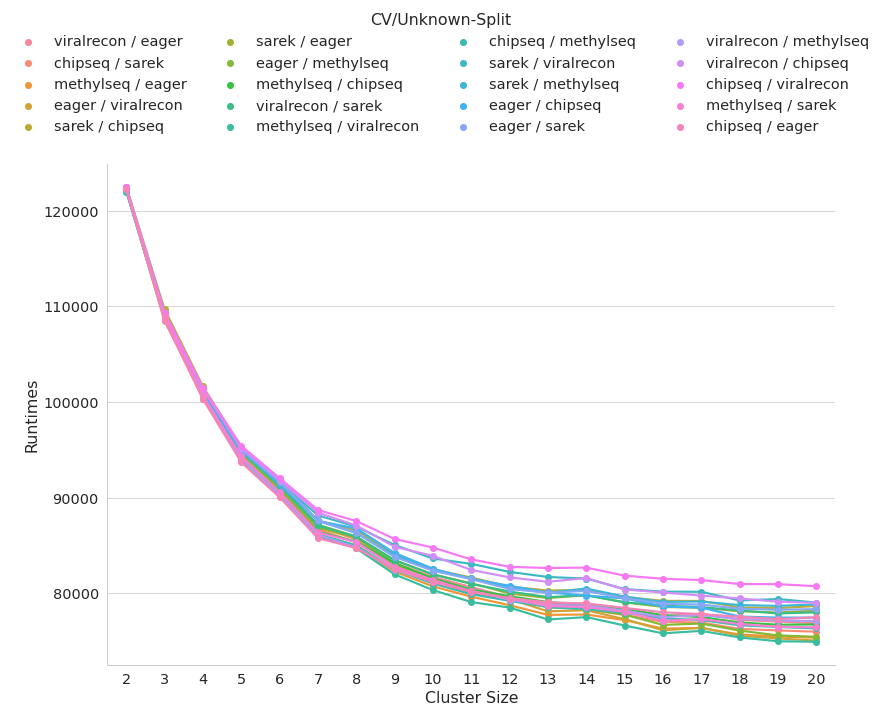

In [236]:
g = sns.catplot(kind="point",
                data=test,
                x="clusterSize",
                y="res",
                aspect=1.5,
                height=8,
                ci=None,
                hue="split")
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="CV/Unknown-Split", frameon=False)
g.set(xlabel="Cluster Size", ylabel="Runtimes")
save_plot(g, "compCV")
plt.show()

-------------

In [237]:
bisCVBigtable["isUk"] = bisCVBigtable.wfName == bisCVBigtable.ukSplit

-------------

In [238]:
t = test.groupby(["wfName", "cluster"])["res"].aggregate(statistics.mean)

In [239]:
c = test[["regModel", "cluster", "clusterSize", "wfName", "method", "cvSplit", "ukSplit", "split"]].join(t, on=["wfName", "cluster"])
c

regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 cvSplit 
 ukSplit 
 split 
 res 
 
 
 
 
 400003 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 35792.8617 
 
 
 400011 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 39889.2800 
 
 
 400019 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 136417.1933 
 
 
 400027 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 27935.7600 
 
 
 400035 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 140067.1433 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 20399963 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 sarek 
 recommenderV1H3 
 chipseq 
 eager 
 chipseq / eager 
 44603.6350 
 
 
 20399971 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 methylseq 
 recommenderV1H3 
 chipseq 
 eager 
 chipseq / eager 
 44678.6700 
 
 
 20399979 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 chipseq 
 recommenderV1H3 
 chipseq 
 eager 
 chipseq / eager 
 184795.1733 
 
 
 20399987 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 eager 
 recommenderV1H3 
 chipseq 
 eager 
 chipseq / eager 
 36044.4500 
 
 
 20399995 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 recommenderV1H3 
 chipseq 
 eager 
 chipseq / eager 
 187552.8667 
 
 
 
 1000000 rows × 9 columns

In [240]:
c = c[c.split == "viralrecon / eager"]
c["Kind"] = "Average CV"
c["Type"] = "Average CV"
c

/tmp/ipykernel_20666/2941573898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Kind"] = "Average CV"
/tmp/ipykernel_20666/2941573898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Type"] = "Average CV"


regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 cvSplit 
 ukSplit 
 split 
 res 
 Kind 
 Type 
 
 
 
 
 400003 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 35792.8617 
 Average CV 
 Average CV 
 
 
 400011 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 39889.2800 
 Average CV 
 Average CV 
 
 
 400019 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 136417.1933 
 Average CV 
 Average CV 
 
 
 400027 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 27935.7600 
 Average CV 
 Average CV 
 
 
 400035 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 140067.1433 
 Average CV 
 Average CV 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 799963 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 sarek 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 44603.6350 
 Average CV 
 Average CV 
 
 
 799971 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 methylseq 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 44678.6700 
 Average CV 
 Average CV 
 
 
 799979 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 chipseq 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 184795.1733 
 Average CV 
 Average CV 
 
 
 799987 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 eager 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 36044.4500 
 Average CV 
 Average CV 
 
 
 799995 
 1 / SVR - rbf 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 recommenderV1H3 
 viralrecon 
 eager 
 viralrecon / eager 
 187552.8667 
 Average CV 
 Average CV 
 
 
 
 50000 rows × 11 columns

In [241]:
bisBigtable["Kind"] = "Full"
bisBigtable["Type"] = "Full"

In [242]:
randomDF: pds.DataFrame = bigtable[bigtable.regModel == "N/A"]
randomDF.append(cvBigtable[cvBigtable.regModel == "N/A"])
randomDF["Kind"] = randomDF["method"].transform(lambda x: x.replace("V1", ""))
randomDF = randomDF.query('Kind == "randomAvg" or  Kind == "randomP0" or Kind == "randomP10" or Kind == "randomP20" or Kind == "randomP30"')
randomDF["Type"] = "Random"
randomDF

/tmp/ipykernel_20666/52642938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randomDF["Kind"] = randomDF["method"].transform(lambda x: x.replace("V1", ""))


regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 res 
 cvSplit 
 ukSplit 
 Kind 
 Type 
 
 
 
 
 4400000 
 N/A 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 randomV1P0 
 33669.8500 
 N/A 
 N/A 
 randomP0 
 Random 
 
 
 4400001 
 N/A 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 randomV1P10 
 38538.1500 
 N/A 
 N/A 
 randomP10 
 Random 
 
 
 4400002 
 N/A 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 randomV1P20 
 41220.2500 
 N/A 
 N/A 
 randomP20 
 Random 
 
 
 4400003 
 N/A 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 randomV1P30 
 43640.7500 
 N/A 
 N/A 
 randomP30 
 Random 
 
 
 4400011 
 N/A 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 randomV1Avg 
 48785.3273 
 N/A 
 N/A 
 randomAvg 
 Random 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 4999988 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P0 
 139765.4000 
 N/A 
 N/A 
 randomP0 
 Random 
 
 
 4999989 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P10 
 164376.2667 
 N/A 
 N/A 
 randomP10 
 Random 
 
 
 4999990 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P20 
 199062.5333 
 N/A 
 N/A 
 randomP20 
 Random 
 
 
 4999991 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P30 
 204181.4667 
 N/A 
 N/A 
 randomP30 
 Random 
 
 
 4999999 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1Avg 
 210963.8848 
 N/A 
 N/A 
 randomAvg 
 Random 
 
 
 
 250000 rows × 10 columns

In [243]:
data = c.append(bisBigtable)
data = data.append(randomDF)
data = data.drop(["cvSplit", "ukSplit", "split"], axis=1)
data.reset_index(drop=True, inplace=True)
data

regModel 
 cluster 
 clusterSize 
 wfName 
 method 
 res 
 Kind 
 Type 
 
 
 
 
 0 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 sarek 
 recommenderV1H3 
 35792.8617 
 Average CV 
 Average CV 
 
 
 1 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 methylseq 
 recommenderV1H3 
 39889.2800 
 Average CV 
 Average CV 
 
 
 2 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 chipseq 
 recommenderV1H3 
 136417.1933 
 Average CV 
 Average CV 
 
 
 3 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 eager 
 recommenderV1H3 
 27935.7600 
 Average CV 
 Average CV 
 
 
 4 
 1 / SVR - rbf 
 (166, 171, 173, 175, 178, 179, 180, 182, 182, ... 
 14 
 viralrecon 
 recommenderV1H3 
 140067.1433 
 Average CV 
 Average CV 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 349995 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P0 
 139765.4000 
 randomP0 
 Random 
 
 
 349996 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P10 
 164376.2667 
 randomP10 
 Random 
 
 
 349997 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P20 
 199062.5333 
 randomP20 
 Random 
 
 
 349998 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1P30 
 204181.4667 
 randomP30 
 Random 
 
 
 349999 
 N/A 
 (178, 181, 181, 182, 183, 184, 185, 185, 187, ... 
 10 
 viralrecon 
 randomV1Avg 
 210963.8848 
 randomAvg 
 Random 
 
 
 
 350000 rows × 8 columns

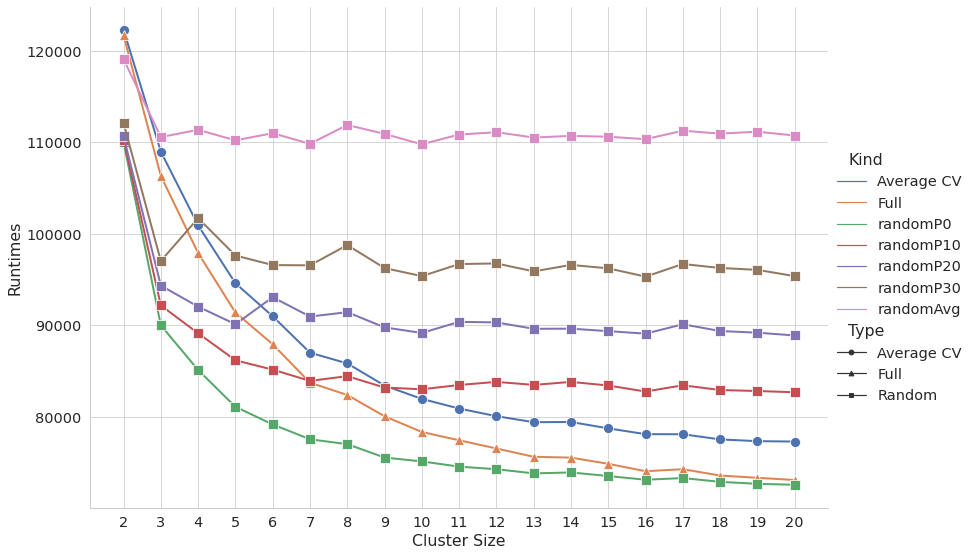

In [244]:
g: sns.FacetGrid = sns.relplot(kind="line",
                               data=data,
                               x="clusterSize",
                               y="res",
                               ci=None,
                               style="Type",
                               markers=["o", "^", "s"],
                               dashes=False,
                               hue="Kind",
                               aspect=1.5,
                               height=8,
                               lw=2,
                               ms=10,
                               )
#sns.move_legend(g, "center left", bbox_to_anchor=(0.82,0.5))#, markerscale=20)
#plt.setp(g.ax.get_legend(), markerscale=2)
#g = g.add_legend(markerscale=2)
g.set(xlabel="Cluster Size", ylabel="Runtimes")
g.ax.set_xticks(range(2, 21))
save_plot(g, "compCVFullRandom")
plt.show()

# [END] trying out new visualisation

In [ ]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [ ]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()



In [ ]:
wfNames = cvBigtable.wfName.unique()

In [ ]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [ ]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [ ]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [ ]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
